In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : False,
    'right'         : True,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(755888, 828)
(755888, 8)
validation
(107504, 828)
(107504, 8)
test
(78032, 828)
(78032, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/76 [..............................] - ETA: 1:44 - loss: 1.7517 - STD: 0.1129 - MAE: 0.1944

 4/76 [>.............................] - ETA: 2s - loss: 1.4948 - STD: 0.1770 - MAE: 0.1579  

 5/76 [>.............................] - ETA: 2s - loss: 1.4692 - STD: 0.1849 - MAE: 0.1540

 6/76 [=>............................] - ETA: 3s - loss: 1.4457 - STD: 0.1874 - MAE: 0.1522

 7/76 [=>............................] - ETA: 3s - loss: 1.4303 - STD: 0.1868 - MAE: 0.1519

 8/76 [==>...........................] - ETA: 3s - loss: 1.4199 - STD: 0.1848 - MAE: 0.1522

 9/76 [==>...........................] - ETA: 3s - loss: 1.4156 - STD: 0.1830 - MAE: 0.1528

10/76 [==>...........................] - ETA: 3s - loss: 1.4091 - STD: 0.1818 - MAE: 0.1529

11/76 [===>..........................] - ETA: 3s - loss: 1.4042 - STD: 0.1817 - MAE: 0.1528

12/76 [===>..........................] - ETA: 3s - loss: 1.4005 - STD: 0.1824 - MAE: 0.1523

13/76 [====>.........................] - ETA: 3s - loss: 1.3970 - STD: 0.1838 - MAE: 0.1516

14/76 [====>.........................] - ETA: 3s - loss: 1.3948 - STD: 0.1855 - MAE: 0.1509

15/76 [====>.........................] - ETA: 3s - loss: 1.3915 - STD: 0.1872 - MAE: 0.1502

16/76 [=====>........................] - ETA: 3s - loss: 1.3881 - STD: 0.1886 - MAE: 0.1494

17/76 [=====>........................] - ETA: 3s - loss: 1.3848 - STD: 0.1896 - MAE: 0.1489

18/76 [======>.......................] - ETA: 3s - loss: 1.3835 - STD: 0.1903 - MAE: 0.1486

19/76 [======>.......................] - ETA: 3s - loss: 1.3806 - STD: 0.1905 - MAE: 0.1484

20/76 [======>.......................] - ETA: 3s - loss: 1.3780 - STD: 0.1904 - MAE: 0.1484

21/76 [=======>......................] - ETA: 3s - loss: 1.3761 - STD: 0.1900 - MAE: 0.1484

22/76 [=======>......................] - ETA: 3s - loss: 1.3744 - STD: 0.1896 - MAE: 0.1485

23/76 [========>.....................] - ETA: 3s - loss: 1.3733 - STD: 0.1892 - MAE: 0.1487

24/76 [========>.....................] - ETA: 3s - loss: 1.3719 - STD: 0.1888 - MAE: 0.1488

25/76 [========>.....................] - ETA: 3s - loss: 1.3699 - STD: 0.1886 - MAE: 0.1488

26/76 [=========>....................] - ETA: 3s - loss: 1.3672 - STD: 0.1885 - MAE: 0.1487

27/76 [=========>....................] - ETA: 3s - loss: 1.3654 - STD: 0.1886 - MAE: 0.1486

28/76 [==========>...................] - ETA: 3s - loss: 1.3640 - STD: 0.1889 - MAE: 0.1485

29/76 [==========>...................] - ETA: 3s - loss: 1.3624 - STD: 0.1892 - MAE: 0.1483

30/76 [==========>...................] - ETA: 2s - loss: 1.3614 - STD: 0.1895 - MAE: 0.1482

31/76 [===========>..................] - ETA: 2s - loss: 1.3604 - STD: 0.1897 - MAE: 0.1481

32/76 [===========>..................] - ETA: 2s - loss: 1.3586 - STD: 0.1897 - MAE: 0.1480

33/76 [============>.................] - ETA: 2s - loss: 1.3574 - STD: 0.1897 - MAE: 0.1479

34/76 [============>.................] - ETA: 2s - loss: 1.3567 - STD: 0.1895 - MAE: 0.1480

35/76 [============>.................] - ETA: 2s - loss: 1.3557 - STD: 0.1893 - MAE: 0.1480

36/76 [=============>................] - ETA: 2s - loss: 1.3549 - STD: 0.1891 - MAE: 0.1481

37/76 [=============>................] - ETA: 2s - loss: 1.3543 - STD: 0.1888 - MAE: 0.1482

38/76 [==============>...............] - ETA: 2s - loss: 1.3536 - STD: 0.1887 - MAE: 0.1483

39/76 [==============>...............] - ETA: 2s - loss: 1.3528 - STD: 0.1885 - MAE: 0.1483

40/76 [==============>...............] - ETA: 2s - loss: 1.3524 - STD: 0.1885 - MAE: 0.1483

41/76 [===============>..............] - ETA: 2s - loss: 1.3518 - STD: 0.1885 - MAE: 0.1482

42/76 [===============>..............] - ETA: 2s - loss: 1.3509 - STD: 0.1886 - MAE: 0.1482

43/76 [===============>..............] - ETA: 2s - loss: 1.3497 - STD: 0.1886 - MAE: 0.1481

44/76 [================>.............] - ETA: 2s - loss: 1.3490 - STD: 0.1886 - MAE: 0.1481

45/76 [================>.............] - ETA: 2s - loss: 1.3482 - STD: 0.1886 - MAE: 0.1481

46/76 [=================>............] - ETA: 1s - loss: 1.3473 - STD: 0.1886 - MAE: 0.1481

47/76 [=================>............] - ETA: 1s - loss: 1.3469 - STD: 0.1885 - MAE: 0.1481

48/76 [=================>............] - ETA: 1s - loss: 1.3461 - STD: 0.1884 - MAE: 0.1481

49/76 [==================>...........] - ETA: 1s - loss: 1.3449 - STD: 0.1884 - MAE: 0.1480

50/76 [==================>...........] - ETA: 1s - loss: 1.3439 - STD: 0.1884 - MAE: 0.1480

51/76 [===================>..........] - ETA: 1s - loss: 1.3432 - STD: 0.1884 - MAE: 0.1479

52/76 [===================>..........] - ETA: 1s - loss: 1.3424 - STD: 0.1885 - MAE: 0.1479

53/76 [===================>..........] - ETA: 1s - loss: 1.3418 - STD: 0.1886 - MAE: 0.1478

54/76 [====================>.........] - ETA: 1s - loss: 1.3412 - STD: 0.1887 - MAE: 0.1478

55/76 [====================>.........] - ETA: 1s - loss: 1.3402 - STD: 0.1886 - MAE: 0.1477

56/76 [=====================>........] - ETA: 1s - loss: 1.3391 - STD: 0.1886 - MAE: 0.1477

57/76 [=====================>........] - ETA: 1s - loss: 1.3379 - STD: 0.1885 - MAE: 0.1477

58/76 [=====================>........] - ETA: 1s - loss: 1.3369 - STD: 0.1886 - MAE: 0.1476

59/76 [======================>.......] - ETA: 1s - loss: 1.3357 - STD: 0.1887 - MAE: 0.1475

60/76 [======================>.......] - ETA: 1s - loss: 1.3347 - STD: 0.1889 - MAE: 0.1474

61/76 [=======================>......] - ETA: 0s - loss: 1.3333 - STD: 0.1890 - MAE: 0.1473

62/76 [=======================>......] - ETA: 0s - loss: 1.3322 - STD: 0.1891 - MAE: 0.1472

63/76 [=======================>......] - ETA: 0s - loss: 1.3311 - STD: 0.1891 - MAE: 0.1471

64/76 [========================>.....] - ETA: 0s - loss: 1.3301 - STD: 0.1892 - MAE: 0.1471

65/76 [========================>.....] - ETA: 0s - loss: 1.3292 - STD: 0.1893 - MAE: 0.1470

66/76 [=========================>....] - ETA: 0s - loss: 1.3280 - STD: 0.1895 - MAE: 0.1469

67/76 [=========================>....] - ETA: 0s - loss: 1.3270 - STD: 0.1896 - MAE: 0.1468

68/76 [=========================>....] - ETA: 0s - loss: 1.3261 - STD: 0.1897 - MAE: 0.1467

69/76 [==========================>...] - ETA: 0s - loss: 1.3251 - STD: 0.1898 - MAE: 0.1466

70/76 [==========================>...] - ETA: 0s - loss: 1.3240 - STD: 0.1898 - MAE: 0.1466

71/76 [===========================>..] - ETA: 0s - loss: 1.3234 - STD: 0.1899 - MAE: 0.1465

75/76 [============================>.] - ETA: 0s - loss: 1.3193 - STD: 0.1901 - MAE: 0.1463

76/76 [==============================] - ETA: 0s - loss: 1.3182 - STD: 0.1902 - MAE: 0.1462

76/76 [==============================] - 8s 83ms/step - loss: 1.3182 - STD: 0.1902 - MAE: 0.1462 - val_loss: 1.2142 - val_STD: 0.1977 - val_MAE: 0.1386


Epoch 2/10000


 1/76 [..............................] - ETA: 7s - loss: 1.2347 - STD: 0.1992 - MAE: 0.1393

 2/76 [..............................] - ETA: 5s - loss: 1.2334 - STD: 0.2019 - MAE: 0.1383

 3/76 [>.............................] - ETA: 5s - loss: 1.2343 - STD: 0.2018 - MAE: 0.1384

 4/76 [>.............................] - ETA: 5s - loss: 1.2352 - STD: 0.2006 - MAE: 0.1390

 5/76 [>.............................] - ETA: 4s - loss: 1.2340 - STD: 0.1998 - MAE: 0.1394

 6/76 [=>............................] - ETA: 4s - loss: 1.2290 - STD: 0.1996 - MAE: 0.1392

 7/76 [=>............................] - ETA: 4s - loss: 1.2278 - STD: 0.1994 - MAE: 0.1392

 8/76 [==>...........................] - ETA: 4s - loss: 1.2274 - STD: 0.1993 - MAE: 0.1393

 9/76 [==>...........................] - ETA: 4s - loss: 1.2268 - STD: 0.1989 - MAE: 0.1394

10/76 [==>...........................] - ETA: 4s - loss: 1.2244 - STD: 0.1986 - MAE: 0.1394

11/76 [===>..........................] - ETA: 4s - loss: 1.2237 - STD: 0.1987 - MAE: 0.1394

12/76 [===>..........................] - ETA: 4s - loss: 1.2235 - STD: 0.1990 - MAE: 0.1393

13/76 [====>.........................] - ETA: 4s - loss: 1.2217 - STD: 0.1988 - MAE: 0.1392

14/76 [====>.........................] - ETA: 4s - loss: 1.2206 - STD: 0.1986 - MAE: 0.1393

15/76 [====>.........................] - ETA: 4s - loss: 1.2188 - STD: 0.1987 - MAE: 0.1392

16/76 [=====>........................] - ETA: 4s - loss: 1.2181 - STD: 0.1989 - MAE: 0.1391

17/76 [=====>........................] - ETA: 4s - loss: 1.2173 - STD: 0.1989 - MAE: 0.1391

18/76 [======>.......................] - ETA: 3s - loss: 1.2164 - STD: 0.1987 - MAE: 0.1392

19/76 [======>.......................] - ETA: 3s - loss: 1.2157 - STD: 0.1987 - MAE: 0.1391

20/76 [======>.......................] - ETA: 3s - loss: 1.2150 - STD: 0.1987 - MAE: 0.1391

21/76 [=======>......................] - ETA: 3s - loss: 1.2134 - STD: 0.1985 - MAE: 0.1391

22/76 [=======>......................] - ETA: 3s - loss: 1.2123 - STD: 0.1986 - MAE: 0.1391

23/76 [========>.....................] - ETA: 3s - loss: 1.2114 - STD: 0.1987 - MAE: 0.1390

24/76 [========>.....................] - ETA: 3s - loss: 1.2106 - STD: 0.1988 - MAE: 0.1389

25/76 [========>.....................] - ETA: 3s - loss: 1.2096 - STD: 0.1987 - MAE: 0.1390

26/76 [=========>....................] - ETA: 3s - loss: 1.2084 - STD: 0.1986 - MAE: 0.1389

27/76 [=========>....................] - ETA: 3s - loss: 1.2075 - STD: 0.1986 - MAE: 0.1389

28/76 [==========>...................] - ETA: 3s - loss: 1.2062 - STD: 0.1986 - MAE: 0.1389

29/76 [==========>...................] - ETA: 3s - loss: 1.2049 - STD: 0.1986 - MAE: 0.1388

30/76 [==========>...................] - ETA: 3s - loss: 1.2039 - STD: 0.1988 - MAE: 0.1387

31/76 [===========>..................] - ETA: 3s - loss: 1.2024 - STD: 0.1990 - MAE: 0.1386

32/76 [===========>..................] - ETA: 2s - loss: 1.2010 - STD: 0.1990 - MAE: 0.1386

33/76 [============>.................] - ETA: 2s - loss: 1.2003 - STD: 0.1990 - MAE: 0.1386

34/76 [============>.................] - ETA: 2s - loss: 1.1990 - STD: 0.1990 - MAE: 0.1385

35/76 [============>.................] - ETA: 2s - loss: 1.1980 - STD: 0.1990 - MAE: 0.1384

36/76 [=============>................] - ETA: 2s - loss: 1.1966 - STD: 0.1990 - MAE: 0.1384

37/76 [=============>................] - ETA: 2s - loss: 1.1955 - STD: 0.1992 - MAE: 0.1383

38/76 [==============>...............] - ETA: 2s - loss: 1.1943 - STD: 0.1995 - MAE: 0.1381

39/76 [==============>...............] - ETA: 2s - loss: 1.1938 - STD: 0.1995 - MAE: 0.1381

41/76 [===============>..............] - ETA: 2s - loss: 1.1923 - STD: 0.1995 - MAE: 0.1380

42/76 [===============>..............] - ETA: 2s - loss: 1.1913 - STD: 0.1996 - MAE: 0.1380

43/76 [===============>..............] - ETA: 2s - loss: 1.1902 - STD: 0.1994 - MAE: 0.1380

44/76 [================>.............] - ETA: 2s - loss: 1.1891 - STD: 0.1995 - MAE: 0.1379

45/76 [================>.............] - ETA: 2s - loss: 1.1881 - STD: 0.1998 - MAE: 0.1378

46/76 [=================>............] - ETA: 2s - loss: 1.1870 - STD: 0.1998 - MAE: 0.1378

47/76 [=================>............] - ETA: 1s - loss: 1.1858 - STD: 0.1998 - MAE: 0.1377

48/76 [=================>............] - ETA: 1s - loss: 1.1849 - STD: 0.1999 - MAE: 0.1376

49/76 [==================>...........] - ETA: 1s - loss: 1.1836 - STD: 0.2001 - MAE: 0.1375

50/76 [==================>...........] - ETA: 1s - loss: 1.1826 - STD: 0.2000 - MAE: 0.1375

51/76 [===================>..........] - ETA: 1s - loss: 1.1816 - STD: 0.2000 - MAE: 0.1375

52/76 [===================>..........] - ETA: 1s - loss: 1.1809 - STD: 0.2001 - MAE: 0.1374

53/76 [===================>..........] - ETA: 1s - loss: 1.1797 - STD: 0.2002 - MAE: 0.1374

54/76 [====================>.........] - ETA: 1s - loss: 1.1784 - STD: 0.2002 - MAE: 0.1373

55/76 [====================>.........] - ETA: 1s - loss: 1.1776 - STD: 0.2003 - MAE: 0.1373

56/76 [=====================>........] - ETA: 1s - loss: 1.1764 - STD: 0.2004 - MAE: 0.1372

57/76 [=====================>........] - ETA: 1s - loss: 1.1752 - STD: 0.2004 - MAE: 0.1372

58/76 [=====================>........] - ETA: 1s - loss: 1.1739 - STD: 0.2004 - MAE: 0.1371

59/76 [======================>.......] - ETA: 1s - loss: 1.1726 - STD: 0.2007 - MAE: 0.1370

60/76 [======================>.......] - ETA: 1s - loss: 1.1714 - STD: 0.2007 - MAE: 0.1369

61/76 [=======================>......] - ETA: 1s - loss: 1.1705 - STD: 0.2006 - MAE: 0.1369

62/76 [=======================>......] - ETA: 0s - loss: 1.1691 - STD: 0.2007 - MAE: 0.1368

63/76 [=======================>......] - ETA: 0s - loss: 1.1679 - STD: 0.2009 - MAE: 0.1367

64/76 [========================>.....] - ETA: 0s - loss: 1.1668 - STD: 0.2010 - MAE: 0.1367

65/76 [========================>.....] - ETA: 0s - loss: 1.1658 - STD: 0.2009 - MAE: 0.1366

66/76 [=========================>....] - ETA: 0s - loss: 1.1645 - STD: 0.2010 - MAE: 0.1366

67/76 [=========================>....] - ETA: 0s - loss: 1.1631 - STD: 0.2011 - MAE: 0.1365

68/76 [=========================>....] - ETA: 0s - loss: 1.1616 - STD: 0.2011 - MAE: 0.1364

69/76 [==========================>...] - ETA: 0s - loss: 1.1605 - STD: 0.2011 - MAE: 0.1364

70/76 [==========================>...] - ETA: 0s - loss: 1.1590 - STD: 0.2013 - MAE: 0.1363

71/76 [===========================>..] - ETA: 0s - loss: 1.1578 - STD: 0.2014 - MAE: 0.1362

72/76 [===========================>..] - ETA: 0s - loss: 1.1566 - STD: 0.2013 - MAE: 0.1362

73/76 [===========================>..] - ETA: 0s - loss: 1.1551 - STD: 0.2014 - MAE: 0.1361

74/76 [============================>.] - ETA: 0s - loss: 1.1537 - STD: 0.2016 - MAE: 0.1360

75/76 [============================>.] - ETA: 0s - loss: 1.1522 - STD: 0.2016 - MAE: 0.1360

76/76 [==============================] - ETA: 0s - loss: 1.1506 - STD: 0.2016 - MAE: 0.1359

76/76 [==============================] - 5s 71ms/step - loss: 1.1506 - STD: 0.2016 - MAE: 0.1359 - val_loss: 1.0025 - val_STD: 0.2160 - val_MAE: 0.1242


Epoch 3/10000


 1/76 [..............................] - ETA: 7s - loss: 1.0402 - STD: 0.2174 - MAE: 0.1268

 2/76 [..............................] - ETA: 5s - loss: 1.0376 - STD: 0.2116 - MAE: 0.1288

 3/76 [>.............................] - ETA: 5s - loss: 1.0339 - STD: 0.2079 - MAE: 0.1301

 4/76 [>.............................] - ETA: 5s - loss: 1.0270 - STD: 0.2096 - MAE: 0.1289

 5/76 [>.............................] - ETA: 4s - loss: 1.0267 - STD: 0.2111 - MAE: 0.1282

 6/76 [=>............................] - ETA: 4s - loss: 1.0243 - STD: 0.2112 - MAE: 0.1281

 7/76 [=>............................] - ETA: 4s - loss: 1.0230 - STD: 0.2106 - MAE: 0.1284

 8/76 [==>...........................] - ETA: 4s - loss: 1.0178 - STD: 0.2102 - MAE: 0.1282

 9/76 [==>...........................] - ETA: 4s - loss: 1.0154 - STD: 0.2107 - MAE: 0.1279

10/76 [==>...........................] - ETA: 4s - loss: 1.0143 - STD: 0.2111 - MAE: 0.1277

11/76 [===>..........................] - ETA: 4s - loss: 1.0133 - STD: 0.2115 - MAE: 0.1275

12/76 [===>..........................] - ETA: 4s - loss: 1.0133 - STD: 0.2112 - MAE: 0.1277

13/76 [====>.........................] - ETA: 4s - loss: 1.0113 - STD: 0.2108 - MAE: 0.1278

14/76 [====>.........................] - ETA: 4s - loss: 1.0101 - STD: 0.2115 - MAE: 0.1274

15/76 [====>.........................] - ETA: 4s - loss: 1.0096 - STD: 0.2119 - MAE: 0.1272

16/76 [=====>........................] - ETA: 4s - loss: 1.0085 - STD: 0.2116 - MAE: 0.1273

17/76 [=====>........................] - ETA: 4s - loss: 1.0079 - STD: 0.2117 - MAE: 0.1272

18/76 [======>.......................] - ETA: 3s - loss: 1.0069 - STD: 0.2119 - MAE: 0.1271

19/76 [======>.......................] - ETA: 3s - loss: 1.0059 - STD: 0.2120 - MAE: 0.1270

21/76 [=======>......................] - ETA: 3s - loss: 1.0036 - STD: 0.2123 - MAE: 0.1268

22/76 [=======>......................] - ETA: 3s - loss: 1.0014 - STD: 0.2123 - MAE: 0.1267

23/76 [========>.....................] - ETA: 3s - loss: 1.0003 - STD: 0.2124 - MAE: 0.1266

24/76 [========>.....................] - ETA: 3s - loss: 0.9991 - STD: 0.2128 - MAE: 0.1264

25/76 [========>.....................] - ETA: 3s - loss: 0.9973 - STD: 0.2127 - MAE: 0.1263

26/76 [=========>....................] - ETA: 3s - loss: 0.9961 - STD: 0.2127 - MAE: 0.1263

27/76 [=========>....................] - ETA: 3s - loss: 0.9952 - STD: 0.2130 - MAE: 0.1261

28/76 [==========>...................] - ETA: 3s - loss: 0.9942 - STD: 0.2131 - MAE: 0.1260

29/76 [==========>...................] - ETA: 3s - loss: 0.9932 - STD: 0.2130 - MAE: 0.1260

30/76 [==========>...................] - ETA: 3s - loss: 0.9925 - STD: 0.2132 - MAE: 0.1259

31/76 [===========>..................] - ETA: 2s - loss: 0.9914 - STD: 0.2134 - MAE: 0.1258

32/76 [===========>..................] - ETA: 2s - loss: 0.9902 - STD: 0.2136 - MAE: 0.1256

33/76 [============>.................] - ETA: 2s - loss: 0.9895 - STD: 0.2135 - MAE: 0.1256

34/76 [============>.................] - ETA: 2s - loss: 0.9891 - STD: 0.2136 - MAE: 0.1256

35/76 [============>.................] - ETA: 2s - loss: 0.9885 - STD: 0.2136 - MAE: 0.1255

36/76 [=============>................] - ETA: 2s - loss: 0.9877 - STD: 0.2138 - MAE: 0.1254

37/76 [=============>................] - ETA: 2s - loss: 0.9865 - STD: 0.2138 - MAE: 0.1253

38/76 [==============>...............] - ETA: 2s - loss: 0.9856 - STD: 0.2140 - MAE: 0.1252

39/76 [==============>...............] - ETA: 2s - loss: 0.9845 - STD: 0.2140 - MAE: 0.1252

40/76 [==============>...............] - ETA: 2s - loss: 0.9831 - STD: 0.2142 - MAE: 0.1250

41/76 [===============>..............] - ETA: 2s - loss: 0.9825 - STD: 0.2145 - MAE: 0.1249

42/76 [===============>..............] - ETA: 2s - loss: 0.9821 - STD: 0.2144 - MAE: 0.1249

43/76 [===============>..............] - ETA: 2s - loss: 0.9813 - STD: 0.2144 - MAE: 0.1248

44/76 [================>.............] - ETA: 2s - loss: 0.9799 - STD: 0.2148 - MAE: 0.1246

45/76 [================>.............] - ETA: 2s - loss: 0.9792 - STD: 0.2149 - MAE: 0.1245

46/76 [=================>............] - ETA: 1s - loss: 0.9782 - STD: 0.2148 - MAE: 0.1245

47/76 [=================>............] - ETA: 1s - loss: 0.9774 - STD: 0.2152 - MAE: 0.1243

48/76 [=================>............] - ETA: 1s - loss: 0.9767 - STD: 0.2153 - MAE: 0.1242

49/76 [==================>...........] - ETA: 1s - loss: 0.9763 - STD: 0.2152 - MAE: 0.1243

50/76 [==================>...........] - ETA: 1s - loss: 0.9754 - STD: 0.2154 - MAE: 0.1241

51/76 [===================>..........] - ETA: 1s - loss: 0.9747 - STD: 0.2157 - MAE: 0.1240

52/76 [===================>..........] - ETA: 1s - loss: 0.9740 - STD: 0.2156 - MAE: 0.1240

53/76 [===================>..........] - ETA: 1s - loss: 0.9732 - STD: 0.2156 - MAE: 0.1239

54/76 [====================>.........] - ETA: 1s - loss: 0.9724 - STD: 0.2159 - MAE: 0.1238

55/76 [====================>.........] - ETA: 1s - loss: 0.9716 - STD: 0.2160 - MAE: 0.1237

56/76 [=====================>........] - ETA: 1s - loss: 0.9708 - STD: 0.2159 - MAE: 0.1237

57/76 [=====================>........] - ETA: 1s - loss: 0.9701 - STD: 0.2161 - MAE: 0.1236

58/76 [=====================>........] - ETA: 1s - loss: 0.9692 - STD: 0.2163 - MAE: 0.1234

59/76 [======================>.......] - ETA: 1s - loss: 0.9687 - STD: 0.2163 - MAE: 0.1234

60/76 [======================>.......] - ETA: 1s - loss: 0.9683 - STD: 0.2163 - MAE: 0.1234

61/76 [=======================>......] - ETA: 0s - loss: 0.9676 - STD: 0.2165 - MAE: 0.1233

62/76 [=======================>......] - ETA: 0s - loss: 0.9668 - STD: 0.2166 - MAE: 0.1232

63/76 [=======================>......] - ETA: 0s - loss: 0.9661 - STD: 0.2166 - MAE: 0.1231

64/76 [========================>.....] - ETA: 0s - loss: 0.9655 - STD: 0.2167 - MAE: 0.1230

65/76 [========================>.....] - ETA: 0s - loss: 0.9648 - STD: 0.2168 - MAE: 0.1230

66/76 [=========================>....] - ETA: 0s - loss: 0.9642 - STD: 0.2169 - MAE: 0.1229

67/76 [=========================>....] - ETA: 0s - loss: 0.9635 - STD: 0.2170 - MAE: 0.1228

68/76 [=========================>....] - ETA: 0s - loss: 0.9627 - STD: 0.2171 - MAE: 0.1227

69/76 [==========================>...] - ETA: 0s - loss: 0.9620 - STD: 0.2172 - MAE: 0.1227

70/76 [==========================>...] - ETA: 0s - loss: 0.9617 - STD: 0.2172 - MAE: 0.1226

71/76 [===========================>..] - ETA: 0s - loss: 0.9613 - STD: 0.2172 - MAE: 0.1226

72/76 [===========================>..] - ETA: 0s - loss: 0.9606 - STD: 0.2173 - MAE: 0.1226

73/76 [===========================>..] - ETA: 0s - loss: 0.9603 - STD: 0.2175 - MAE: 0.1225

74/76 [============================>.] - ETA: 0s - loss: 0.9597 - STD: 0.2174 - MAE: 0.1225

75/76 [============================>.] - ETA: 0s - loss: 0.9592 - STD: 0.2175 - MAE: 0.1224

76/76 [==============================] - ETA: 0s - loss: 0.9592 - STD: 0.2176 - MAE: 0.1223

76/76 [==============================] - 5s 70ms/step - loss: 0.9592 - STD: 0.2176 - MAE: 0.1223 - val_loss: 0.8783 - val_STD: 0.2145 - val_MAE: 0.1185


Epoch 4/10000


 1/76 [..............................] - ETA: 6s - loss: 0.9270 - STD: 0.2147 - MAE: 0.1224

 2/76 [..............................] - ETA: 4s - loss: 0.9192 - STD: 0.2182 - MAE: 0.1203

 3/76 [>.............................] - ETA: 4s - loss: 0.9225 - STD: 0.2218 - MAE: 0.1188

 4/76 [>.............................] - ETA: 4s - loss: 0.9249 - STD: 0.2211 - MAE: 0.1192

 5/76 [>.............................] - ETA: 4s - loss: 0.9240 - STD: 0.2207 - MAE: 0.1194

 6/76 [=>............................] - ETA: 4s - loss: 0.9217 - STD: 0.2225 - MAE: 0.1185

 7/76 [=>............................] - ETA: 4s - loss: 0.9219 - STD: 0.2226 - MAE: 0.1185

 8/76 [==>...........................] - ETA: 4s - loss: 0.9205 - STD: 0.2214 - MAE: 0.1189

 9/76 [==>...........................] - ETA: 4s - loss: 0.9195 - STD: 0.2227 - MAE: 0.1183

10/76 [==>...........................] - ETA: 4s - loss: 0.9189 - STD: 0.2230 - MAE: 0.1181

11/76 [===>..........................] - ETA: 4s - loss: 0.9191 - STD: 0.2220 - MAE: 0.1186

12/76 [===>..........................] - ETA: 4s - loss: 0.9187 - STD: 0.2224 - MAE: 0.1184

13/76 [====>.........................] - ETA: 4s - loss: 0.9188 - STD: 0.2227 - MAE: 0.1182

14/76 [====>.........................] - ETA: 4s - loss: 0.9190 - STD: 0.2224 - MAE: 0.1184

15/76 [====>.........................] - ETA: 4s - loss: 0.9180 - STD: 0.2226 - MAE: 0.1182

16/76 [=====>........................] - ETA: 4s - loss: 0.9180 - STD: 0.2232 - MAE: 0.1180

17/76 [=====>........................] - ETA: 3s - loss: 0.9175 - STD: 0.2228 - MAE: 0.1181

18/76 [======>.......................] - ETA: 3s - loss: 0.9173 - STD: 0.2229 - MAE: 0.1180

19/76 [======>.......................] - ETA: 3s - loss: 0.9161 - STD: 0.2232 - MAE: 0.1178

20/76 [======>.......................] - ETA: 3s - loss: 0.9160 - STD: 0.2232 - MAE: 0.1179

21/76 [=======>......................] - ETA: 3s - loss: 0.9157 - STD: 0.2231 - MAE: 0.1179

22/76 [=======>......................] - ETA: 3s - loss: 0.9152 - STD: 0.2234 - MAE: 0.1177

23/76 [========>.....................] - ETA: 3s - loss: 0.9153 - STD: 0.2234 - MAE: 0.1177

24/76 [========>.....................] - ETA: 3s - loss: 0.9152 - STD: 0.2232 - MAE: 0.1178

25/76 [========>.....................] - ETA: 3s - loss: 0.9152 - STD: 0.2232 - MAE: 0.1178

26/76 [=========>....................] - ETA: 3s - loss: 0.9150 - STD: 0.2234 - MAE: 0.1177

27/76 [=========>....................] - ETA: 3s - loss: 0.9149 - STD: 0.2233 - MAE: 0.1178

28/76 [==========>...................] - ETA: 3s - loss: 0.9147 - STD: 0.2233 - MAE: 0.1178

29/76 [==========>...................] - ETA: 3s - loss: 0.9142 - STD: 0.2233 - MAE: 0.1177

30/76 [==========>...................] - ETA: 3s - loss: 0.9140 - STD: 0.2234 - MAE: 0.1176

31/76 [===========>..................] - ETA: 3s - loss: 0.9133 - STD: 0.2235 - MAE: 0.1176

32/76 [===========>..................] - ETA: 2s - loss: 0.9129 - STD: 0.2235 - MAE: 0.1175

34/76 [============>.................] - ETA: 2s - loss: 0.9122 - STD: 0.2236 - MAE: 0.1174

35/76 [============>.................] - ETA: 2s - loss: 0.9120 - STD: 0.2238 - MAE: 0.1174

36/76 [=============>................] - ETA: 2s - loss: 0.9118 - STD: 0.2237 - MAE: 0.1174

37/76 [=============>................] - ETA: 2s - loss: 0.9115 - STD: 0.2239 - MAE: 0.1173

38/76 [==============>...............] - ETA: 2s - loss: 0.9114 - STD: 0.2238 - MAE: 0.1173

39/76 [==============>...............] - ETA: 2s - loss: 0.9108 - STD: 0.2238 - MAE: 0.1173

40/76 [==============>...............] - ETA: 2s - loss: 0.9104 - STD: 0.2240 - MAE: 0.1172

41/76 [===============>..............] - ETA: 2s - loss: 0.9102 - STD: 0.2239 - MAE: 0.1172

42/76 [===============>..............] - ETA: 2s - loss: 0.9102 - STD: 0.2239 - MAE: 0.1172

43/76 [===============>..............] - ETA: 2s - loss: 0.9098 - STD: 0.2241 - MAE: 0.1171

44/76 [================>.............] - ETA: 2s - loss: 0.9097 - STD: 0.2240 - MAE: 0.1172

45/76 [================>.............] - ETA: 2s - loss: 0.9098 - STD: 0.2241 - MAE: 0.1171

46/76 [=================>............] - ETA: 1s - loss: 0.9093 - STD: 0.2241 - MAE: 0.1171

47/76 [=================>............] - ETA: 1s - loss: 0.9086 - STD: 0.2241 - MAE: 0.1171

48/76 [=================>............] - ETA: 1s - loss: 0.9084 - STD: 0.2243 - MAE: 0.1170

49/76 [==================>...........] - ETA: 1s - loss: 0.9081 - STD: 0.2242 - MAE: 0.1170

50/76 [==================>...........] - ETA: 1s - loss: 0.9081 - STD: 0.2243 - MAE: 0.1169

51/76 [===================>..........] - ETA: 1s - loss: 0.9076 - STD: 0.2243 - MAE: 0.1169

52/76 [===================>..........] - ETA: 1s - loss: 0.9072 - STD: 0.2244 - MAE: 0.1168

53/76 [===================>..........] - ETA: 1s - loss: 0.9070 - STD: 0.2244 - MAE: 0.1169

54/76 [====================>.........] - ETA: 1s - loss: 0.9069 - STD: 0.2244 - MAE: 0.1168

55/76 [====================>.........] - ETA: 1s - loss: 0.9068 - STD: 0.2244 - MAE: 0.1168

56/76 [=====================>........] - ETA: 1s - loss: 0.9066 - STD: 0.2244 - MAE: 0.1168

57/76 [=====================>........] - ETA: 1s - loss: 0.9063 - STD: 0.2246 - MAE: 0.1167

58/76 [=====================>........] - ETA: 1s - loss: 0.9064 - STD: 0.2245 - MAE: 0.1168

59/76 [======================>.......] - ETA: 1s - loss: 0.9062 - STD: 0.2245 - MAE: 0.1167

60/76 [======================>.......] - ETA: 1s - loss: 0.9058 - STD: 0.2247 - MAE: 0.1166

61/76 [=======================>......] - ETA: 0s - loss: 0.9059 - STD: 0.2245 - MAE: 0.1167

62/76 [=======================>......] - ETA: 0s - loss: 0.9056 - STD: 0.2247 - MAE: 0.1167

63/76 [=======================>......] - ETA: 0s - loss: 0.9057 - STD: 0.2248 - MAE: 0.1166

64/76 [========================>.....] - ETA: 0s - loss: 0.9056 - STD: 0.2246 - MAE: 0.1167

65/76 [========================>.....] - ETA: 0s - loss: 0.9054 - STD: 0.2247 - MAE: 0.1166

66/76 [=========================>....] - ETA: 0s - loss: 0.9054 - STD: 0.2249 - MAE: 0.1166

67/76 [=========================>....] - ETA: 0s - loss: 0.9052 - STD: 0.2248 - MAE: 0.1166

68/76 [=========================>....] - ETA: 0s - loss: 0.9052 - STD: 0.2248 - MAE: 0.1166

69/76 [==========================>...] - ETA: 0s - loss: 0.9049 - STD: 0.2249 - MAE: 0.1165

70/76 [==========================>...] - ETA: 0s - loss: 0.9053 - STD: 0.2249 - MAE: 0.1166

71/76 [===========================>..] - ETA: 0s - loss: 0.9052 - STD: 0.2249 - MAE: 0.1165

72/76 [===========================>..] - ETA: 0s - loss: 0.9049 - STD: 0.2249 - MAE: 0.1165

73/76 [===========================>..] - ETA: 0s - loss: 0.9049 - STD: 0.2250 - MAE: 0.1165

74/76 [============================>.] - ETA: 0s - loss: 0.9045 - STD: 0.2250 - MAE: 0.1165

75/76 [============================>.] - ETA: 0s - loss: 0.9045 - STD: 0.2251 - MAE: 0.1164

76/76 [==============================] - ETA: 0s - loss: 0.9043 - STD: 0.2251 - MAE: 0.1164

76/76 [==============================] - 5s 70ms/step - loss: 0.9043 - STD: 0.2251 - MAE: 0.1164 - val_loss: 0.8511 - val_STD: 0.2199 - val_MAE: 0.1147


Epoch 5/10000


 1/76 [..............................] - ETA: 7s - loss: 0.8908 - STD: 0.2206 - MAE: 0.1172

 2/76 [..............................] - ETA: 5s - loss: 0.8925 - STD: 0.2279 - MAE: 0.1143

 3/76 [>.............................] - ETA: 5s - loss: 0.8877 - STD: 0.2281 - MAE: 0.1140

 4/76 [>.............................] - ETA: 5s - loss: 0.8884 - STD: 0.2257 - MAE: 0.1151

 5/76 [>.............................] - ETA: 5s - loss: 0.8901 - STD: 0.2258 - MAE: 0.1153

 6/76 [=>............................] - ETA: 4s - loss: 0.8917 - STD: 0.2264 - MAE: 0.1151

 7/76 [=>............................] - ETA: 4s - loss: 0.8922 - STD: 0.2264 - MAE: 0.1152

 8/76 [==>...........................] - ETA: 4s - loss: 0.8916 - STD: 0.2260 - MAE: 0.1152

 9/76 [==>...........................] - ETA: 4s - loss: 0.8898 - STD: 0.2264 - MAE: 0.1150

10/76 [==>...........................] - ETA: 4s - loss: 0.8895 - STD: 0.2267 - MAE: 0.1149

11/76 [===>..........................] - ETA: 4s - loss: 0.8890 - STD: 0.2269 - MAE: 0.1147

12/76 [===>..........................] - ETA: 4s - loss: 0.8888 - STD: 0.2266 - MAE: 0.1149

13/76 [====>.........................] - ETA: 4s - loss: 0.8895 - STD: 0.2264 - MAE: 0.1150

14/76 [====>.........................] - ETA: 4s - loss: 0.8884 - STD: 0.2270 - MAE: 0.1147

15/76 [====>.........................] - ETA: 4s - loss: 0.8878 - STD: 0.2270 - MAE: 0.1146

16/76 [=====>........................] - ETA: 4s - loss: 0.8875 - STD: 0.2265 - MAE: 0.1148

17/76 [=====>........................] - ETA: 3s - loss: 0.8870 - STD: 0.2271 - MAE: 0.1146

18/76 [======>.......................] - ETA: 3s - loss: 0.8892 - STD: 0.2274 - MAE: 0.1146

19/76 [======>.......................] - ETA: 3s - loss: 0.8899 - STD: 0.2266 - MAE: 0.1150

20/76 [======>.......................] - ETA: 3s - loss: 0.8892 - STD: 0.2267 - MAE: 0.1149

21/76 [=======>......................] - ETA: 3s - loss: 0.8887 - STD: 0.2275 - MAE: 0.1145

22/76 [=======>......................] - ETA: 3s - loss: 0.8895 - STD: 0.2272 - MAE: 0.1147

23/76 [========>.....................] - ETA: 3s - loss: 0.8891 - STD: 0.2270 - MAE: 0.1148

24/76 [========>.....................] - ETA: 3s - loss: 0.8897 - STD: 0.2273 - MAE: 0.1147

25/76 [========>.....................] - ETA: 3s - loss: 0.8901 - STD: 0.2273 - MAE: 0.1147

26/76 [=========>....................] - ETA: 3s - loss: 0.8905 - STD: 0.2271 - MAE: 0.1148

27/76 [=========>....................] - ETA: 3s - loss: 0.8908 - STD: 0.2273 - MAE: 0.1148

28/76 [==========>...................] - ETA: 3s - loss: 0.8905 - STD: 0.2273 - MAE: 0.1147

29/76 [==========>...................] - ETA: 3s - loss: 0.8904 - STD: 0.2270 - MAE: 0.1149

30/76 [==========>...................] - ETA: 3s - loss: 0.8900 - STD: 0.2272 - MAE: 0.1147

31/76 [===========>..................] - ETA: 3s - loss: 0.8896 - STD: 0.2274 - MAE: 0.1146

32/76 [===========>..................] - ETA: 2s - loss: 0.8898 - STD: 0.2271 - MAE: 0.1148

33/76 [============>.................] - ETA: 2s - loss: 0.8892 - STD: 0.2270 - MAE: 0.1148

34/76 [============>.................] - ETA: 2s - loss: 0.8892 - STD: 0.2273 - MAE: 0.1146

35/76 [============>.................] - ETA: 2s - loss: 0.8887 - STD: 0.2275 - MAE: 0.1146

36/76 [=============>................] - ETA: 2s - loss: 0.8884 - STD: 0.2271 - MAE: 0.1147

37/76 [=============>................] - ETA: 2s - loss: 0.8883 - STD: 0.2273 - MAE: 0.1146

38/76 [==============>...............] - ETA: 2s - loss: 0.8885 - STD: 0.2275 - MAE: 0.1146

39/76 [==============>...............] - ETA: 2s - loss: 0.8882 - STD: 0.2272 - MAE: 0.1147

40/76 [==============>...............] - ETA: 2s - loss: 0.8881 - STD: 0.2273 - MAE: 0.1146

41/76 [===============>..............] - ETA: 2s - loss: 0.8880 - STD: 0.2275 - MAE: 0.1145

42/76 [===============>..............] - ETA: 2s - loss: 0.8880 - STD: 0.2273 - MAE: 0.1146

43/76 [===============>..............] - ETA: 2s - loss: 0.8881 - STD: 0.2273 - MAE: 0.1146

44/76 [================>.............] - ETA: 2s - loss: 0.8880 - STD: 0.2275 - MAE: 0.1145

45/76 [================>.............] - ETA: 2s - loss: 0.8877 - STD: 0.2275 - MAE: 0.1145

46/76 [=================>............] - ETA: 2s - loss: 0.8878 - STD: 0.2273 - MAE: 0.1146

47/76 [=================>............] - ETA: 1s - loss: 0.8880 - STD: 0.2275 - MAE: 0.1145

48/76 [=================>............] - ETA: 1s - loss: 0.8881 - STD: 0.2274 - MAE: 0.1146

49/76 [==================>...........] - ETA: 1s - loss: 0.8879 - STD: 0.2273 - MAE: 0.1146

50/76 [==================>...........] - ETA: 1s - loss: 0.8880 - STD: 0.2275 - MAE: 0.1145

51/76 [===================>..........] - ETA: 1s - loss: 0.8879 - STD: 0.2275 - MAE: 0.1145

52/76 [===================>..........] - ETA: 1s - loss: 0.8877 - STD: 0.2273 - MAE: 0.1146

53/76 [===================>..........] - ETA: 1s - loss: 0.8874 - STD: 0.2274 - MAE: 0.1146

54/76 [====================>.........] - ETA: 1s - loss: 0.8872 - STD: 0.2275 - MAE: 0.1145

55/76 [====================>.........] - ETA: 1s - loss: 0.8871 - STD: 0.2274 - MAE: 0.1145

56/76 [=====================>........] - ETA: 1s - loss: 0.8865 - STD: 0.2274 - MAE: 0.1145

57/76 [=====================>........] - ETA: 1s - loss: 0.8863 - STD: 0.2276 - MAE: 0.1144

58/76 [=====================>........] - ETA: 1s - loss: 0.8861 - STD: 0.2275 - MAE: 0.1144

59/76 [======================>.......] - ETA: 1s - loss: 0.8857 - STD: 0.2275 - MAE: 0.1144

61/76 [=======================>......] - ETA: 0s - loss: 0.8853 - STD: 0.2276 - MAE: 0.1144

62/76 [=======================>......] - ETA: 0s - loss: 0.8852 - STD: 0.2276 - MAE: 0.1144

63/76 [=======================>......] - ETA: 0s - loss: 0.8852 - STD: 0.2277 - MAE: 0.1143

64/76 [========================>.....] - ETA: 0s - loss: 0.8851 - STD: 0.2276 - MAE: 0.1144

65/76 [========================>.....] - ETA: 0s - loss: 0.8847 - STD: 0.2276 - MAE: 0.1144

66/76 [=========================>....] - ETA: 0s - loss: 0.8847 - STD: 0.2277 - MAE: 0.1143

67/76 [=========================>....] - ETA: 0s - loss: 0.8847 - STD: 0.2277 - MAE: 0.1143

68/76 [=========================>....] - ETA: 0s - loss: 0.8845 - STD: 0.2276 - MAE: 0.1144

69/76 [==========================>...] - ETA: 0s - loss: 0.8840 - STD: 0.2276 - MAE: 0.1143

70/76 [==========================>...] - ETA: 0s - loss: 0.8839 - STD: 0.2277 - MAE: 0.1143

71/76 [===========================>..] - ETA: 0s - loss: 0.8836 - STD: 0.2276 - MAE: 0.1143

72/76 [===========================>..] - ETA: 0s - loss: 0.8834 - STD: 0.2277 - MAE: 0.1143

73/76 [===========================>..] - ETA: 0s - loss: 0.8830 - STD: 0.2277 - MAE: 0.1142

74/76 [============================>.] - ETA: 0s - loss: 0.8828 - STD: 0.2278 - MAE: 0.1142

75/76 [============================>.] - ETA: 0s - loss: 0.8825 - STD: 0.2278 - MAE: 0.1141

76/76 [==============================] - ETA: 0s - loss: 0.8823 - STD: 0.2278 - MAE: 0.1141

76/76 [==============================] - 5s 70ms/step - loss: 0.8823 - STD: 0.2278 - MAE: 0.1141 - val_loss: 0.8278 - val_STD: 0.2276 - val_MAE: 0.1100


Epoch 6/10000


 1/76 [..............................] - ETA: 6s - loss: 0.8535 - STD: 0.2287 - MAE: 0.1117

 2/76 [..............................] - ETA: 5s - loss: 0.8594 - STD: 0.2298 - MAE: 0.1119

 3/76 [>.............................] - ETA: 5s - loss: 0.8636 - STD: 0.2303 - MAE: 0.1120

 4/76 [>.............................] - ETA: 4s - loss: 0.8654 - STD: 0.2297 - MAE: 0.1124

 5/76 [>.............................] - ETA: 4s - loss: 0.8654 - STD: 0.2294 - MAE: 0.1126

 6/76 [=>............................] - ETA: 4s - loss: 0.8640 - STD: 0.2298 - MAE: 0.1123

 7/76 [=>............................] - ETA: 4s - loss: 0.8624 - STD: 0.2299 - MAE: 0.1122

 8/76 [==>...........................] - ETA: 4s - loss: 0.8621 - STD: 0.2299 - MAE: 0.1121

 9/76 [==>...........................] - ETA: 4s - loss: 0.8629 - STD: 0.2302 - MAE: 0.1120

11/76 [===>..........................] - ETA: 4s - loss: 0.8632 - STD: 0.2304 - MAE: 0.1119

12/76 [===>..........................] - ETA: 4s - loss: 0.8636 - STD: 0.2299 - MAE: 0.1122

13/76 [====>.........................] - ETA: 4s - loss: 0.8640 - STD: 0.2297 - MAE: 0.1123

14/76 [====>.........................] - ETA: 4s - loss: 0.8638 - STD: 0.2303 - MAE: 0.1120

15/76 [====>.........................] - ETA: 4s - loss: 0.8648 - STD: 0.2297 - MAE: 0.1124

16/76 [=====>........................] - ETA: 4s - loss: 0.8655 - STD: 0.2298 - MAE: 0.1123

17/76 [=====>........................] - ETA: 3s - loss: 0.8645 - STD: 0.2299 - MAE: 0.1122

18/76 [======>.......................] - ETA: 3s - loss: 0.8649 - STD: 0.2298 - MAE: 0.1123

19/76 [======>.......................] - ETA: 3s - loss: 0.8643 - STD: 0.2300 - MAE: 0.1122

20/76 [======>.......................] - ETA: 3s - loss: 0.8644 - STD: 0.2298 - MAE: 0.1123

21/76 [=======>......................] - ETA: 3s - loss: 0.8645 - STD: 0.2297 - MAE: 0.1123

22/76 [=======>......................] - ETA: 3s - loss: 0.8641 - STD: 0.2299 - MAE: 0.1122

23/76 [========>.....................] - ETA: 3s - loss: 0.8645 - STD: 0.2298 - MAE: 0.1123

24/76 [========>.....................] - ETA: 3s - loss: 0.8648 - STD: 0.2296 - MAE: 0.1124

25/76 [========>.....................] - ETA: 3s - loss: 0.8652 - STD: 0.2297 - MAE: 0.1124

26/76 [=========>....................] - ETA: 3s - loss: 0.8652 - STD: 0.2298 - MAE: 0.1124

27/76 [=========>....................] - ETA: 3s - loss: 0.8651 - STD: 0.2298 - MAE: 0.1124

28/76 [==========>...................] - ETA: 3s - loss: 0.8655 - STD: 0.2297 - MAE: 0.1124

29/76 [==========>...................] - ETA: 3s - loss: 0.8655 - STD: 0.2296 - MAE: 0.1125

30/76 [==========>...................] - ETA: 3s - loss: 0.8652 - STD: 0.2299 - MAE: 0.1123

31/76 [===========>..................] - ETA: 3s - loss: 0.8648 - STD: 0.2299 - MAE: 0.1123

32/76 [===========>..................] - ETA: 2s - loss: 0.8653 - STD: 0.2296 - MAE: 0.1124

33/76 [============>.................] - ETA: 2s - loss: 0.8655 - STD: 0.2300 - MAE: 0.1123

34/76 [============>.................] - ETA: 2s - loss: 0.8654 - STD: 0.2299 - MAE: 0.1123

35/76 [============>.................] - ETA: 2s - loss: 0.8654 - STD: 0.2298 - MAE: 0.1124

36/76 [=============>................] - ETA: 2s - loss: 0.8652 - STD: 0.2301 - MAE: 0.1122

37/76 [=============>................] - ETA: 2s - loss: 0.8652 - STD: 0.2299 - MAE: 0.1123

38/76 [==============>...............] - ETA: 2s - loss: 0.8650 - STD: 0.2299 - MAE: 0.1123

39/76 [==============>...............] - ETA: 2s - loss: 0.8652 - STD: 0.2301 - MAE: 0.1122

40/76 [==============>...............] - ETA: 2s - loss: 0.8651 - STD: 0.2298 - MAE: 0.1124

41/76 [===============>..............] - ETA: 2s - loss: 0.8652 - STD: 0.2299 - MAE: 0.1123

42/76 [===============>..............] - ETA: 2s - loss: 0.8653 - STD: 0.2300 - MAE: 0.1123

43/76 [===============>..............] - ETA: 2s - loss: 0.8653 - STD: 0.2299 - MAE: 0.1124

44/76 [================>.............] - ETA: 2s - loss: 0.8650 - STD: 0.2300 - MAE: 0.1123

45/76 [================>.............] - ETA: 2s - loss: 0.8645 - STD: 0.2301 - MAE: 0.1122

46/76 [=================>............] - ETA: 2s - loss: 0.8647 - STD: 0.2300 - MAE: 0.1123

47/76 [=================>............] - ETA: 1s - loss: 0.8646 - STD: 0.2301 - MAE: 0.1122

48/76 [=================>............] - ETA: 1s - loss: 0.8643 - STD: 0.2301 - MAE: 0.1122

49/76 [==================>...........] - ETA: 1s - loss: 0.8642 - STD: 0.2300 - MAE: 0.1123

50/76 [==================>...........] - ETA: 1s - loss: 0.8641 - STD: 0.2302 - MAE: 0.1122

51/76 [===================>..........] - ETA: 1s - loss: 0.8642 - STD: 0.2301 - MAE: 0.1122

52/76 [===================>..........] - ETA: 1s - loss: 0.8644 - STD: 0.2300 - MAE: 0.1123

53/76 [===================>..........] - ETA: 1s - loss: 0.8647 - STD: 0.2301 - MAE: 0.1122

54/76 [====================>.........] - ETA: 1s - loss: 0.8646 - STD: 0.2300 - MAE: 0.1123

55/76 [====================>.........] - ETA: 1s - loss: 0.8640 - STD: 0.2300 - MAE: 0.1123

56/76 [=====================>........] - ETA: 1s - loss: 0.8638 - STD: 0.2302 - MAE: 0.1122

57/76 [=====================>........] - ETA: 1s - loss: 0.8640 - STD: 0.2300 - MAE: 0.1122

58/76 [=====================>........] - ETA: 1s - loss: 0.8638 - STD: 0.2300 - MAE: 0.1123

59/76 [======================>.......] - ETA: 1s - loss: 0.8637 - STD: 0.2302 - MAE: 0.1122

60/76 [======================>.......] - ETA: 1s - loss: 0.8636 - STD: 0.2301 - MAE: 0.1122

61/76 [=======================>......] - ETA: 1s - loss: 0.8635 - STD: 0.2301 - MAE: 0.1122

62/76 [=======================>......] - ETA: 0s - loss: 0.8632 - STD: 0.2301 - MAE: 0.1122

63/76 [=======================>......] - ETA: 0s - loss: 0.8631 - STD: 0.2301 - MAE: 0.1122

64/76 [========================>.....] - ETA: 0s - loss: 0.8631 - STD: 0.2301 - MAE: 0.1122

65/76 [========================>.....] - ETA: 0s - loss: 0.8629 - STD: 0.2301 - MAE: 0.1122

66/76 [=========================>....] - ETA: 0s - loss: 0.8627 - STD: 0.2301 - MAE: 0.1122

67/76 [=========================>....] - ETA: 0s - loss: 0.8626 - STD: 0.2301 - MAE: 0.1121

68/76 [=========================>....] - ETA: 0s - loss: 0.8622 - STD: 0.2302 - MAE: 0.1121

69/76 [==========================>...] - ETA: 0s - loss: 0.8622 - STD: 0.2302 - MAE: 0.1121

70/76 [==========================>...] - ETA: 0s - loss: 0.8621 - STD: 0.2302 - MAE: 0.1121

71/76 [===========================>..] - ETA: 0s - loss: 0.8617 - STD: 0.2302 - MAE: 0.1121

72/76 [===========================>..] - ETA: 0s - loss: 0.8613 - STD: 0.2302 - MAE: 0.1120

73/76 [===========================>..] - ETA: 0s - loss: 0.8613 - STD: 0.2303 - MAE: 0.1120

74/76 [============================>.] - ETA: 0s - loss: 0.8614 - STD: 0.2302 - MAE: 0.1121

75/76 [============================>.] - ETA: 0s - loss: 0.8612 - STD: 0.2302 - MAE: 0.1120

76/76 [==============================] - ETA: 0s - loss: 0.8612 - STD: 0.2303 - MAE: 0.1120

76/76 [==============================] - 5s 72ms/step - loss: 0.8612 - STD: 0.2303 - MAE: 0.1120 - val_loss: 0.8205 - val_STD: 0.2235 - val_MAE: 0.1122


Epoch 7/10000


 1/76 [..............................] - ETA: 7s - loss: 0.8574 - STD: 0.2218 - MAE: 0.1160

 2/76 [..............................] - ETA: 4s - loss: 0.8562 - STD: 0.2323 - MAE: 0.1108

 3/76 [>.............................] - ETA: 4s - loss: 0.8572 - STD: 0.2311 - MAE: 0.1115

 4/76 [>.............................] - ETA: 4s - loss: 0.8593 - STD: 0.2300 - MAE: 0.1121

 5/76 [>.............................] - ETA: 4s - loss: 0.8611 - STD: 0.2323 - MAE: 0.1112

 6/76 [=>............................] - ETA: 4s - loss: 0.8589 - STD: 0.2309 - MAE: 0.1116

 7/76 [=>............................] - ETA: 4s - loss: 0.8567 - STD: 0.2312 - MAE: 0.1114

 8/76 [==>...........................] - ETA: 4s - loss: 0.8539 - STD: 0.2315 - MAE: 0.1111

 9/76 [==>...........................] - ETA: 4s - loss: 0.8527 - STD: 0.2312 - MAE: 0.1112

10/76 [==>...........................] - ETA: 4s - loss: 0.8518 - STD: 0.2314 - MAE: 0.1111

11/76 [===>..........................] - ETA: 4s - loss: 0.8526 - STD: 0.2313 - MAE: 0.1112

12/76 [===>..........................] - ETA: 4s - loss: 0.8527 - STD: 0.2307 - MAE: 0.1115

13/76 [====>.........................] - ETA: 4s - loss: 0.8534 - STD: 0.2315 - MAE: 0.1112

14/76 [====>.........................] - ETA: 4s - loss: 0.8543 - STD: 0.2313 - MAE: 0.1113

15/76 [====>.........................] - ETA: 4s - loss: 0.8547 - STD: 0.2307 - MAE: 0.1116

16/76 [=====>........................] - ETA: 4s - loss: 0.8558 - STD: 0.2313 - MAE: 0.1113

17/76 [=====>........................] - ETA: 3s - loss: 0.8549 - STD: 0.2312 - MAE: 0.1113

18/76 [======>.......................] - ETA: 3s - loss: 0.8541 - STD: 0.2311 - MAE: 0.1113

19/76 [======>.......................] - ETA: 3s - loss: 0.8536 - STD: 0.2314 - MAE: 0.1112

20/76 [======>.......................] - ETA: 3s - loss: 0.8539 - STD: 0.2312 - MAE: 0.1113

21/76 [=======>......................] - ETA: 3s - loss: 0.8529 - STD: 0.2314 - MAE: 0.1111

22/76 [=======>......................] - ETA: 3s - loss: 0.8528 - STD: 0.2315 - MAE: 0.1111

24/76 [========>.....................] - ETA: 3s - loss: 0.8529 - STD: 0.2313 - MAE: 0.1112

25/76 [========>.....................] - ETA: 3s - loss: 0.8524 - STD: 0.2315 - MAE: 0.1110

26/76 [=========>....................] - ETA: 3s - loss: 0.8517 - STD: 0.2313 - MAE: 0.1111

27/76 [=========>....................] - ETA: 3s - loss: 0.8506 - STD: 0.2316 - MAE: 0.1109

28/76 [==========>...................] - ETA: 3s - loss: 0.8502 - STD: 0.2316 - MAE: 0.1109

29/76 [==========>...................] - ETA: 3s - loss: 0.8502 - STD: 0.2314 - MAE: 0.1110

30/76 [==========>...................] - ETA: 3s - loss: 0.8503 - STD: 0.2317 - MAE: 0.1109

31/76 [===========>..................] - ETA: 2s - loss: 0.8501 - STD: 0.2315 - MAE: 0.1110

32/76 [===========>..................] - ETA: 2s - loss: 0.8500 - STD: 0.2315 - MAE: 0.1109

33/76 [============>.................] - ETA: 2s - loss: 0.8502 - STD: 0.2318 - MAE: 0.1108

34/76 [============>.................] - ETA: 2s - loss: 0.8501 - STD: 0.2315 - MAE: 0.1110

35/76 [============>.................] - ETA: 2s - loss: 0.8500 - STD: 0.2317 - MAE: 0.1109

36/76 [=============>................] - ETA: 2s - loss: 0.8499 - STD: 0.2318 - MAE: 0.1108

37/76 [=============>................] - ETA: 2s - loss: 0.8502 - STD: 0.2316 - MAE: 0.1109

38/76 [==============>...............] - ETA: 2s - loss: 0.8500 - STD: 0.2317 - MAE: 0.1109

39/76 [==============>...............] - ETA: 2s - loss: 0.8501 - STD: 0.2319 - MAE: 0.1108

40/76 [==============>...............] - ETA: 2s - loss: 0.8505 - STD: 0.2317 - MAE: 0.1109

41/76 [===============>..............] - ETA: 2s - loss: 0.8509 - STD: 0.2318 - MAE: 0.1109

42/76 [===============>..............] - ETA: 2s - loss: 0.8507 - STD: 0.2318 - MAE: 0.1109

43/76 [===============>..............] - ETA: 2s - loss: 0.8505 - STD: 0.2317 - MAE: 0.1109

44/76 [================>.............] - ETA: 2s - loss: 0.8503 - STD: 0.2318 - MAE: 0.1109

45/76 [================>.............] - ETA: 2s - loss: 0.8503 - STD: 0.2318 - MAE: 0.1109

46/76 [=================>............] - ETA: 1s - loss: 0.8505 - STD: 0.2317 - MAE: 0.1109

47/76 [=================>............] - ETA: 1s - loss: 0.8504 - STD: 0.2318 - MAE: 0.1109

48/76 [=================>............] - ETA: 1s - loss: 0.8502 - STD: 0.2317 - MAE: 0.1109

49/76 [==================>...........] - ETA: 1s - loss: 0.8498 - STD: 0.2317 - MAE: 0.1109

50/76 [==================>...........] - ETA: 1s - loss: 0.8499 - STD: 0.2318 - MAE: 0.1108

51/76 [===================>..........] - ETA: 1s - loss: 0.8500 - STD: 0.2317 - MAE: 0.1109

52/76 [===================>..........] - ETA: 1s - loss: 0.8499 - STD: 0.2316 - MAE: 0.1109

53/76 [===================>..........] - ETA: 1s - loss: 0.8497 - STD: 0.2317 - MAE: 0.1109

54/76 [====================>.........] - ETA: 1s - loss: 0.8495 - STD: 0.2317 - MAE: 0.1109

55/76 [====================>.........] - ETA: 1s - loss: 0.8493 - STD: 0.2316 - MAE: 0.1109

56/76 [=====================>........] - ETA: 1s - loss: 0.8489 - STD: 0.2317 - MAE: 0.1109

57/76 [=====================>........] - ETA: 1s - loss: 0.8488 - STD: 0.2317 - MAE: 0.1108

58/76 [=====================>........] - ETA: 1s - loss: 0.8489 - STD: 0.2316 - MAE: 0.1109

59/76 [======================>.......] - ETA: 1s - loss: 0.8486 - STD: 0.2316 - MAE: 0.1109

60/76 [======================>.......] - ETA: 1s - loss: 0.8487 - STD: 0.2317 - MAE: 0.1108

61/76 [=======================>......] - ETA: 1s - loss: 0.8487 - STD: 0.2316 - MAE: 0.1109

62/76 [=======================>......] - ETA: 0s - loss: 0.8489 - STD: 0.2316 - MAE: 0.1109

63/76 [=======================>......] - ETA: 0s - loss: 0.8488 - STD: 0.2317 - MAE: 0.1108

64/76 [========================>.....] - ETA: 0s - loss: 0.8488 - STD: 0.2316 - MAE: 0.1109

65/76 [========================>.....] - ETA: 0s - loss: 0.8487 - STD: 0.2317 - MAE: 0.1108

66/76 [=========================>....] - ETA: 0s - loss: 0.8487 - STD: 0.2317 - MAE: 0.1108

67/76 [=========================>....] - ETA: 0s - loss: 0.8485 - STD: 0.2317 - MAE: 0.1108

68/76 [=========================>....] - ETA: 0s - loss: 0.8484 - STD: 0.2318 - MAE: 0.1108

69/76 [==========================>...] - ETA: 0s - loss: 0.8485 - STD: 0.2318 - MAE: 0.1108

70/76 [==========================>...] - ETA: 0s - loss: 0.8485 - STD: 0.2317 - MAE: 0.1108

71/76 [===========================>..] - ETA: 0s - loss: 0.8487 - STD: 0.2318 - MAE: 0.1108

72/76 [===========================>..] - ETA: 0s - loss: 0.8485 - STD: 0.2318 - MAE: 0.1108

73/76 [===========================>..] - ETA: 0s - loss: 0.8484 - STD: 0.2318 - MAE: 0.1108

74/76 [============================>.] - ETA: 0s - loss: 0.8481 - STD: 0.2319 - MAE: 0.1107

75/76 [============================>.] - ETA: 0s - loss: 0.8479 - STD: 0.2319 - MAE: 0.1107

76/76 [==============================] - ETA: 0s - loss: 0.8477 - STD: 0.2319 - MAE: 0.1107

76/76 [==============================] - 5s 71ms/step - loss: 0.8477 - STD: 0.2319 - MAE: 0.1107 - val_loss: 0.7982 - val_STD: 0.2372 - val_MAE: 0.1045


Epoch 8/10000


 1/76 [..............................] - ETA: 7s - loss: 0.8482 - STD: 0.2373 - MAE: 0.1086

 2/76 [..............................] - ETA: 4s - loss: 0.8519 - STD: 0.2310 - MAE: 0.1117

 3/76 [>.............................] - ETA: 4s - loss: 0.8501 - STD: 0.2299 - MAE: 0.1120

 4/76 [>.............................] - ETA: 4s - loss: 0.8489 - STD: 0.2326 - MAE: 0.1106

 5/76 [>.............................] - ETA: 4s - loss: 0.8439 - STD: 0.2314 - MAE: 0.1108

 6/76 [=>............................] - ETA: 4s - loss: 0.8425 - STD: 0.2317 - MAE: 0.1106

 7/76 [=>............................] - ETA: 4s - loss: 0.8416 - STD: 0.2333 - MAE: 0.1097

 8/76 [==>...........................] - ETA: 4s - loss: 0.8429 - STD: 0.2323 - MAE: 0.1103

 9/76 [==>...........................] - ETA: 4s - loss: 0.8412 - STD: 0.2319 - MAE: 0.1104

10/76 [==>...........................] - ETA: 4s - loss: 0.8405 - STD: 0.2329 - MAE: 0.1099

11/76 [===>..........................] - ETA: 4s - loss: 0.8393 - STD: 0.2327 - MAE: 0.1099

12/76 [===>..........................] - ETA: 4s - loss: 0.8391 - STD: 0.2319 - MAE: 0.1103

13/76 [====>.........................] - ETA: 4s - loss: 0.8389 - STD: 0.2327 - MAE: 0.1099

14/76 [====>.........................] - ETA: 4s - loss: 0.8392 - STD: 0.2327 - MAE: 0.1099

15/76 [====>.........................] - ETA: 4s - loss: 0.8392 - STD: 0.2321 - MAE: 0.1102

16/76 [=====>........................] - ETA: 4s - loss: 0.8393 - STD: 0.2325 - MAE: 0.1100

17/76 [=====>........................] - ETA: 3s - loss: 0.8386 - STD: 0.2327 - MAE: 0.1099

18/76 [======>.......................] - ETA: 3s - loss: 0.8389 - STD: 0.2322 - MAE: 0.1101

19/76 [======>.......................] - ETA: 3s - loss: 0.8388 - STD: 0.2326 - MAE: 0.1100

20/76 [======>.......................] - ETA: 3s - loss: 0.8383 - STD: 0.2327 - MAE: 0.1099

21/76 [=======>......................] - ETA: 3s - loss: 0.8380 - STD: 0.2324 - MAE: 0.1100

22/76 [=======>......................] - ETA: 3s - loss: 0.8369 - STD: 0.2324 - MAE: 0.1099

23/76 [========>.....................] - ETA: 3s - loss: 0.8364 - STD: 0.2328 - MAE: 0.1097

24/76 [========>.....................] - ETA: 3s - loss: 0.8364 - STD: 0.2327 - MAE: 0.1098

25/76 [========>.....................] - ETA: 3s - loss: 0.8365 - STD: 0.2325 - MAE: 0.1099

26/76 [=========>....................] - ETA: 3s - loss: 0.8362 - STD: 0.2327 - MAE: 0.1098

27/76 [=========>....................] - ETA: 3s - loss: 0.8360 - STD: 0.2330 - MAE: 0.1096

28/76 [==========>...................] - ETA: 3s - loss: 0.8362 - STD: 0.2327 - MAE: 0.1097

29/76 [==========>...................] - ETA: 3s - loss: 0.8362 - STD: 0.2327 - MAE: 0.1097

30/76 [==========>...................] - ETA: 3s - loss: 0.8360 - STD: 0.2329 - MAE: 0.1096

31/76 [===========>..................] - ETA: 3s - loss: 0.8365 - STD: 0.2328 - MAE: 0.1097

32/76 [===========>..................] - ETA: 2s - loss: 0.8370 - STD: 0.2326 - MAE: 0.1098

33/76 [============>.................] - ETA: 2s - loss: 0.8378 - STD: 0.2329 - MAE: 0.1097

34/76 [============>.................] - ETA: 2s - loss: 0.8378 - STD: 0.2328 - MAE: 0.1098

35/76 [============>.................] - ETA: 2s - loss: 0.8374 - STD: 0.2328 - MAE: 0.1098

36/76 [=============>................] - ETA: 2s - loss: 0.8371 - STD: 0.2329 - MAE: 0.1097

37/76 [=============>................] - ETA: 2s - loss: 0.8369 - STD: 0.2329 - MAE: 0.1097

38/76 [==============>...............] - ETA: 2s - loss: 0.8370 - STD: 0.2328 - MAE: 0.1097

39/76 [==============>...............] - ETA: 2s - loss: 0.8369 - STD: 0.2329 - MAE: 0.1097

40/76 [==============>...............] - ETA: 2s - loss: 0.8363 - STD: 0.2329 - MAE: 0.1096

41/76 [===============>..............] - ETA: 2s - loss: 0.8365 - STD: 0.2330 - MAE: 0.1096

42/76 [===============>..............] - ETA: 2s - loss: 0.8365 - STD: 0.2328 - MAE: 0.1097

43/76 [===============>..............] - ETA: 2s - loss: 0.8364 - STD: 0.2329 - MAE: 0.1097

44/76 [================>.............] - ETA: 2s - loss: 0.8361 - STD: 0.2331 - MAE: 0.1095

45/76 [================>.............] - ETA: 2s - loss: 0.8357 - STD: 0.2329 - MAE: 0.1096

46/76 [=================>............] - ETA: 2s - loss: 0.8356 - STD: 0.2330 - MAE: 0.1096

47/76 [=================>............] - ETA: 1s - loss: 0.8357 - STD: 0.2332 - MAE: 0.1095

48/76 [=================>............] - ETA: 1s - loss: 0.8358 - STD: 0.2330 - MAE: 0.1096

49/76 [==================>...........] - ETA: 1s - loss: 0.8363 - STD: 0.2330 - MAE: 0.1096

50/76 [==================>...........] - ETA: 1s - loss: 0.8362 - STD: 0.2331 - MAE: 0.1096

51/76 [===================>..........] - ETA: 1s - loss: 0.8363 - STD: 0.2331 - MAE: 0.1096

52/76 [===================>..........] - ETA: 1s - loss: 0.8365 - STD: 0.2330 - MAE: 0.1096

53/76 [===================>..........] - ETA: 1s - loss: 0.8366 - STD: 0.2330 - MAE: 0.1096

54/76 [====================>.........] - ETA: 1s - loss: 0.8364 - STD: 0.2332 - MAE: 0.1095

55/76 [====================>.........] - ETA: 1s - loss: 0.8362 - STD: 0.2331 - MAE: 0.1095

56/76 [=====================>........] - ETA: 1s - loss: 0.8363 - STD: 0.2329 - MAE: 0.1096

58/76 [=====================>........] - ETA: 1s - loss: 0.8360 - STD: 0.2332 - MAE: 0.1095

59/76 [======================>.......] - ETA: 1s - loss: 0.8361 - STD: 0.2330 - MAE: 0.1096

60/76 [======================>.......] - ETA: 1s - loss: 0.8356 - STD: 0.2332 - MAE: 0.1095

61/76 [=======================>......] - ETA: 1s - loss: 0.8355 - STD: 0.2333 - MAE: 0.1094

62/76 [=======================>......] - ETA: 0s - loss: 0.8357 - STD: 0.2331 - MAE: 0.1095

63/76 [=======================>......] - ETA: 0s - loss: 0.8359 - STD: 0.2331 - MAE: 0.1096

64/76 [========================>.....] - ETA: 0s - loss: 0.8358 - STD: 0.2332 - MAE: 0.1095

65/76 [========================>.....] - ETA: 0s - loss: 0.8357 - STD: 0.2331 - MAE: 0.1095

66/76 [=========================>....] - ETA: 0s - loss: 0.8357 - STD: 0.2331 - MAE: 0.1095

67/76 [=========================>....] - ETA: 0s - loss: 0.8353 - STD: 0.2331 - MAE: 0.1095

68/76 [=========================>....] - ETA: 0s - loss: 0.8350 - STD: 0.2332 - MAE: 0.1095

69/76 [==========================>...] - ETA: 0s - loss: 0.8350 - STD: 0.2333 - MAE: 0.1094

70/76 [==========================>...] - ETA: 0s - loss: 0.8351 - STD: 0.2331 - MAE: 0.1095

71/76 [===========================>..] - ETA: 0s - loss: 0.8349 - STD: 0.2331 - MAE: 0.1095

72/76 [===========================>..] - ETA: 0s - loss: 0.8346 - STD: 0.2333 - MAE: 0.1094

73/76 [===========================>..] - ETA: 0s - loss: 0.8345 - STD: 0.2333 - MAE: 0.1094

74/76 [============================>.] - ETA: 0s - loss: 0.8344 - STD: 0.2332 - MAE: 0.1094

75/76 [============================>.] - ETA: 0s - loss: 0.8342 - STD: 0.2333 - MAE: 0.1094

76/76 [==============================] - ETA: 0s - loss: 0.8339 - STD: 0.2333 - MAE: 0.1093

76/76 [==============================] - 5s 71ms/step - loss: 0.8339 - STD: 0.2333 - MAE: 0.1093 - val_loss: 0.7748 - val_STD: 0.2305 - val_MAE: 0.1065


Epoch 9/10000


 1/76 [..............................] - ETA: 7s - loss: 0.8214 - STD: 0.2294 - MAE: 0.1104

 2/76 [..............................] - ETA: 5s - loss: 0.8238 - STD: 0.2304 - MAE: 0.1101

 3/76 [>.............................] - ETA: 5s - loss: 0.8199 - STD: 0.2323 - MAE: 0.1091

 4/76 [>.............................] - ETA: 5s - loss: 0.8213 - STD: 0.2329 - MAE: 0.1090

 5/76 [>.............................] - ETA: 4s - loss: 0.8223 - STD: 0.2325 - MAE: 0.1091

 6/76 [=>............................] - ETA: 4s - loss: 0.8219 - STD: 0.2326 - MAE: 0.1090

 7/76 [=>............................] - ETA: 4s - loss: 0.8196 - STD: 0.2335 - MAE: 0.1085

 8/76 [==>...........................] - ETA: 4s - loss: 0.8194 - STD: 0.2335 - MAE: 0.1085

 9/76 [==>...........................] - ETA: 4s - loss: 0.8194 - STD: 0.2331 - MAE: 0.1087

10/76 [==>...........................] - ETA: 4s - loss: 0.8209 - STD: 0.2334 - MAE: 0.1087

11/76 [===>..........................] - ETA: 4s - loss: 0.8220 - STD: 0.2335 - MAE: 0.1087

12/76 [===>..........................] - ETA: 4s - loss: 0.8227 - STD: 0.2331 - MAE: 0.1089

13/76 [====>.........................] - ETA: 4s - loss: 0.8223 - STD: 0.2332 - MAE: 0.1088

14/76 [====>.........................] - ETA: 4s - loss: 0.8225 - STD: 0.2336 - MAE: 0.1086

15/76 [====>.........................] - ETA: 4s - loss: 0.8213 - STD: 0.2334 - MAE: 0.1087

16/76 [=====>........................] - ETA: 4s - loss: 0.8217 - STD: 0.2336 - MAE: 0.1086

17/76 [=====>........................] - ETA: 4s - loss: 0.8221 - STD: 0.2337 - MAE: 0.1086

18/76 [======>.......................] - ETA: 3s - loss: 0.8219 - STD: 0.2334 - MAE: 0.1087

19/76 [======>.......................] - ETA: 3s - loss: 0.8211 - STD: 0.2337 - MAE: 0.1085

20/76 [======>.......................] - ETA: 3s - loss: 0.8203 - STD: 0.2339 - MAE: 0.1084

21/76 [=======>......................] - ETA: 3s - loss: 0.8202 - STD: 0.2338 - MAE: 0.1084

22/76 [=======>......................] - ETA: 3s - loss: 0.8207 - STD: 0.2337 - MAE: 0.1085

23/76 [========>.....................] - ETA: 3s - loss: 0.8209 - STD: 0.2338 - MAE: 0.1084

24/76 [========>.....................] - ETA: 3s - loss: 0.8210 - STD: 0.2338 - MAE: 0.1085

25/76 [========>.....................] - ETA: 3s - loss: 0.8206 - STD: 0.2339 - MAE: 0.1084

26/76 [=========>....................] - ETA: 3s - loss: 0.8207 - STD: 0.2339 - MAE: 0.1084

27/76 [=========>....................] - ETA: 3s - loss: 0.8207 - STD: 0.2339 - MAE: 0.1084

28/76 [==========>...................] - ETA: 3s - loss: 0.8202 - STD: 0.2340 - MAE: 0.1083

29/76 [==========>...................] - ETA: 3s - loss: 0.8203 - STD: 0.2340 - MAE: 0.1083

30/76 [==========>...................] - ETA: 3s - loss: 0.8200 - STD: 0.2340 - MAE: 0.1083

31/76 [===========>..................] - ETA: 3s - loss: 0.8199 - STD: 0.2340 - MAE: 0.1083

32/76 [===========>..................] - ETA: 3s - loss: 0.8197 - STD: 0.2342 - MAE: 0.1082

33/76 [============>.................] - ETA: 2s - loss: 0.8200 - STD: 0.2340 - MAE: 0.1083

34/76 [============>.................] - ETA: 2s - loss: 0.8203 - STD: 0.2343 - MAE: 0.1082

35/76 [============>.................] - ETA: 2s - loss: 0.8201 - STD: 0.2344 - MAE: 0.1082

36/76 [=============>................] - ETA: 2s - loss: 0.8201 - STD: 0.2344 - MAE: 0.1081

38/76 [==============>...............] - ETA: 2s - loss: 0.8203 - STD: 0.2343 - MAE: 0.1082

39/76 [==============>...............] - ETA: 2s - loss: 0.8203 - STD: 0.2346 - MAE: 0.1080

40/76 [==============>...............] - ETA: 2s - loss: 0.8202 - STD: 0.2344 - MAE: 0.1081

41/76 [===============>..............] - ETA: 2s - loss: 0.8199 - STD: 0.2345 - MAE: 0.1081

42/76 [===============>..............] - ETA: 2s - loss: 0.8198 - STD: 0.2347 - MAE: 0.1080

43/76 [===============>..............] - ETA: 2s - loss: 0.8199 - STD: 0.2345 - MAE: 0.1081

44/76 [================>.............] - ETA: 2s - loss: 0.8199 - STD: 0.2346 - MAE: 0.1080

45/76 [================>.............] - ETA: 2s - loss: 0.8201 - STD: 0.2346 - MAE: 0.1080

46/76 [=================>............] - ETA: 2s - loss: 0.8203 - STD: 0.2345 - MAE: 0.1081

47/76 [=================>............] - ETA: 1s - loss: 0.8203 - STD: 0.2346 - MAE: 0.1081

48/76 [=================>............] - ETA: 1s - loss: 0.8201 - STD: 0.2347 - MAE: 0.1080

49/76 [==================>...........] - ETA: 1s - loss: 0.8205 - STD: 0.2345 - MAE: 0.1081

50/76 [==================>...........] - ETA: 1s - loss: 0.8203 - STD: 0.2345 - MAE: 0.1081

51/76 [===================>..........] - ETA: 1s - loss: 0.8202 - STD: 0.2346 - MAE: 0.1080

52/76 [===================>..........] - ETA: 1s - loss: 0.8203 - STD: 0.2346 - MAE: 0.1081

53/76 [===================>..........] - ETA: 1s - loss: 0.8203 - STD: 0.2345 - MAE: 0.1081

54/76 [====================>.........] - ETA: 1s - loss: 0.8205 - STD: 0.2345 - MAE: 0.1081

55/76 [====================>.........] - ETA: 1s - loss: 0.8207 - STD: 0.2346 - MAE: 0.1081

56/76 [=====================>........] - ETA: 1s - loss: 0.8210 - STD: 0.2344 - MAE: 0.1082

57/76 [=====================>........] - ETA: 1s - loss: 0.8206 - STD: 0.2345 - MAE: 0.1081

58/76 [=====================>........] - ETA: 1s - loss: 0.8207 - STD: 0.2346 - MAE: 0.1081

59/76 [======================>.......] - ETA: 1s - loss: 0.8209 - STD: 0.2345 - MAE: 0.1081

60/76 [======================>.......] - ETA: 1s - loss: 0.8211 - STD: 0.2346 - MAE: 0.1081

61/76 [=======================>......] - ETA: 1s - loss: 0.8211 - STD: 0.2346 - MAE: 0.1081

62/76 [=======================>......] - ETA: 0s - loss: 0.8209 - STD: 0.2345 - MAE: 0.1081

63/76 [=======================>......] - ETA: 0s - loss: 0.8209 - STD: 0.2346 - MAE: 0.1081

64/76 [========================>.....] - ETA: 0s - loss: 0.8210 - STD: 0.2346 - MAE: 0.1081

65/76 [========================>.....] - ETA: 0s - loss: 0.8210 - STD: 0.2346 - MAE: 0.1081

66/76 [=========================>....] - ETA: 0s - loss: 0.8209 - STD: 0.2346 - MAE: 0.1081

67/76 [=========================>....] - ETA: 0s - loss: 0.8210 - STD: 0.2346 - MAE: 0.1081

68/76 [=========================>....] - ETA: 0s - loss: 0.8206 - STD: 0.2346 - MAE: 0.1081

69/76 [==========================>...] - ETA: 0s - loss: 0.8205 - STD: 0.2346 - MAE: 0.1081

70/76 [==========================>...] - ETA: 0s - loss: 0.8206 - STD: 0.2346 - MAE: 0.1081

71/76 [===========================>..] - ETA: 0s - loss: 0.8206 - STD: 0.2346 - MAE: 0.1081

72/76 [===========================>..] - ETA: 0s - loss: 0.8204 - STD: 0.2346 - MAE: 0.1081

73/76 [===========================>..] - ETA: 0s - loss: 0.8202 - STD: 0.2346 - MAE: 0.1080

74/76 [============================>.] - ETA: 0s - loss: 0.8201 - STD: 0.2346 - MAE: 0.1080

75/76 [============================>.] - ETA: 0s - loss: 0.8203 - STD: 0.2346 - MAE: 0.1081

76/76 [==============================] - ETA: 0s - loss: 0.8202 - STD: 0.2346 - MAE: 0.1080

76/76 [==============================] - 5s 71ms/step - loss: 0.8202 - STD: 0.2346 - MAE: 0.1080 - val_loss: 0.7597 - val_STD: 0.2377 - val_MAE: 0.1025


Epoch 10/10000


 1/76 [..............................] - ETA: 7s - loss: 0.8184 - STD: 0.2371 - MAE: 0.1071

 2/76 [..............................] - ETA: 5s - loss: 0.8203 - STD: 0.2344 - MAE: 0.1082

 3/76 [>.............................] - ETA: 5s - loss: 0.8222 - STD: 0.2347 - MAE: 0.1081

 4/76 [>.............................] - ETA: 5s - loss: 0.8259 - STD: 0.2353 - MAE: 0.1081

 5/76 [>.............................] - ETA: 4s - loss: 0.8237 - STD: 0.2344 - MAE: 0.1084

 6/76 [=>............................] - ETA: 4s - loss: 0.8204 - STD: 0.2342 - MAE: 0.1081

 7/76 [=>............................] - ETA: 4s - loss: 0.8205 - STD: 0.2357 - MAE: 0.1075

 8/76 [==>...........................] - ETA: 4s - loss: 0.8198 - STD: 0.2345 - MAE: 0.1080

 9/76 [==>...........................] - ETA: 4s - loss: 0.8163 - STD: 0.2348 - MAE: 0.1076

10/76 [==>...........................] - ETA: 4s - loss: 0.8173 - STD: 0.2357 - MAE: 0.1073

11/76 [===>..........................] - ETA: 4s - loss: 0.8184 - STD: 0.2347 - MAE: 0.1079

12/76 [===>..........................] - ETA: 4s - loss: 0.8210 - STD: 0.2354 - MAE: 0.1076

13/76 [====>.........................] - ETA: 4s - loss: 0.8216 - STD: 0.2356 - MAE: 0.1076

14/76 [====>.........................] - ETA: 4s - loss: 0.8207 - STD: 0.2352 - MAE: 0.1077

15/76 [====>.........................] - ETA: 4s - loss: 0.8225 - STD: 0.2354 - MAE: 0.1077

16/76 [=====>........................] - ETA: 4s - loss: 0.8246 - STD: 0.2353 - MAE: 0.1079

17/76 [=====>........................] - ETA: 4s - loss: 0.8244 - STD: 0.2359 - MAE: 0.1076

18/76 [======>.......................] - ETA: 3s - loss: 0.8241 - STD: 0.2355 - MAE: 0.1078

19/76 [======>.......................] - ETA: 3s - loss: 0.8251 - STD: 0.2351 - MAE: 0.1081

20/76 [======>.......................] - ETA: 3s - loss: 0.8254 - STD: 0.2360 - MAE: 0.1077

21/76 [=======>......................] - ETA: 3s - loss: 0.8252 - STD: 0.2354 - MAE: 0.1080

22/76 [=======>......................] - ETA: 3s - loss: 0.8249 - STD: 0.2349 - MAE: 0.1082

23/76 [========>.....................] - ETA: 3s - loss: 0.8249 - STD: 0.2357 - MAE: 0.1078

24/76 [========>.....................] - ETA: 3s - loss: 0.8243 - STD: 0.2356 - MAE: 0.1078

25/76 [========>.....................] - ETA: 3s - loss: 0.8247 - STD: 0.2350 - MAE: 0.1081

26/76 [=========>....................] - ETA: 3s - loss: 0.8243 - STD: 0.2353 - MAE: 0.1080

27/76 [=========>....................] - ETA: 3s - loss: 0.8237 - STD: 0.2357 - MAE: 0.1078

28/76 [==========>...................] - ETA: 3s - loss: 0.8239 - STD: 0.2354 - MAE: 0.1079

29/76 [==========>...................] - ETA: 3s - loss: 0.8239 - STD: 0.2351 - MAE: 0.1081

30/76 [==========>...................] - ETA: 3s - loss: 0.8237 - STD: 0.2354 - MAE: 0.1079

31/76 [===========>..................] - ETA: 3s - loss: 0.8235 - STD: 0.2354 - MAE: 0.1079

32/76 [===========>..................] - ETA: 3s - loss: 0.8230 - STD: 0.2353 - MAE: 0.1079

33/76 [============>.................] - ETA: 2s - loss: 0.8226 - STD: 0.2353 - MAE: 0.1079

34/76 [============>.................] - ETA: 2s - loss: 0.8227 - STD: 0.2353 - MAE: 0.1079

35/76 [============>.................] - ETA: 2s - loss: 0.8224 - STD: 0.2353 - MAE: 0.1079

36/76 [=============>................] - ETA: 2s - loss: 0.8223 - STD: 0.2352 - MAE: 0.1079

37/76 [=============>................] - ETA: 2s - loss: 0.8218 - STD: 0.2351 - MAE: 0.1079

38/76 [==============>...............] - ETA: 2s - loss: 0.8219 - STD: 0.2353 - MAE: 0.1079

39/76 [==============>...............] - ETA: 2s - loss: 0.8212 - STD: 0.2352 - MAE: 0.1079

40/76 [==============>...............] - ETA: 2s - loss: 0.8207 - STD: 0.2351 - MAE: 0.1079

42/76 [===============>..............] - ETA: 2s - loss: 0.8208 - STD: 0.2352 - MAE: 0.1079

43/76 [===============>..............] - ETA: 2s - loss: 0.8205 - STD: 0.2350 - MAE: 0.1079

44/76 [================>.............] - ETA: 2s - loss: 0.8199 - STD: 0.2351 - MAE: 0.1078

45/76 [================>.............] - ETA: 2s - loss: 0.8197 - STD: 0.2352 - MAE: 0.1078

46/76 [=================>............] - ETA: 2s - loss: 0.8193 - STD: 0.2352 - MAE: 0.1078

47/76 [=================>............] - ETA: 1s - loss: 0.8193 - STD: 0.2351 - MAE: 0.1078

48/76 [=================>............] - ETA: 1s - loss: 0.8190 - STD: 0.2351 - MAE: 0.1078

49/76 [==================>...........] - ETA: 1s - loss: 0.8184 - STD: 0.2352 - MAE: 0.1077

50/76 [==================>...........] - ETA: 1s - loss: 0.8180 - STD: 0.2352 - MAE: 0.1077

51/76 [===================>..........] - ETA: 1s - loss: 0.8180 - STD: 0.2352 - MAE: 0.1077

52/76 [===================>..........] - ETA: 1s - loss: 0.8177 - STD: 0.2352 - MAE: 0.1077

53/76 [===================>..........] - ETA: 1s - loss: 0.8176 - STD: 0.2352 - MAE: 0.1076

54/76 [====================>.........] - ETA: 1s - loss: 0.8177 - STD: 0.2351 - MAE: 0.1077

55/76 [====================>.........] - ETA: 1s - loss: 0.8173 - STD: 0.2353 - MAE: 0.1076

56/76 [=====================>........] - ETA: 1s - loss: 0.8168 - STD: 0.2353 - MAE: 0.1076

57/76 [=====================>........] - ETA: 1s - loss: 0.8165 - STD: 0.2353 - MAE: 0.1076

58/76 [=====================>........] - ETA: 1s - loss: 0.8161 - STD: 0.2353 - MAE: 0.1075

59/76 [======================>.......] - ETA: 1s - loss: 0.8160 - STD: 0.2353 - MAE: 0.1075

60/76 [======================>.......] - ETA: 1s - loss: 0.8159 - STD: 0.2354 - MAE: 0.1075

61/76 [=======================>......] - ETA: 1s - loss: 0.8156 - STD: 0.2354 - MAE: 0.1075

62/76 [=======================>......] - ETA: 0s - loss: 0.8154 - STD: 0.2354 - MAE: 0.1075

63/76 [=======================>......] - ETA: 0s - loss: 0.8155 - STD: 0.2355 - MAE: 0.1074

64/76 [========================>.....] - ETA: 0s - loss: 0.8151 - STD: 0.2354 - MAE: 0.1074

65/76 [========================>.....] - ETA: 0s - loss: 0.8149 - STD: 0.2355 - MAE: 0.1074

66/76 [=========================>....] - ETA: 0s - loss: 0.8148 - STD: 0.2356 - MAE: 0.1073

67/76 [=========================>....] - ETA: 0s - loss: 0.8148 - STD: 0.2355 - MAE: 0.1074

68/76 [=========================>....] - ETA: 0s - loss: 0.8147 - STD: 0.2354 - MAE: 0.1074

69/76 [==========================>...] - ETA: 0s - loss: 0.8147 - STD: 0.2355 - MAE: 0.1074

70/76 [==========================>...] - ETA: 0s - loss: 0.8145 - STD: 0.2356 - MAE: 0.1073

71/76 [===========================>..] - ETA: 0s - loss: 0.8147 - STD: 0.2355 - MAE: 0.1074

72/76 [===========================>..] - ETA: 0s - loss: 0.8147 - STD: 0.2355 - MAE: 0.1074

73/76 [===========================>..] - ETA: 0s - loss: 0.8146 - STD: 0.2357 - MAE: 0.1073

74/76 [============================>.] - ETA: 0s - loss: 0.8146 - STD: 0.2356 - MAE: 0.1074

75/76 [============================>.] - ETA: 0s - loss: 0.8145 - STD: 0.2355 - MAE: 0.1074

76/76 [==============================] - ETA: 0s - loss: 0.8143 - STD: 0.2357 - MAE: 0.1073

76/76 [==============================] - 5s 71ms/step - loss: 0.8143 - STD: 0.2357 - MAE: 0.1073 - val_loss: 0.7598 - val_STD: 0.2358 - val_MAE: 0.1033


Epoch 11/10000


 1/76 [..............................] - ETA: 6s - loss: 0.8022 - STD: 0.2346 - MAE: 0.1073

 2/76 [..............................] - ETA: 5s - loss: 0.8093 - STD: 0.2314 - MAE: 0.1092

 3/76 [>.............................] - ETA: 5s - loss: 0.8077 - STD: 0.2328 - MAE: 0.1086

 4/76 [>.............................] - ETA: 4s - loss: 0.8119 - STD: 0.2347 - MAE: 0.1078

 5/76 [>.............................] - ETA: 5s - loss: 0.8135 - STD: 0.2355 - MAE: 0.1074

 6/76 [=>............................] - ETA: 4s - loss: 0.8139 - STD: 0.2339 - MAE: 0.1082

 7/76 [=>............................] - ETA: 4s - loss: 0.8115 - STD: 0.2347 - MAE: 0.1077

 8/76 [==>...........................] - ETA: 4s - loss: 0.8114 - STD: 0.2359 - MAE: 0.1072

 9/76 [==>...........................] - ETA: 4s - loss: 0.8127 - STD: 0.2349 - MAE: 0.1077

10/76 [==>...........................] - ETA: 4s - loss: 0.8135 - STD: 0.2355 - MAE: 0.1075

11/76 [===>..........................] - ETA: 4s - loss: 0.8127 - STD: 0.2355 - MAE: 0.1075

12/76 [===>..........................] - ETA: 4s - loss: 0.8130 - STD: 0.2352 - MAE: 0.1076

13/76 [====>.........................] - ETA: 4s - loss: 0.8115 - STD: 0.2354 - MAE: 0.1074

14/76 [====>.........................] - ETA: 4s - loss: 0.8112 - STD: 0.2356 - MAE: 0.1073

15/76 [====>.........................] - ETA: 4s - loss: 0.8097 - STD: 0.2356 - MAE: 0.1072

16/76 [=====>........................] - ETA: 4s - loss: 0.8084 - STD: 0.2355 - MAE: 0.1072

17/76 [=====>........................] - ETA: 4s - loss: 0.8077 - STD: 0.2358 - MAE: 0.1070

18/76 [======>.......................] - ETA: 4s - loss: 0.8066 - STD: 0.2358 - MAE: 0.1070

19/76 [======>.......................] - ETA: 3s - loss: 0.8056 - STD: 0.2358 - MAE: 0.1068

20/76 [======>.......................] - ETA: 3s - loss: 0.8059 - STD: 0.2359 - MAE: 0.1068

21/76 [=======>......................] - ETA: 3s - loss: 0.8057 - STD: 0.2359 - MAE: 0.1068

22/76 [=======>......................] - ETA: 3s - loss: 0.8058 - STD: 0.2359 - MAE: 0.1068

23/76 [========>.....................] - ETA: 3s - loss: 0.8051 - STD: 0.2359 - MAE: 0.1068

24/76 [========>.....................] - ETA: 3s - loss: 0.8053 - STD: 0.2360 - MAE: 0.1067

25/76 [========>.....................] - ETA: 3s - loss: 0.8056 - STD: 0.2359 - MAE: 0.1068

26/76 [=========>....................] - ETA: 3s - loss: 0.8051 - STD: 0.2360 - MAE: 0.1067

27/76 [=========>....................] - ETA: 3s - loss: 0.8051 - STD: 0.2361 - MAE: 0.1067

28/76 [==========>...................] - ETA: 3s - loss: 0.8053 - STD: 0.2360 - MAE: 0.1067

29/76 [==========>...................] - ETA: 3s - loss: 0.8055 - STD: 0.2360 - MAE: 0.1067

30/76 [==========>...................] - ETA: 3s - loss: 0.8048 - STD: 0.2360 - MAE: 0.1067

32/76 [===========>..................] - ETA: 2s - loss: 0.8048 - STD: 0.2362 - MAE: 0.1066

33/76 [============>.................] - ETA: 2s - loss: 0.8047 - STD: 0.2360 - MAE: 0.1067

34/76 [============>.................] - ETA: 2s - loss: 0.8053 - STD: 0.2363 - MAE: 0.1066

35/76 [============>.................] - ETA: 2s - loss: 0.8049 - STD: 0.2363 - MAE: 0.1066

36/76 [=============>................] - ETA: 2s - loss: 0.8050 - STD: 0.2362 - MAE: 0.1066

37/76 [=============>................] - ETA: 2s - loss: 0.8057 - STD: 0.2364 - MAE: 0.1065

38/76 [==============>...............] - ETA: 2s - loss: 0.8056 - STD: 0.2363 - MAE: 0.1066

39/76 [==============>...............] - ETA: 2s - loss: 0.8054 - STD: 0.2362 - MAE: 0.1066

40/76 [==============>...............] - ETA: 2s - loss: 0.8051 - STD: 0.2363 - MAE: 0.1066

41/76 [===============>..............] - ETA: 2s - loss: 0.8052 - STD: 0.2363 - MAE: 0.1066

42/76 [===============>..............] - ETA: 2s - loss: 0.8050 - STD: 0.2363 - MAE: 0.1066

43/76 [===============>..............] - ETA: 2s - loss: 0.8052 - STD: 0.2363 - MAE: 0.1066

44/76 [================>.............] - ETA: 2s - loss: 0.8052 - STD: 0.2363 - MAE: 0.1065

45/76 [================>.............] - ETA: 2s - loss: 0.8054 - STD: 0.2363 - MAE: 0.1066

46/76 [=================>............] - ETA: 2s - loss: 0.8051 - STD: 0.2363 - MAE: 0.1065

47/76 [=================>............] - ETA: 1s - loss: 0.8050 - STD: 0.2365 - MAE: 0.1065

48/76 [=================>............] - ETA: 1s - loss: 0.8055 - STD: 0.2364 - MAE: 0.1065

49/76 [==================>...........] - ETA: 1s - loss: 0.8058 - STD: 0.2363 - MAE: 0.1066

50/76 [==================>...........] - ETA: 1s - loss: 0.8061 - STD: 0.2366 - MAE: 0.1065

51/76 [===================>..........] - ETA: 1s - loss: 0.8060 - STD: 0.2365 - MAE: 0.1065

52/76 [===================>..........] - ETA: 1s - loss: 0.8068 - STD: 0.2363 - MAE: 0.1066

53/76 [===================>..........] - ETA: 1s - loss: 0.8077 - STD: 0.2367 - MAE: 0.1065

54/76 [====================>.........] - ETA: 1s - loss: 0.8076 - STD: 0.2366 - MAE: 0.1066

55/76 [====================>.........] - ETA: 1s - loss: 0.8080 - STD: 0.2364 - MAE: 0.1067

56/76 [=====================>........] - ETA: 1s - loss: 0.8082 - STD: 0.2366 - MAE: 0.1066

57/76 [=====================>........] - ETA: 1s - loss: 0.8080 - STD: 0.2366 - MAE: 0.1066

58/76 [=====================>........] - ETA: 1s - loss: 0.8082 - STD: 0.2365 - MAE: 0.1067

59/76 [======================>.......] - ETA: 1s - loss: 0.8085 - STD: 0.2365 - MAE: 0.1067

60/76 [======================>.......] - ETA: 1s - loss: 0.8085 - STD: 0.2366 - MAE: 0.1067

61/76 [=======================>......] - ETA: 1s - loss: 0.8087 - STD: 0.2365 - MAE: 0.1067

62/76 [=======================>......] - ETA: 0s - loss: 0.8086 - STD: 0.2364 - MAE: 0.1067

63/76 [=======================>......] - ETA: 0s - loss: 0.8090 - STD: 0.2364 - MAE: 0.1067

64/76 [========================>.....] - ETA: 0s - loss: 0.8092 - STD: 0.2364 - MAE: 0.1067

65/76 [========================>.....] - ETA: 0s - loss: 0.8091 - STD: 0.2363 - MAE: 0.1068

66/76 [=========================>....] - ETA: 0s - loss: 0.8091 - STD: 0.2363 - MAE: 0.1068

67/76 [=========================>....] - ETA: 0s - loss: 0.8089 - STD: 0.2363 - MAE: 0.1068

68/76 [=========================>....] - ETA: 0s - loss: 0.8089 - STD: 0.2363 - MAE: 0.1068

69/76 [==========================>...] - ETA: 0s - loss: 0.8088 - STD: 0.2363 - MAE: 0.1068

70/76 [==========================>...] - ETA: 0s - loss: 0.8086 - STD: 0.2363 - MAE: 0.1068

71/76 [===========================>..] - ETA: 0s - loss: 0.8086 - STD: 0.2363 - MAE: 0.1068

72/76 [===========================>..] - ETA: 0s - loss: 0.8083 - STD: 0.2363 - MAE: 0.1068

73/76 [===========================>..] - ETA: 0s - loss: 0.8081 - STD: 0.2363 - MAE: 0.1068

74/76 [============================>.] - ETA: 0s - loss: 0.8078 - STD: 0.2363 - MAE: 0.1067

75/76 [============================>.] - ETA: 0s - loss: 0.8077 - STD: 0.2363 - MAE: 0.1067

76/76 [==============================] - ETA: 0s - loss: 0.8079 - STD: 0.2362 - MAE: 0.1067

76/76 [==============================] - 5s 71ms/step - loss: 0.8079 - STD: 0.2362 - MAE: 0.1067 - val_loss: 0.7506 - val_STD: 0.2361 - val_MAE: 0.1029


Epoch 12/10000


 1/76 [..............................] - ETA: 7s - loss: 0.7841 - STD: 0.2357 - MAE: 0.1057

 2/76 [..............................] - ETA: 5s - loss: 0.8026 - STD: 0.2390 - MAE: 0.1054

 3/76 [>.............................] - ETA: 5s - loss: 0.8028 - STD: 0.2363 - MAE: 0.1066

 4/76 [>.............................] - ETA: 4s - loss: 0.8009 - STD: 0.2350 - MAE: 0.1071

 5/76 [>.............................] - ETA: 4s - loss: 0.7994 - STD: 0.2367 - MAE: 0.1062

 6/76 [=>............................] - ETA: 4s - loss: 0.8012 - STD: 0.2375 - MAE: 0.1059

 7/76 [=>............................] - ETA: 4s - loss: 0.8020 - STD: 0.2359 - MAE: 0.1067

 8/76 [==>...........................] - ETA: 4s - loss: 0.8022 - STD: 0.2361 - MAE: 0.1066

 9/76 [==>...........................] - ETA: 4s - loss: 0.8008 - STD: 0.2371 - MAE: 0.1061

10/76 [==>...........................] - ETA: 4s - loss: 0.8001 - STD: 0.2365 - MAE: 0.1063

11/76 [===>..........................] - ETA: 4s - loss: 0.7992 - STD: 0.2363 - MAE: 0.1064

12/76 [===>..........................] - ETA: 4s - loss: 0.7988 - STD: 0.2369 - MAE: 0.1061

13/76 [====>.........................] - ETA: 4s - loss: 0.7990 - STD: 0.2370 - MAE: 0.1060

14/76 [====>.........................] - ETA: 4s - loss: 0.7994 - STD: 0.2369 - MAE: 0.1061

15/76 [====>.........................] - ETA: 4s - loss: 0.7999 - STD: 0.2366 - MAE: 0.1062

16/76 [=====>........................] - ETA: 4s - loss: 0.8005 - STD: 0.2370 - MAE: 0.1061

17/76 [=====>........................] - ETA: 3s - loss: 0.8009 - STD: 0.2370 - MAE: 0.1060

18/76 [======>.......................] - ETA: 3s - loss: 0.8011 - STD: 0.2368 - MAE: 0.1062

19/76 [======>.......................] - ETA: 3s - loss: 0.8009 - STD: 0.2371 - MAE: 0.1060

20/76 [======>.......................] - ETA: 3s - loss: 0.8002 - STD: 0.2371 - MAE: 0.1060

21/76 [=======>......................] - ETA: 3s - loss: 0.8000 - STD: 0.2369 - MAE: 0.1061

22/76 [=======>......................] - ETA: 3s - loss: 0.7994 - STD: 0.2371 - MAE: 0.1060

23/76 [========>.....................] - ETA: 3s - loss: 0.7993 - STD: 0.2372 - MAE: 0.1059

24/76 [========>.....................] - ETA: 3s - loss: 0.7987 - STD: 0.2369 - MAE: 0.1060

25/76 [========>.....................] - ETA: 3s - loss: 0.7986 - STD: 0.2370 - MAE: 0.1059

26/76 [=========>....................] - ETA: 3s - loss: 0.7986 - STD: 0.2372 - MAE: 0.1058

27/76 [=========>....................] - ETA: 3s - loss: 0.7986 - STD: 0.2371 - MAE: 0.1059

28/76 [==========>...................] - ETA: 3s - loss: 0.7983 - STD: 0.2369 - MAE: 0.1059

29/76 [==========>...................] - ETA: 3s - loss: 0.7984 - STD: 0.2370 - MAE: 0.1059

30/76 [==========>...................] - ETA: 3s - loss: 0.7978 - STD: 0.2371 - MAE: 0.1058

31/76 [===========>..................] - ETA: 3s - loss: 0.7977 - STD: 0.2370 - MAE: 0.1059

32/76 [===========>..................] - ETA: 2s - loss: 0.7973 - STD: 0.2370 - MAE: 0.1058

33/76 [============>.................] - ETA: 2s - loss: 0.7970 - STD: 0.2371 - MAE: 0.1058

34/76 [============>.................] - ETA: 2s - loss: 0.7968 - STD: 0.2371 - MAE: 0.1058

35/76 [============>.................] - ETA: 2s - loss: 0.7966 - STD: 0.2371 - MAE: 0.1057

36/76 [=============>................] - ETA: 2s - loss: 0.7966 - STD: 0.2371 - MAE: 0.1057

37/76 [=============>................] - ETA: 2s - loss: 0.7964 - STD: 0.2372 - MAE: 0.1057

38/76 [==============>...............] - ETA: 2s - loss: 0.7963 - STD: 0.2372 - MAE: 0.1057

39/76 [==============>...............] - ETA: 2s - loss: 0.7963 - STD: 0.2371 - MAE: 0.1057

40/76 [==============>...............] - ETA: 2s - loss: 0.7968 - STD: 0.2372 - MAE: 0.1057

41/76 [===============>..............] - ETA: 2s - loss: 0.7971 - STD: 0.2371 - MAE: 0.1057

42/76 [===============>..............] - ETA: 2s - loss: 0.7970 - STD: 0.2372 - MAE: 0.1057

43/76 [===============>..............] - ETA: 2s - loss: 0.7973 - STD: 0.2372 - MAE: 0.1057

44/76 [================>.............] - ETA: 2s - loss: 0.7972 - STD: 0.2371 - MAE: 0.1057

45/76 [================>.............] - ETA: 2s - loss: 0.7972 - STD: 0.2372 - MAE: 0.1057

46/76 [=================>............] - ETA: 2s - loss: 0.7971 - STD: 0.2373 - MAE: 0.1057

47/76 [=================>............] - ETA: 1s - loss: 0.7973 - STD: 0.2372 - MAE: 0.1057

48/76 [=================>............] - ETA: 1s - loss: 0.7974 - STD: 0.2372 - MAE: 0.1057

49/76 [==================>...........] - ETA: 1s - loss: 0.7970 - STD: 0.2373 - MAE: 0.1056

50/76 [==================>...........] - ETA: 1s - loss: 0.7970 - STD: 0.2373 - MAE: 0.1056

51/76 [===================>..........] - ETA: 1s - loss: 0.7974 - STD: 0.2373 - MAE: 0.1056

52/76 [===================>..........] - ETA: 1s - loss: 0.7974 - STD: 0.2373 - MAE: 0.1057

53/76 [===================>..........] - ETA: 1s - loss: 0.7972 - STD: 0.2374 - MAE: 0.1056

54/76 [====================>.........] - ETA: 1s - loss: 0.7972 - STD: 0.2374 - MAE: 0.1056

55/76 [====================>.........] - ETA: 1s - loss: 0.7972 - STD: 0.2373 - MAE: 0.1056

56/76 [=====================>........] - ETA: 1s - loss: 0.7972 - STD: 0.2375 - MAE: 0.1056

57/76 [=====================>........] - ETA: 1s - loss: 0.7976 - STD: 0.2375 - MAE: 0.1056

58/76 [=====================>........] - ETA: 1s - loss: 0.7974 - STD: 0.2373 - MAE: 0.1057

59/76 [======================>.......] - ETA: 1s - loss: 0.7974 - STD: 0.2375 - MAE: 0.1056

60/76 [======================>.......] - ETA: 1s - loss: 0.7975 - STD: 0.2375 - MAE: 0.1056

61/76 [=======================>......] - ETA: 1s - loss: 0.7977 - STD: 0.2373 - MAE: 0.1057

62/76 [=======================>......] - ETA: 0s - loss: 0.7975 - STD: 0.2373 - MAE: 0.1057

63/76 [=======================>......] - ETA: 0s - loss: 0.7977 - STD: 0.2375 - MAE: 0.1056

64/76 [========================>.....] - ETA: 0s - loss: 0.7979 - STD: 0.2374 - MAE: 0.1057

65/76 [========================>.....] - ETA: 0s - loss: 0.7980 - STD: 0.2373 - MAE: 0.1058

67/76 [=========================>....] - ETA: 0s - loss: 0.7980 - STD: 0.2374 - MAE: 0.1057

68/76 [=========================>....] - ETA: 0s - loss: 0.7982 - STD: 0.2373 - MAE: 0.1057

69/76 [==========================>...] - ETA: 0s - loss: 0.7982 - STD: 0.2373 - MAE: 0.1058

70/76 [==========================>...] - ETA: 0s - loss: 0.7980 - STD: 0.2374 - MAE: 0.1057

71/76 [===========================>..] - ETA: 0s - loss: 0.7982 - STD: 0.2374 - MAE: 0.1057

72/76 [===========================>..] - ETA: 0s - loss: 0.7982 - STD: 0.2373 - MAE: 0.1057

73/76 [===========================>..] - ETA: 0s - loss: 0.7983 - STD: 0.2373 - MAE: 0.1057

74/76 [============================>.] - ETA: 0s - loss: 0.7980 - STD: 0.2373 - MAE: 0.1057

75/76 [============================>.] - ETA: 0s - loss: 0.7978 - STD: 0.2373 - MAE: 0.1057

76/76 [==============================] - ETA: 0s - loss: 0.7974 - STD: 0.2373 - MAE: 0.1057

76/76 [==============================] - 5s 70ms/step - loss: 0.7974 - STD: 0.2373 - MAE: 0.1057 - val_loss: 0.7530 - val_STD: 0.2374 - val_MAE: 0.1022


Epoch 13/10000


 1/76 [..............................] - ETA: 7s - loss: 0.7909 - STD: 0.2377 - MAE: 0.1049

 2/76 [..............................] - ETA: 4s - loss: 0.7893 - STD: 0.2376 - MAE: 0.1051

 3/76 [>.............................] - ETA: 4s - loss: 0.7899 - STD: 0.2374 - MAE: 0.1051

 4/76 [>.............................] - ETA: 4s - loss: 0.7920 - STD: 0.2376 - MAE: 0.1052

 5/76 [>.............................] - ETA: 4s - loss: 0.7956 - STD: 0.2376 - MAE: 0.1054

 6/76 [=>............................] - ETA: 4s - loss: 0.7967 - STD: 0.2364 - MAE: 0.1060

 7/76 [=>............................] - ETA: 4s - loss: 0.7942 - STD: 0.2369 - MAE: 0.1057

 8/76 [==>...........................] - ETA: 4s - loss: 0.7941 - STD: 0.2376 - MAE: 0.1054

 9/76 [==>...........................] - ETA: 4s - loss: 0.7935 - STD: 0.2370 - MAE: 0.1057

10/76 [==>...........................] - ETA: 4s - loss: 0.7928 - STD: 0.2373 - MAE: 0.1055

11/76 [===>..........................] - ETA: 4s - loss: 0.7916 - STD: 0.2378 - MAE: 0.1052

12/76 [===>..........................] - ETA: 4s - loss: 0.7930 - STD: 0.2376 - MAE: 0.1054

13/76 [====>.........................] - ETA: 4s - loss: 0.7945 - STD: 0.2380 - MAE: 0.1053

14/76 [====>.........................] - ETA: 4s - loss: 0.7941 - STD: 0.2378 - MAE: 0.1054

15/76 [====>.........................] - ETA: 4s - loss: 0.7945 - STD: 0.2375 - MAE: 0.1055

16/76 [=====>........................] - ETA: 4s - loss: 0.7946 - STD: 0.2377 - MAE: 0.1054

17/76 [=====>........................] - ETA: 3s - loss: 0.7943 - STD: 0.2377 - MAE: 0.1054

18/76 [======>.......................] - ETA: 3s - loss: 0.7942 - STD: 0.2376 - MAE: 0.1054

19/76 [======>.......................] - ETA: 3s - loss: 0.7929 - STD: 0.2375 - MAE: 0.1054

20/76 [======>.......................] - ETA: 3s - loss: 0.7923 - STD: 0.2375 - MAE: 0.1054

21/76 [=======>......................] - ETA: 3s - loss: 0.7914 - STD: 0.2377 - MAE: 0.1052

22/76 [=======>......................] - ETA: 3s - loss: 0.7925 - STD: 0.2377 - MAE: 0.1053

23/76 [========>.....................] - ETA: 3s - loss: 0.7927 - STD: 0.2374 - MAE: 0.1055

24/76 [========>.....................] - ETA: 3s - loss: 0.7927 - STD: 0.2378 - MAE: 0.1053

25/76 [========>.....................] - ETA: 3s - loss: 0.7927 - STD: 0.2379 - MAE: 0.1052

26/76 [=========>....................] - ETA: 3s - loss: 0.7930 - STD: 0.2375 - MAE: 0.1054

27/76 [=========>....................] - ETA: 3s - loss: 0.7928 - STD: 0.2377 - MAE: 0.1053

28/76 [==========>...................] - ETA: 3s - loss: 0.7933 - STD: 0.2379 - MAE: 0.1053

29/76 [==========>...................] - ETA: 3s - loss: 0.7933 - STD: 0.2377 - MAE: 0.1053

30/76 [==========>...................] - ETA: 3s - loss: 0.7938 - STD: 0.2377 - MAE: 0.1053

31/76 [===========>..................] - ETA: 3s - loss: 0.7944 - STD: 0.2378 - MAE: 0.1054

32/76 [===========>..................] - ETA: 2s - loss: 0.7940 - STD: 0.2377 - MAE: 0.1053

33/76 [============>.................] - ETA: 2s - loss: 0.7941 - STD: 0.2377 - MAE: 0.1054

34/76 [============>.................] - ETA: 2s - loss: 0.7943 - STD: 0.2377 - MAE: 0.1053

35/76 [============>.................] - ETA: 2s - loss: 0.7938 - STD: 0.2378 - MAE: 0.1053

36/76 [=============>................] - ETA: 2s - loss: 0.7944 - STD: 0.2377 - MAE: 0.1054

37/76 [=============>................] - ETA: 2s - loss: 0.7945 - STD: 0.2376 - MAE: 0.1054

38/76 [==============>...............] - ETA: 2s - loss: 0.7948 - STD: 0.2378 - MAE: 0.1053

39/76 [==============>...............] - ETA: 2s - loss: 0.7945 - STD: 0.2377 - MAE: 0.1053

40/76 [==============>...............] - ETA: 2s - loss: 0.7944 - STD: 0.2377 - MAE: 0.1054

41/76 [===============>..............] - ETA: 2s - loss: 0.7945 - STD: 0.2379 - MAE: 0.1053

42/76 [===============>..............] - ETA: 2s - loss: 0.7945 - STD: 0.2379 - MAE: 0.1053

43/76 [===============>..............] - ETA: 2s - loss: 0.7949 - STD: 0.2376 - MAE: 0.1054

44/76 [================>.............] - ETA: 2s - loss: 0.7947 - STD: 0.2377 - MAE: 0.1053

45/76 [================>.............] - ETA: 2s - loss: 0.7947 - STD: 0.2379 - MAE: 0.1053

46/76 [=================>............] - ETA: 2s - loss: 0.7948 - STD: 0.2378 - MAE: 0.1053

47/76 [=================>............] - ETA: 1s - loss: 0.7949 - STD: 0.2378 - MAE: 0.1054

48/76 [=================>............] - ETA: 1s - loss: 0.7946 - STD: 0.2378 - MAE: 0.1053

49/76 [==================>...........] - ETA: 1s - loss: 0.7943 - STD: 0.2378 - MAE: 0.1053

50/76 [==================>...........] - ETA: 1s - loss: 0.7943 - STD: 0.2379 - MAE: 0.1052

51/76 [===================>..........] - ETA: 1s - loss: 0.7942 - STD: 0.2378 - MAE: 0.1053

52/76 [===================>..........] - ETA: 1s - loss: 0.7943 - STD: 0.2377 - MAE: 0.1053

53/76 [===================>..........] - ETA: 1s - loss: 0.7942 - STD: 0.2379 - MAE: 0.1053

54/76 [====================>.........] - ETA: 1s - loss: 0.7938 - STD: 0.2379 - MAE: 0.1052

55/76 [====================>.........] - ETA: 1s - loss: 0.7938 - STD: 0.2378 - MAE: 0.1053

56/76 [=====================>........] - ETA: 1s - loss: 0.7939 - STD: 0.2379 - MAE: 0.1053

57/76 [=====================>........] - ETA: 1s - loss: 0.7937 - STD: 0.2378 - MAE: 0.1053

58/76 [=====================>........] - ETA: 1s - loss: 0.7936 - STD: 0.2378 - MAE: 0.1052

59/76 [======================>.......] - ETA: 1s - loss: 0.7932 - STD: 0.2379 - MAE: 0.1052

60/76 [======================>.......] - ETA: 1s - loss: 0.7932 - STD: 0.2378 - MAE: 0.1052

61/76 [=======================>......] - ETA: 1s - loss: 0.7932 - STD: 0.2378 - MAE: 0.1052

62/76 [=======================>......] - ETA: 0s - loss: 0.7932 - STD: 0.2378 - MAE: 0.1052

63/76 [=======================>......] - ETA: 0s - loss: 0.7932 - STD: 0.2378 - MAE: 0.1052

64/76 [========================>.....] - ETA: 0s - loss: 0.7931 - STD: 0.2378 - MAE: 0.1052

65/76 [========================>.....] - ETA: 0s - loss: 0.7930 - STD: 0.2378 - MAE: 0.1052

66/76 [=========================>....] - ETA: 0s - loss: 0.7927 - STD: 0.2378 - MAE: 0.1052

67/76 [=========================>....] - ETA: 0s - loss: 0.7925 - STD: 0.2378 - MAE: 0.1052

68/76 [=========================>....] - ETA: 0s - loss: 0.7924 - STD: 0.2378 - MAE: 0.1052

69/76 [==========================>...] - ETA: 0s - loss: 0.7921 - STD: 0.2378 - MAE: 0.1052

70/76 [==========================>...] - ETA: 0s - loss: 0.7919 - STD: 0.2378 - MAE: 0.1051

71/76 [===========================>..] - ETA: 0s - loss: 0.7917 - STD: 0.2379 - MAE: 0.1051

72/76 [===========================>..] - ETA: 0s - loss: 0.7914 - STD: 0.2378 - MAE: 0.1051

74/76 [============================>.] - ETA: 0s - loss: 0.7910 - STD: 0.2380 - MAE: 0.1050

75/76 [============================>.] - ETA: 0s - loss: 0.7906 - STD: 0.2379 - MAE: 0.1050

76/76 [==============================] - ETA: 0s - loss: 0.7904 - STD: 0.2380 - MAE: 0.1050

76/76 [==============================] - 5s 71ms/step - loss: 0.7904 - STD: 0.2380 - MAE: 0.1050 - val_loss: 0.7445 - val_STD: 0.2390 - val_MAE: 0.1012


Epoch 14/10000


 1/76 [..............................] - ETA: 7s - loss: 0.7765 - STD: 0.2387 - MAE: 0.1037

 2/76 [..............................] - ETA: 5s - loss: 0.7774 - STD: 0.2361 - MAE: 0.1051

 3/76 [>.............................] - ETA: 5s - loss: 0.7815 - STD: 0.2389 - MAE: 0.1041

 4/76 [>.............................] - ETA: 4s - loss: 0.7837 - STD: 0.2384 - MAE: 0.1045

 5/76 [>.............................] - ETA: 4s - loss: 0.7837 - STD: 0.2381 - MAE: 0.1046

 6/76 [=>............................] - ETA: 4s - loss: 0.7829 - STD: 0.2387 - MAE: 0.1043

 7/76 [=>............................] - ETA: 4s - loss: 0.7852 - STD: 0.2391 - MAE: 0.1042

 8/76 [==>...........................] - ETA: 4s - loss: 0.7856 - STD: 0.2388 - MAE: 0.1044

 9/76 [==>...........................] - ETA: 4s - loss: 0.7863 - STD: 0.2388 - MAE: 0.1044

10/76 [==>...........................] - ETA: 4s - loss: 0.7862 - STD: 0.2387 - MAE: 0.1044

12/76 [===>..........................] - ETA: 4s - loss: 0.7847 - STD: 0.2387 - MAE: 0.1043

13/76 [====>.........................] - ETA: 4s - loss: 0.7855 - STD: 0.2388 - MAE: 0.1043

14/76 [====>.........................] - ETA: 4s - loss: 0.7849 - STD: 0.2388 - MAE: 0.1043

15/76 [====>.........................] - ETA: 4s - loss: 0.7840 - STD: 0.2387 - MAE: 0.1043

16/76 [=====>........................] - ETA: 4s - loss: 0.7832 - STD: 0.2389 - MAE: 0.1042

17/76 [=====>........................] - ETA: 3s - loss: 0.7829 - STD: 0.2389 - MAE: 0.1041

18/76 [======>.......................] - ETA: 3s - loss: 0.7832 - STD: 0.2391 - MAE: 0.1040

19/76 [======>.......................] - ETA: 3s - loss: 0.7835 - STD: 0.2390 - MAE: 0.1041

20/76 [======>.......................] - ETA: 3s - loss: 0.7839 - STD: 0.2390 - MAE: 0.1041

21/76 [=======>......................] - ETA: 3s - loss: 0.7841 - STD: 0.2391 - MAE: 0.1041

22/76 [=======>......................] - ETA: 3s - loss: 0.7840 - STD: 0.2389 - MAE: 0.1042

23/76 [========>.....................] - ETA: 3s - loss: 0.7835 - STD: 0.2389 - MAE: 0.1041

24/76 [========>.....................] - ETA: 3s - loss: 0.7835 - STD: 0.2389 - MAE: 0.1041

25/76 [========>.....................] - ETA: 3s - loss: 0.7833 - STD: 0.2390 - MAE: 0.1041

26/76 [=========>....................] - ETA: 3s - loss: 0.7830 - STD: 0.2389 - MAE: 0.1041

27/76 [=========>....................] - ETA: 3s - loss: 0.7825 - STD: 0.2389 - MAE: 0.1040

28/76 [==========>...................] - ETA: 3s - loss: 0.7819 - STD: 0.2390 - MAE: 0.1040

29/76 [==========>...................] - ETA: 3s - loss: 0.7814 - STD: 0.2391 - MAE: 0.1039

30/76 [==========>...................] - ETA: 3s - loss: 0.7812 - STD: 0.2390 - MAE: 0.1040

31/76 [===========>..................] - ETA: 3s - loss: 0.7808 - STD: 0.2391 - MAE: 0.1039

32/76 [===========>..................] - ETA: 2s - loss: 0.7805 - STD: 0.2391 - MAE: 0.1039

33/76 [============>.................] - ETA: 2s - loss: 0.7808 - STD: 0.2390 - MAE: 0.1040

34/76 [============>.................] - ETA: 2s - loss: 0.7810 - STD: 0.2391 - MAE: 0.1039

35/76 [============>.................] - ETA: 2s - loss: 0.7807 - STD: 0.2391 - MAE: 0.1039

36/76 [=============>................] - ETA: 2s - loss: 0.7809 - STD: 0.2391 - MAE: 0.1039

37/76 [=============>................] - ETA: 2s - loss: 0.7807 - STD: 0.2392 - MAE: 0.1039

38/76 [==============>...............] - ETA: 2s - loss: 0.7808 - STD: 0.2391 - MAE: 0.1039

39/76 [==============>...............] - ETA: 2s - loss: 0.7812 - STD: 0.2392 - MAE: 0.1039

40/76 [==============>...............] - ETA: 2s - loss: 0.7817 - STD: 0.2390 - MAE: 0.1040

41/76 [===============>..............] - ETA: 2s - loss: 0.7821 - STD: 0.2391 - MAE: 0.1040

42/76 [===============>..............] - ETA: 2s - loss: 0.7825 - STD: 0.2391 - MAE: 0.1040

43/76 [===============>..............] - ETA: 2s - loss: 0.7824 - STD: 0.2390 - MAE: 0.1040

44/76 [================>.............] - ETA: 2s - loss: 0.7822 - STD: 0.2390 - MAE: 0.1040

45/76 [================>.............] - ETA: 2s - loss: 0.7822 - STD: 0.2391 - MAE: 0.1040

46/76 [=================>............] - ETA: 2s - loss: 0.7827 - STD: 0.2390 - MAE: 0.1041

47/76 [=================>............] - ETA: 1s - loss: 0.7832 - STD: 0.2389 - MAE: 0.1042

48/76 [=================>............] - ETA: 1s - loss: 0.7836 - STD: 0.2392 - MAE: 0.1041

49/76 [==================>...........] - ETA: 1s - loss: 0.7841 - STD: 0.2390 - MAE: 0.1042

50/76 [==================>...........] - ETA: 1s - loss: 0.7845 - STD: 0.2390 - MAE: 0.1042

51/76 [===================>..........] - ETA: 1s - loss: 0.7846 - STD: 0.2391 - MAE: 0.1041

52/76 [===================>..........] - ETA: 1s - loss: 0.7843 - STD: 0.2390 - MAE: 0.1042

53/76 [===================>..........] - ETA: 1s - loss: 0.7849 - STD: 0.2391 - MAE: 0.1042

54/76 [====================>.........] - ETA: 1s - loss: 0.7852 - STD: 0.2390 - MAE: 0.1042

55/76 [====================>.........] - ETA: 1s - loss: 0.7854 - STD: 0.2391 - MAE: 0.1042

56/76 [=====================>........] - ETA: 1s - loss: 0.7855 - STD: 0.2390 - MAE: 0.1042

57/76 [=====================>........] - ETA: 1s - loss: 0.7856 - STD: 0.2390 - MAE: 0.1043

58/76 [=====================>........] - ETA: 1s - loss: 0.7855 - STD: 0.2392 - MAE: 0.1042

59/76 [======================>.......] - ETA: 1s - loss: 0.7856 - STD: 0.2390 - MAE: 0.1043

60/76 [======================>.......] - ETA: 1s - loss: 0.7855 - STD: 0.2389 - MAE: 0.1043

61/76 [=======================>......] - ETA: 0s - loss: 0.7860 - STD: 0.2392 - MAE: 0.1042

62/76 [=======================>......] - ETA: 0s - loss: 0.7860 - STD: 0.2390 - MAE: 0.1043

63/76 [=======================>......] - ETA: 0s - loss: 0.7857 - STD: 0.2388 - MAE: 0.1043

64/76 [========================>.....] - ETA: 0s - loss: 0.7860 - STD: 0.2391 - MAE: 0.1043

65/76 [========================>.....] - ETA: 0s - loss: 0.7858 - STD: 0.2390 - MAE: 0.1043

66/76 [=========================>....] - ETA: 0s - loss: 0.7859 - STD: 0.2389 - MAE: 0.1044

67/76 [=========================>....] - ETA: 0s - loss: 0.7860 - STD: 0.2390 - MAE: 0.1043

68/76 [=========================>....] - ETA: 0s - loss: 0.7859 - STD: 0.2390 - MAE: 0.1043

69/76 [==========================>...] - ETA: 0s - loss: 0.7860 - STD: 0.2389 - MAE: 0.1044

70/76 [==========================>...] - ETA: 0s - loss: 0.7862 - STD: 0.2389 - MAE: 0.1044

71/76 [===========================>..] - ETA: 0s - loss: 0.7861 - STD: 0.2389 - MAE: 0.1043

72/76 [===========================>..] - ETA: 0s - loss: 0.7860 - STD: 0.2389 - MAE: 0.1044

73/76 [===========================>..] - ETA: 0s - loss: 0.7860 - STD: 0.2389 - MAE: 0.1044

74/76 [============================>.] - ETA: 0s - loss: 0.7860 - STD: 0.2389 - MAE: 0.1044

75/76 [============================>.] - ETA: 0s - loss: 0.7859 - STD: 0.2388 - MAE: 0.1044

76/76 [==============================] - ETA: 0s - loss: 0.7859 - STD: 0.2388 - MAE: 0.1044

76/76 [==============================] - 5s 67ms/step - loss: 0.7859 - STD: 0.2388 - MAE: 0.1044 - val_loss: 0.7426 - val_STD: 0.2394 - val_MAE: 0.1012


Epoch 15/10000


 1/76 [..............................] - ETA: 6s - loss: 0.7725 - STD: 0.2394 - MAE: 0.1034

 2/76 [..............................] - ETA: 4s - loss: 0.7738 - STD: 0.2387 - MAE: 0.1037

 3/76 [>.............................] - ETA: 4s - loss: 0.7729 - STD: 0.2383 - MAE: 0.1039

 4/76 [>.............................] - ETA: 4s - loss: 0.7754 - STD: 0.2378 - MAE: 0.1043

 5/76 [>.............................] - ETA: 4s - loss: 0.7785 - STD: 0.2380 - MAE: 0.1044

 6/76 [=>............................] - ETA: 4s - loss: 0.7752 - STD: 0.2383 - MAE: 0.1040

 7/76 [=>............................] - ETA: 4s - loss: 0.7745 - STD: 0.2382 - MAE: 0.1040

 8/76 [==>...........................] - ETA: 4s - loss: 0.7765 - STD: 0.2381 - MAE: 0.1042

 9/76 [==>...........................] - ETA: 4s - loss: 0.7763 - STD: 0.2382 - MAE: 0.1042

10/76 [==>...........................] - ETA: 3s - loss: 0.7766 - STD: 0.2381 - MAE: 0.1043

11/76 [===>..........................] - ETA: 3s - loss: 0.7760 - STD: 0.2384 - MAE: 0.1041

12/76 [===>..........................] - ETA: 3s - loss: 0.7756 - STD: 0.2387 - MAE: 0.1039

13/76 [====>.........................] - ETA: 3s - loss: 0.7759 - STD: 0.2386 - MAE: 0.1040

14/76 [====>.........................] - ETA: 3s - loss: 0.7746 - STD: 0.2385 - MAE: 0.1039

15/76 [====>.........................] - ETA: 3s - loss: 0.7751 - STD: 0.2389 - MAE: 0.1038

16/76 [=====>........................] - ETA: 3s - loss: 0.7736 - STD: 0.2388 - MAE: 0.1037

17/76 [=====>........................] - ETA: 3s - loss: 0.7744 - STD: 0.2389 - MAE: 0.1037

18/76 [======>.......................] - ETA: 3s - loss: 0.7739 - STD: 0.2388 - MAE: 0.1037

19/76 [======>.......................] - ETA: 3s - loss: 0.7749 - STD: 0.2390 - MAE: 0.1037

20/76 [======>.......................] - ETA: 3s - loss: 0.7753 - STD: 0.2389 - MAE: 0.1038

21/76 [=======>......................] - ETA: 3s - loss: 0.7752 - STD: 0.2392 - MAE: 0.1036

22/76 [=======>......................] - ETA: 3s - loss: 0.7745 - STD: 0.2392 - MAE: 0.1036

23/76 [========>.....................] - ETA: 3s - loss: 0.7741 - STD: 0.2392 - MAE: 0.1036

24/76 [========>.....................] - ETA: 3s - loss: 0.7737 - STD: 0.2393 - MAE: 0.1035

25/76 [========>.....................] - ETA: 3s - loss: 0.7738 - STD: 0.2393 - MAE: 0.1035

26/76 [=========>....................] - ETA: 3s - loss: 0.7740 - STD: 0.2393 - MAE: 0.1035

27/76 [=========>....................] - ETA: 2s - loss: 0.7735 - STD: 0.2393 - MAE: 0.1034

28/76 [==========>...................] - ETA: 2s - loss: 0.7724 - STD: 0.2396 - MAE: 0.1033

29/76 [==========>...................] - ETA: 2s - loss: 0.7727 - STD: 0.2396 - MAE: 0.1032

30/76 [==========>...................] - ETA: 2s - loss: 0.7734 - STD: 0.2395 - MAE: 0.1033

31/76 [===========>..................] - ETA: 2s - loss: 0.7738 - STD: 0.2397 - MAE: 0.1033

32/76 [===========>..................] - ETA: 2s - loss: 0.7741 - STD: 0.2396 - MAE: 0.1033

33/76 [============>.................] - ETA: 2s - loss: 0.7747 - STD: 0.2396 - MAE: 0.1034

34/76 [============>.................] - ETA: 2s - loss: 0.7744 - STD: 0.2395 - MAE: 0.1034

35/76 [============>.................] - ETA: 2s - loss: 0.7746 - STD: 0.2396 - MAE: 0.1033

36/76 [=============>................] - ETA: 2s - loss: 0.7744 - STD: 0.2396 - MAE: 0.1033

37/76 [=============>................] - ETA: 2s - loss: 0.7744 - STD: 0.2396 - MAE: 0.1033

38/76 [==============>...............] - ETA: 2s - loss: 0.7747 - STD: 0.2397 - MAE: 0.1033

39/76 [==============>...............] - ETA: 2s - loss: 0.7749 - STD: 0.2396 - MAE: 0.1033

41/76 [===============>..............] - ETA: 2s - loss: 0.7761 - STD: 0.2398 - MAE: 0.1034

42/76 [===============>..............] - ETA: 2s - loss: 0.7767 - STD: 0.2395 - MAE: 0.1035

43/76 [===============>..............] - ETA: 1s - loss: 0.7766 - STD: 0.2396 - MAE: 0.1035

44/76 [================>.............] - ETA: 1s - loss: 0.7769 - STD: 0.2397 - MAE: 0.1035

45/76 [================>.............] - ETA: 1s - loss: 0.7772 - STD: 0.2395 - MAE: 0.1036

46/76 [=================>............] - ETA: 1s - loss: 0.7772 - STD: 0.2396 - MAE: 0.1035

47/76 [=================>............] - ETA: 1s - loss: 0.7782 - STD: 0.2396 - MAE: 0.1036

48/76 [=================>............] - ETA: 1s - loss: 0.7784 - STD: 0.2396 - MAE: 0.1036

49/76 [==================>...........] - ETA: 1s - loss: 0.7785 - STD: 0.2396 - MAE: 0.1036

50/76 [==================>...........] - ETA: 1s - loss: 0.7784 - STD: 0.2395 - MAE: 0.1036

51/76 [===================>..........] - ETA: 1s - loss: 0.7790 - STD: 0.2396 - MAE: 0.1036

52/76 [===================>..........] - ETA: 1s - loss: 0.7789 - STD: 0.2395 - MAE: 0.1037

53/76 [===================>..........] - ETA: 1s - loss: 0.7788 - STD: 0.2395 - MAE: 0.1036

54/76 [====================>.........] - ETA: 1s - loss: 0.7788 - STD: 0.2396 - MAE: 0.1036

55/76 [====================>.........] - ETA: 1s - loss: 0.7791 - STD: 0.2396 - MAE: 0.1036

56/76 [=====================>........] - ETA: 1s - loss: 0.7793 - STD: 0.2395 - MAE: 0.1037

57/76 [=====================>........] - ETA: 1s - loss: 0.7794 - STD: 0.2395 - MAE: 0.1037

58/76 [=====================>........] - ETA: 1s - loss: 0.7796 - STD: 0.2395 - MAE: 0.1037

59/76 [======================>.......] - ETA: 1s - loss: 0.7797 - STD: 0.2395 - MAE: 0.1037

60/76 [======================>.......] - ETA: 0s - loss: 0.7798 - STD: 0.2395 - MAE: 0.1037

61/76 [=======================>......] - ETA: 0s - loss: 0.7801 - STD: 0.2394 - MAE: 0.1038

62/76 [=======================>......] - ETA: 0s - loss: 0.7801 - STD: 0.2396 - MAE: 0.1037

63/76 [=======================>......] - ETA: 0s - loss: 0.7803 - STD: 0.2395 - MAE: 0.1038

64/76 [========================>.....] - ETA: 0s - loss: 0.7804 - STD: 0.2394 - MAE: 0.1038

65/76 [========================>.....] - ETA: 0s - loss: 0.7805 - STD: 0.2395 - MAE: 0.1038

66/76 [=========================>....] - ETA: 0s - loss: 0.7807 - STD: 0.2394 - MAE: 0.1038

67/76 [=========================>....] - ETA: 0s - loss: 0.7807 - STD: 0.2394 - MAE: 0.1038

68/76 [=========================>....] - ETA: 0s - loss: 0.7804 - STD: 0.2394 - MAE: 0.1038

69/76 [==========================>...] - ETA: 0s - loss: 0.7806 - STD: 0.2394 - MAE: 0.1038

70/76 [==========================>...] - ETA: 0s - loss: 0.7805 - STD: 0.2394 - MAE: 0.1038

71/76 [===========================>..] - ETA: 0s - loss: 0.7807 - STD: 0.2394 - MAE: 0.1038

72/76 [===========================>..] - ETA: 0s - loss: 0.7805 - STD: 0.2393 - MAE: 0.1038

73/76 [===========================>..] - ETA: 0s - loss: 0.7806 - STD: 0.2393 - MAE: 0.1038

74/76 [============================>.] - ETA: 0s - loss: 0.7806 - STD: 0.2393 - MAE: 0.1039

75/76 [============================>.] - ETA: 0s - loss: 0.7807 - STD: 0.2393 - MAE: 0.1039

76/76 [==============================] - ETA: 0s - loss: 0.7805 - STD: 0.2393 - MAE: 0.1038

76/76 [==============================] - 5s 63ms/step - loss: 0.7805 - STD: 0.2393 - MAE: 0.1038 - val_loss: 0.7439 - val_STD: 0.2401 - val_MAE: 0.1010


Epoch 16/10000


 1/76 [..............................] - ETA: 4s - loss: 0.7736 - STD: 0.2409 - MAE: 0.1024

 2/76 [..............................] - ETA: 4s - loss: 0.7871 - STD: 0.2381 - MAE: 0.1044

 3/76 [>.............................] - ETA: 4s - loss: 0.7887 - STD: 0.2402 - MAE: 0.1037

 4/76 [>.............................] - ETA: 4s - loss: 0.7822 - STD: 0.2391 - MAE: 0.1039

 5/76 [>.............................] - ETA: 4s - loss: 0.7825 - STD: 0.2395 - MAE: 0.1038

 6/76 [=>............................] - ETA: 4s - loss: 0.7788 - STD: 0.2398 - MAE: 0.1035

 7/76 [=>............................] - ETA: 4s - loss: 0.7751 - STD: 0.2396 - MAE: 0.1034

 8/76 [==>...........................] - ETA: 4s - loss: 0.7761 - STD: 0.2396 - MAE: 0.1034

 9/76 [==>...........................] - ETA: 4s - loss: 0.7759 - STD: 0.2394 - MAE: 0.1035

10/76 [==>...........................] - ETA: 3s - loss: 0.7760 - STD: 0.2395 - MAE: 0.1035

11/76 [===>..........................] - ETA: 3s - loss: 0.7760 - STD: 0.2393 - MAE: 0.1036

12/76 [===>..........................] - ETA: 3s - loss: 0.7744 - STD: 0.2396 - MAE: 0.1033

13/76 [====>.........................] - ETA: 3s - loss: 0.7742 - STD: 0.2397 - MAE: 0.1033

14/76 [====>.........................] - ETA: 3s - loss: 0.7732 - STD: 0.2395 - MAE: 0.1033

15/76 [====>.........................] - ETA: 3s - loss: 0.7739 - STD: 0.2397 - MAE: 0.1033

16/76 [=====>........................] - ETA: 3s - loss: 0.7736 - STD: 0.2395 - MAE: 0.1033

17/76 [=====>........................] - ETA: 3s - loss: 0.7745 - STD: 0.2395 - MAE: 0.1034

18/76 [======>.......................] - ETA: 3s - loss: 0.7749 - STD: 0.2395 - MAE: 0.1034

19/76 [======>.......................] - ETA: 3s - loss: 0.7750 - STD: 0.2393 - MAE: 0.1035

20/76 [======>.......................] - ETA: 3s - loss: 0.7753 - STD: 0.2397 - MAE: 0.1034

21/76 [=======>......................] - ETA: 3s - loss: 0.7763 - STD: 0.2397 - MAE: 0.1034

22/76 [=======>......................] - ETA: 3s - loss: 0.7772 - STD: 0.2397 - MAE: 0.1035

23/76 [========>.....................] - ETA: 3s - loss: 0.7772 - STD: 0.2395 - MAE: 0.1036

24/76 [========>.....................] - ETA: 3s - loss: 0.7766 - STD: 0.2399 - MAE: 0.1033

25/76 [========>.....................] - ETA: 3s - loss: 0.7763 - STD: 0.2398 - MAE: 0.1034

26/76 [=========>....................] - ETA: 2s - loss: 0.7767 - STD: 0.2396 - MAE: 0.1035

27/76 [=========>....................] - ETA: 2s - loss: 0.7777 - STD: 0.2399 - MAE: 0.1034

28/76 [==========>...................] - ETA: 2s - loss: 0.7788 - STD: 0.2397 - MAE: 0.1036

29/76 [==========>...................] - ETA: 2s - loss: 0.7783 - STD: 0.2397 - MAE: 0.1036

30/76 [==========>...................] - ETA: 2s - loss: 0.7788 - STD: 0.2398 - MAE: 0.1036

31/76 [===========>..................] - ETA: 2s - loss: 0.7788 - STD: 0.2396 - MAE: 0.1037

32/76 [===========>..................] - ETA: 2s - loss: 0.7797 - STD: 0.2396 - MAE: 0.1037

33/76 [============>.................] - ETA: 2s - loss: 0.7797 - STD: 0.2396 - MAE: 0.1037

34/76 [============>.................] - ETA: 2s - loss: 0.7793 - STD: 0.2396 - MAE: 0.1036

35/76 [============>.................] - ETA: 2s - loss: 0.7803 - STD: 0.2396 - MAE: 0.1037

36/76 [=============>................] - ETA: 2s - loss: 0.7815 - STD: 0.2395 - MAE: 0.1038

37/76 [=============>................] - ETA: 2s - loss: 0.7815 - STD: 0.2399 - MAE: 0.1036

38/76 [==============>...............] - ETA: 2s - loss: 0.7818 - STD: 0.2397 - MAE: 0.1037

39/76 [==============>...............] - ETA: 2s - loss: 0.7823 - STD: 0.2396 - MAE: 0.1038

40/76 [==============>...............] - ETA: 2s - loss: 0.7828 - STD: 0.2399 - MAE: 0.1037

41/76 [===============>..............] - ETA: 2s - loss: 0.7826 - STD: 0.2398 - MAE: 0.1038

42/76 [===============>..............] - ETA: 2s - loss: 0.7830 - STD: 0.2396 - MAE: 0.1039

43/76 [===============>..............] - ETA: 1s - loss: 0.7830 - STD: 0.2398 - MAE: 0.1038

44/76 [================>.............] - ETA: 1s - loss: 0.7828 - STD: 0.2398 - MAE: 0.1038

45/76 [================>.............] - ETA: 1s - loss: 0.7831 - STD: 0.2396 - MAE: 0.1039

46/76 [=================>............] - ETA: 1s - loss: 0.7830 - STD: 0.2396 - MAE: 0.1039

47/76 [=================>............] - ETA: 1s - loss: 0.7830 - STD: 0.2397 - MAE: 0.1038

48/76 [=================>............] - ETA: 1s - loss: 0.7829 - STD: 0.2396 - MAE: 0.1039

49/76 [==================>...........] - ETA: 1s - loss: 0.7826 - STD: 0.2396 - MAE: 0.1039

50/76 [==================>...........] - ETA: 1s - loss: 0.7822 - STD: 0.2397 - MAE: 0.1038

51/76 [===================>..........] - ETA: 1s - loss: 0.7816 - STD: 0.2396 - MAE: 0.1038

52/76 [===================>..........] - ETA: 1s - loss: 0.7813 - STD: 0.2396 - MAE: 0.1038

53/76 [===================>..........] - ETA: 1s - loss: 0.7812 - STD: 0.2396 - MAE: 0.1038

54/76 [====================>.........] - ETA: 1s - loss: 0.7811 - STD: 0.2396 - MAE: 0.1038

55/76 [====================>.........] - ETA: 1s - loss: 0.7811 - STD: 0.2395 - MAE: 0.1038

56/76 [=====================>........] - ETA: 1s - loss: 0.7807 - STD: 0.2395 - MAE: 0.1038

57/76 [=====================>........] - ETA: 1s - loss: 0.7804 - STD: 0.2396 - MAE: 0.1038

58/76 [=====================>........] - ETA: 1s - loss: 0.7798 - STD: 0.2396 - MAE: 0.1037

59/76 [======================>.......] - ETA: 1s - loss: 0.7796 - STD: 0.2395 - MAE: 0.1037

60/76 [======================>.......] - ETA: 0s - loss: 0.7796 - STD: 0.2396 - MAE: 0.1037

61/76 [=======================>......] - ETA: 0s - loss: 0.7795 - STD: 0.2396 - MAE: 0.1037

62/76 [=======================>......] - ETA: 0s - loss: 0.7795 - STD: 0.2395 - MAE: 0.1037

63/76 [=======================>......] - ETA: 0s - loss: 0.7795 - STD: 0.2396 - MAE: 0.1037

64/76 [========================>.....] - ETA: 0s - loss: 0.7794 - STD: 0.2396 - MAE: 0.1037

65/76 [========================>.....] - ETA: 0s - loss: 0.7795 - STD: 0.2395 - MAE: 0.1037

66/76 [=========================>....] - ETA: 0s - loss: 0.7793 - STD: 0.2396 - MAE: 0.1037

67/76 [=========================>....] - ETA: 0s - loss: 0.7790 - STD: 0.2396 - MAE: 0.1037

68/76 [=========================>....] - ETA: 0s - loss: 0.7791 - STD: 0.2395 - MAE: 0.1037

69/76 [==========================>...] - ETA: 0s - loss: 0.7790 - STD: 0.2395 - MAE: 0.1037

70/76 [==========================>...] - ETA: 0s - loss: 0.7789 - STD: 0.2396 - MAE: 0.1037

71/76 [===========================>..] - ETA: 0s - loss: 0.7787 - STD: 0.2396 - MAE: 0.1037

72/76 [===========================>..] - ETA: 0s - loss: 0.7785 - STD: 0.2396 - MAE: 0.1036

73/76 [===========================>..] - ETA: 0s - loss: 0.7784 - STD: 0.2396 - MAE: 0.1036

74/76 [============================>.] - ETA: 0s - loss: 0.7781 - STD: 0.2396 - MAE: 0.1036

75/76 [============================>.] - ETA: 0s - loss: 0.7781 - STD: 0.2396 - MAE: 0.1036

76/76 [==============================] - ETA: 0s - loss: 0.7779 - STD: 0.2396 - MAE: 0.1036

76/76 [==============================] - 5s 62ms/step - loss: 0.7779 - STD: 0.2396 - MAE: 0.1036 - val_loss: 0.7345 - val_STD: 0.2426 - val_MAE: 0.0993


Epoch 17/10000


 1/76 [..............................] - ETA: 6s - loss: 0.7806 - STD: 0.2412 - MAE: 0.1028

 2/76 [..............................] - ETA: 4s - loss: 0.7768 - STD: 0.2403 - MAE: 0.1031

 3/76 [>.............................] - ETA: 4s - loss: 0.7762 - STD: 0.2395 - MAE: 0.1035

 4/76 [>.............................] - ETA: 4s - loss: 0.7756 - STD: 0.2403 - MAE: 0.1031

 5/76 [>.............................] - ETA: 4s - loss: 0.7752 - STD: 0.2399 - MAE: 0.1032

 6/76 [=>............................] - ETA: 4s - loss: 0.7727 - STD: 0.2402 - MAE: 0.1029

 7/76 [=>............................] - ETA: 4s - loss: 0.7717 - STD: 0.2405 - MAE: 0.1027

 8/76 [==>...........................] - ETA: 4s - loss: 0.7702 - STD: 0.2404 - MAE: 0.1026

 9/76 [==>...........................] - ETA: 4s - loss: 0.7690 - STD: 0.2406 - MAE: 0.1025

10/76 [==>...........................] - ETA: 3s - loss: 0.7689 - STD: 0.2405 - MAE: 0.1026

11/76 [===>..........................] - ETA: 3s - loss: 0.7699 - STD: 0.2402 - MAE: 0.1028

12/76 [===>..........................] - ETA: 3s - loss: 0.7702 - STD: 0.2399 - MAE: 0.1029

13/76 [====>.........................] - ETA: 3s - loss: 0.7710 - STD: 0.2401 - MAE: 0.1029

14/76 [====>.........................] - ETA: 3s - loss: 0.7697 - STD: 0.2401 - MAE: 0.1028

15/76 [====>.........................] - ETA: 3s - loss: 0.7688 - STD: 0.2401 - MAE: 0.1028

16/76 [=====>........................] - ETA: 3s - loss: 0.7681 - STD: 0.2402 - MAE: 0.1027

17/76 [=====>........................] - ETA: 3s - loss: 0.7680 - STD: 0.2402 - MAE: 0.1026

18/76 [======>.......................] - ETA: 3s - loss: 0.7679 - STD: 0.2403 - MAE: 0.1026

19/76 [======>.......................] - ETA: 3s - loss: 0.7683 - STD: 0.2402 - MAE: 0.1027

20/76 [======>.......................] - ETA: 3s - loss: 0.7688 - STD: 0.2403 - MAE: 0.1027

21/76 [=======>......................] - ETA: 3s - loss: 0.7693 - STD: 0.2403 - MAE: 0.1027

22/76 [=======>......................] - ETA: 3s - loss: 0.7692 - STD: 0.2403 - MAE: 0.1027

23/76 [========>.....................] - ETA: 3s - loss: 0.7682 - STD: 0.2404 - MAE: 0.1026

24/76 [========>.....................] - ETA: 3s - loss: 0.7682 - STD: 0.2404 - MAE: 0.1026

25/76 [========>.....................] - ETA: 3s - loss: 0.7684 - STD: 0.2404 - MAE: 0.1026

26/76 [=========>....................] - ETA: 3s - loss: 0.7687 - STD: 0.2403 - MAE: 0.1027

27/76 [=========>....................] - ETA: 3s - loss: 0.7689 - STD: 0.2406 - MAE: 0.1026

28/76 [==========>...................] - ETA: 2s - loss: 0.7691 - STD: 0.2404 - MAE: 0.1027

29/76 [==========>...................] - ETA: 2s - loss: 0.7689 - STD: 0.2404 - MAE: 0.1027

30/76 [==========>...................] - ETA: 2s - loss: 0.7696 - STD: 0.2407 - MAE: 0.1026

31/76 [===========>..................] - ETA: 2s - loss: 0.7702 - STD: 0.2404 - MAE: 0.1028

32/76 [===========>..................] - ETA: 2s - loss: 0.7701 - STD: 0.2405 - MAE: 0.1027

33/76 [============>.................] - ETA: 2s - loss: 0.7705 - STD: 0.2407 - MAE: 0.1026

34/76 [============>.................] - ETA: 2s - loss: 0.7700 - STD: 0.2404 - MAE: 0.1027

35/76 [============>.................] - ETA: 2s - loss: 0.7703 - STD: 0.2405 - MAE: 0.1027

36/76 [=============>................] - ETA: 2s - loss: 0.7707 - STD: 0.2406 - MAE: 0.1027

37/76 [=============>................] - ETA: 2s - loss: 0.7705 - STD: 0.2404 - MAE: 0.1028

38/76 [==============>...............] - ETA: 2s - loss: 0.7705 - STD: 0.2405 - MAE: 0.1028

39/76 [==============>...............] - ETA: 2s - loss: 0.7706 - STD: 0.2405 - MAE: 0.1027

40/76 [==============>...............] - ETA: 2s - loss: 0.7707 - STD: 0.2405 - MAE: 0.1028

41/76 [===============>..............] - ETA: 2s - loss: 0.7709 - STD: 0.2405 - MAE: 0.1028

42/76 [===============>..............] - ETA: 2s - loss: 0.7711 - STD: 0.2405 - MAE: 0.1028

43/76 [===============>..............] - ETA: 2s - loss: 0.7710 - STD: 0.2405 - MAE: 0.1028

44/76 [================>.............] - ETA: 1s - loss: 0.7708 - STD: 0.2405 - MAE: 0.1028

45/76 [================>.............] - ETA: 1s - loss: 0.7710 - STD: 0.2404 - MAE: 0.1028

46/76 [=================>............] - ETA: 1s - loss: 0.7709 - STD: 0.2404 - MAE: 0.1028

47/76 [=================>............] - ETA: 1s - loss: 0.7711 - STD: 0.2404 - MAE: 0.1028

48/76 [=================>............] - ETA: 1s - loss: 0.7710 - STD: 0.2404 - MAE: 0.1028

49/76 [==================>...........] - ETA: 1s - loss: 0.7710 - STD: 0.2404 - MAE: 0.1028

50/76 [==================>...........] - ETA: 1s - loss: 0.7712 - STD: 0.2404 - MAE: 0.1028

51/76 [===================>..........] - ETA: 1s - loss: 0.7711 - STD: 0.2404 - MAE: 0.1028

52/76 [===================>..........] - ETA: 1s - loss: 0.7709 - STD: 0.2404 - MAE: 0.1028

53/76 [===================>..........] - ETA: 1s - loss: 0.7707 - STD: 0.2404 - MAE: 0.1028

54/76 [====================>.........] - ETA: 1s - loss: 0.7707 - STD: 0.2405 - MAE: 0.1027

56/76 [=====================>........] - ETA: 1s - loss: 0.7703 - STD: 0.2404 - MAE: 0.1028

57/76 [=====================>........] - ETA: 1s - loss: 0.7706 - STD: 0.2405 - MAE: 0.1027

58/76 [=====================>........] - ETA: 1s - loss: 0.7706 - STD: 0.2403 - MAE: 0.1028

59/76 [======================>.......] - ETA: 1s - loss: 0.7702 - STD: 0.2403 - MAE: 0.1028

60/76 [======================>.......] - ETA: 0s - loss: 0.7699 - STD: 0.2405 - MAE: 0.1027

61/76 [=======================>......] - ETA: 0s - loss: 0.7697 - STD: 0.2404 - MAE: 0.1027

62/76 [=======================>......] - ETA: 0s - loss: 0.7696 - STD: 0.2404 - MAE: 0.1027

63/76 [=======================>......] - ETA: 0s - loss: 0.7697 - STD: 0.2404 - MAE: 0.1027

64/76 [========================>.....] - ETA: 0s - loss: 0.7697 - STD: 0.2403 - MAE: 0.1028

65/76 [========================>.....] - ETA: 0s - loss: 0.7695 - STD: 0.2403 - MAE: 0.1028

66/76 [=========================>....] - ETA: 0s - loss: 0.7693 - STD: 0.2403 - MAE: 0.1028

67/76 [=========================>....] - ETA: 0s - loss: 0.7692 - STD: 0.2403 - MAE: 0.1027

68/76 [=========================>....] - ETA: 0s - loss: 0.7691 - STD: 0.2403 - MAE: 0.1027

69/76 [==========================>...] - ETA: 0s - loss: 0.7691 - STD: 0.2403 - MAE: 0.1027

70/76 [==========================>...] - ETA: 0s - loss: 0.7693 - STD: 0.2404 - MAE: 0.1027

71/76 [===========================>..] - ETA: 0s - loss: 0.7692 - STD: 0.2403 - MAE: 0.1028

72/76 [===========================>..] - ETA: 0s - loss: 0.7691 - STD: 0.2404 - MAE: 0.1027

73/76 [===========================>..] - ETA: 0s - loss: 0.7692 - STD: 0.2405 - MAE: 0.1027

74/76 [============================>.] - ETA: 0s - loss: 0.7690 - STD: 0.2403 - MAE: 0.1027

75/76 [============================>.] - ETA: 0s - loss: 0.7693 - STD: 0.2405 - MAE: 0.1027

76/76 [==============================] - ETA: 0s - loss: 0.7693 - STD: 0.2405 - MAE: 0.1027

76/76 [==============================] - 5s 64ms/step - loss: 0.7693 - STD: 0.2405 - MAE: 0.1027 - val_loss: 0.7508 - val_STD: 0.2359 - val_MAE: 0.1035


Epoch 18/10000


 1/76 [..............................] - ETA: 6s - loss: 0.7657 - STD: 0.2358 - MAE: 0.1044

 2/76 [..............................] - ETA: 4s - loss: 0.7605 - STD: 0.2414 - MAE: 0.1019

 3/76 [>.............................] - ETA: 4s - loss: 0.7675 - STD: 0.2408 - MAE: 0.1024

 4/76 [>.............................] - ETA: 4s - loss: 0.7699 - STD: 0.2410 - MAE: 0.1024

 5/76 [>.............................] - ETA: 4s - loss: 0.7758 - STD: 0.2406 - MAE: 0.1029

 6/76 [=>............................] - ETA: 4s - loss: 0.7742 - STD: 0.2413 - MAE: 0.1025

 7/76 [=>............................] - ETA: 4s - loss: 0.7742 - STD: 0.2406 - MAE: 0.1028

 8/76 [==>...........................] - ETA: 4s - loss: 0.7751 - STD: 0.2411 - MAE: 0.1026

 9/76 [==>...........................] - ETA: 4s - loss: 0.7743 - STD: 0.2414 - MAE: 0.1024

10/76 [==>...........................] - ETA: 4s - loss: 0.7747 - STD: 0.2406 - MAE: 0.1028

11/76 [===>..........................] - ETA: 3s - loss: 0.7753 - STD: 0.2411 - MAE: 0.1027

12/76 [===>..........................] - ETA: 3s - loss: 0.7743 - STD: 0.2417 - MAE: 0.1023

13/76 [====>.........................] - ETA: 3s - loss: 0.7742 - STD: 0.2408 - MAE: 0.1028

14/76 [====>.........................] - ETA: 3s - loss: 0.7743 - STD: 0.2409 - MAE: 0.1027

15/76 [====>.........................] - ETA: 3s - loss: 0.7751 - STD: 0.2413 - MAE: 0.1026

16/76 [=====>........................] - ETA: 3s - loss: 0.7751 - STD: 0.2408 - MAE: 0.1029

17/76 [=====>........................] - ETA: 3s - loss: 0.7742 - STD: 0.2409 - MAE: 0.1027

18/76 [======>.......................] - ETA: 3s - loss: 0.7732 - STD: 0.2411 - MAE: 0.1026

19/76 [======>.......................] - ETA: 3s - loss: 0.7726 - STD: 0.2408 - MAE: 0.1027

20/76 [======>.......................] - ETA: 3s - loss: 0.7728 - STD: 0.2407 - MAE: 0.1028

21/76 [=======>......................] - ETA: 3s - loss: 0.7734 - STD: 0.2408 - MAE: 0.1028

22/76 [=======>......................] - ETA: 3s - loss: 0.7732 - STD: 0.2407 - MAE: 0.1028

23/76 [========>.....................] - ETA: 3s - loss: 0.7732 - STD: 0.2406 - MAE: 0.1029

24/76 [========>.....................] - ETA: 3s - loss: 0.7722 - STD: 0.2406 - MAE: 0.1028

25/76 [========>.....................] - ETA: 3s - loss: 0.7718 - STD: 0.2407 - MAE: 0.1027

26/76 [=========>....................] - ETA: 3s - loss: 0.7710 - STD: 0.2406 - MAE: 0.1027

27/76 [=========>....................] - ETA: 2s - loss: 0.7706 - STD: 0.2407 - MAE: 0.1026

28/76 [==========>...................] - ETA: 2s - loss: 0.7700 - STD: 0.2407 - MAE: 0.1026

29/76 [==========>...................] - ETA: 2s - loss: 0.7696 - STD: 0.2406 - MAE: 0.1026

30/76 [==========>...................] - ETA: 2s - loss: 0.7688 - STD: 0.2407 - MAE: 0.1025

31/76 [===========>..................] - ETA: 2s - loss: 0.7684 - STD: 0.2407 - MAE: 0.1025

32/76 [===========>..................] - ETA: 2s - loss: 0.7680 - STD: 0.2407 - MAE: 0.1025

33/76 [============>.................] - ETA: 2s - loss: 0.7679 - STD: 0.2406 - MAE: 0.1025

34/76 [============>.................] - ETA: 2s - loss: 0.7678 - STD: 0.2408 - MAE: 0.1024

35/76 [============>.................] - ETA: 2s - loss: 0.7680 - STD: 0.2407 - MAE: 0.1025

36/76 [=============>................] - ETA: 2s - loss: 0.7683 - STD: 0.2407 - MAE: 0.1025

37/76 [=============>................] - ETA: 2s - loss: 0.7686 - STD: 0.2407 - MAE: 0.1025

38/76 [==============>...............] - ETA: 2s - loss: 0.7684 - STD: 0.2406 - MAE: 0.1025

39/76 [==============>...............] - ETA: 2s - loss: 0.7684 - STD: 0.2406 - MAE: 0.1026

40/76 [==============>...............] - ETA: 2s - loss: 0.7683 - STD: 0.2407 - MAE: 0.1025

41/76 [===============>..............] - ETA: 2s - loss: 0.7677 - STD: 0.2406 - MAE: 0.1025

42/76 [===============>..............] - ETA: 2s - loss: 0.7676 - STD: 0.2408 - MAE: 0.1025

43/76 [===============>..............] - ETA: 2s - loss: 0.7677 - STD: 0.2407 - MAE: 0.1025

44/76 [================>.............] - ETA: 1s - loss: 0.7678 - STD: 0.2407 - MAE: 0.1025

45/76 [================>.............] - ETA: 1s - loss: 0.7679 - STD: 0.2408 - MAE: 0.1024

46/76 [=================>............] - ETA: 1s - loss: 0.7678 - STD: 0.2409 - MAE: 0.1024

47/76 [=================>............] - ETA: 1s - loss: 0.7677 - STD: 0.2408 - MAE: 0.1024

48/76 [=================>............] - ETA: 1s - loss: 0.7676 - STD: 0.2408 - MAE: 0.1024

49/76 [==================>...........] - ETA: 1s - loss: 0.7674 - STD: 0.2409 - MAE: 0.1024

50/76 [==================>...........] - ETA: 1s - loss: 0.7675 - STD: 0.2408 - MAE: 0.1024

51/76 [===================>..........] - ETA: 1s - loss: 0.7676 - STD: 0.2408 - MAE: 0.1024

52/76 [===================>..........] - ETA: 1s - loss: 0.7675 - STD: 0.2409 - MAE: 0.1024

53/76 [===================>..........] - ETA: 1s - loss: 0.7673 - STD: 0.2408 - MAE: 0.1024

54/76 [====================>.........] - ETA: 1s - loss: 0.7670 - STD: 0.2408 - MAE: 0.1024

55/76 [====================>.........] - ETA: 1s - loss: 0.7670 - STD: 0.2409 - MAE: 0.1023

56/76 [=====================>........] - ETA: 1s - loss: 0.7667 - STD: 0.2409 - MAE: 0.1023

57/76 [=====================>........] - ETA: 1s - loss: 0.7665 - STD: 0.2408 - MAE: 0.1024

58/76 [=====================>........] - ETA: 1s - loss: 0.7665 - STD: 0.2409 - MAE: 0.1023

59/76 [======================>.......] - ETA: 1s - loss: 0.7664 - STD: 0.2409 - MAE: 0.1023

60/76 [======================>.......] - ETA: 0s - loss: 0.7665 - STD: 0.2409 - MAE: 0.1023

61/76 [=======================>......] - ETA: 0s - loss: 0.7664 - STD: 0.2409 - MAE: 0.1023

62/76 [=======================>......] - ETA: 0s - loss: 0.7662 - STD: 0.2409 - MAE: 0.1023

63/76 [=======================>......] - ETA: 0s - loss: 0.7664 - STD: 0.2410 - MAE: 0.1023

64/76 [========================>.....] - ETA: 0s - loss: 0.7664 - STD: 0.2409 - MAE: 0.1023

65/76 [========================>.....] - ETA: 0s - loss: 0.7667 - STD: 0.2410 - MAE: 0.1023

66/76 [=========================>....] - ETA: 0s - loss: 0.7669 - STD: 0.2409 - MAE: 0.1023

67/76 [=========================>....] - ETA: 0s - loss: 0.7669 - STD: 0.2410 - MAE: 0.1023

68/76 [=========================>....] - ETA: 0s - loss: 0.7669 - STD: 0.2409 - MAE: 0.1023

69/76 [==========================>...] - ETA: 0s - loss: 0.7672 - STD: 0.2409 - MAE: 0.1024

70/76 [==========================>...] - ETA: 0s - loss: 0.7677 - STD: 0.2410 - MAE: 0.1024

72/76 [===========================>..] - ETA: 0s - loss: 0.7679 - STD: 0.2410 - MAE: 0.1024

73/76 [===========================>..] - ETA: 0s - loss: 0.7679 - STD: 0.2410 - MAE: 0.1024

74/76 [============================>.] - ETA: 0s - loss: 0.7680 - STD: 0.2409 - MAE: 0.1024

75/76 [============================>.] - ETA: 0s - loss: 0.7680 - STD: 0.2410 - MAE: 0.1024

76/76 [==============================] - ETA: 0s - loss: 0.7678 - STD: 0.2410 - MAE: 0.1024

76/76 [==============================] - 5s 64ms/step - loss: 0.7678 - STD: 0.2410 - MAE: 0.1024 - val_loss: 0.7408 - val_STD: 0.2350 - val_MAE: 0.1036


Epoch 19/10000


 1/76 [..............................] - ETA: 6s - loss: 0.7601 - STD: 0.2350 - MAE: 0.1048

 2/76 [..............................] - ETA: 4s - loss: 0.7642 - STD: 0.2407 - MAE: 0.1024

 3/76 [>.............................] - ETA: 4s - loss: 0.7645 - STD: 0.2409 - MAE: 0.1022

 4/76 [>.............................] - ETA: 4s - loss: 0.7617 - STD: 0.2394 - MAE: 0.1028

 5/76 [>.............................] - ETA: 4s - loss: 0.7602 - STD: 0.2402 - MAE: 0.1023

 6/76 [=>............................] - ETA: 4s - loss: 0.7623 - STD: 0.2406 - MAE: 0.1022

 7/76 [=>............................] - ETA: 4s - loss: 0.7608 - STD: 0.2400 - MAE: 0.1024

 8/76 [==>...........................] - ETA: 4s - loss: 0.7603 - STD: 0.2407 - MAE: 0.1021

 9/76 [==>...........................] - ETA: 4s - loss: 0.7615 - STD: 0.2409 - MAE: 0.1020

10/76 [==>...........................] - ETA: 4s - loss: 0.7616 - STD: 0.2404 - MAE: 0.1022

11/76 [===>..........................] - ETA: 4s - loss: 0.7607 - STD: 0.2405 - MAE: 0.1022

12/76 [===>..........................] - ETA: 3s - loss: 0.7623 - STD: 0.2406 - MAE: 0.1022

13/76 [====>.........................] - ETA: 3s - loss: 0.7637 - STD: 0.2401 - MAE: 0.1025

14/76 [====>.........................] - ETA: 3s - loss: 0.7647 - STD: 0.2403 - MAE: 0.1025

15/76 [====>.........................] - ETA: 3s - loss: 0.7647 - STD: 0.2405 - MAE: 0.1024

16/76 [=====>........................] - ETA: 3s - loss: 0.7649 - STD: 0.2402 - MAE: 0.1025

17/76 [=====>........................] - ETA: 3s - loss: 0.7641 - STD: 0.2405 - MAE: 0.1024

18/76 [======>.......................] - ETA: 3s - loss: 0.7642 - STD: 0.2407 - MAE: 0.1023

19/76 [======>.......................] - ETA: 3s - loss: 0.7647 - STD: 0.2403 - MAE: 0.1025

20/76 [======>.......................] - ETA: 3s - loss: 0.7636 - STD: 0.2404 - MAE: 0.1024

21/76 [=======>......................] - ETA: 3s - loss: 0.7631 - STD: 0.2408 - MAE: 0.1022

22/76 [=======>......................] - ETA: 3s - loss: 0.7630 - STD: 0.2405 - MAE: 0.1023

23/76 [========>.....................] - ETA: 3s - loss: 0.7631 - STD: 0.2405 - MAE: 0.1023

24/76 [========>.....................] - ETA: 3s - loss: 0.7621 - STD: 0.2409 - MAE: 0.1021

25/76 [========>.....................] - ETA: 3s - loss: 0.7616 - STD: 0.2409 - MAE: 0.1021

26/76 [=========>....................] - ETA: 3s - loss: 0.7627 - STD: 0.2406 - MAE: 0.1022

27/76 [=========>....................] - ETA: 2s - loss: 0.7636 - STD: 0.2411 - MAE: 0.1021

28/76 [==========>...................] - ETA: 2s - loss: 0.7633 - STD: 0.2409 - MAE: 0.1022

29/76 [==========>...................] - ETA: 2s - loss: 0.7634 - STD: 0.2409 - MAE: 0.1022

30/76 [==========>...................] - ETA: 2s - loss: 0.7633 - STD: 0.2410 - MAE: 0.1021

31/76 [===========>..................] - ETA: 2s - loss: 0.7635 - STD: 0.2409 - MAE: 0.1022

32/76 [===========>..................] - ETA: 2s - loss: 0.7640 - STD: 0.2409 - MAE: 0.1022

33/76 [============>.................] - ETA: 2s - loss: 0.7642 - STD: 0.2409 - MAE: 0.1022

34/76 [============>.................] - ETA: 2s - loss: 0.7639 - STD: 0.2410 - MAE: 0.1021

35/76 [============>.................] - ETA: 2s - loss: 0.7639 - STD: 0.2409 - MAE: 0.1022

36/76 [=============>................] - ETA: 2s - loss: 0.7639 - STD: 0.2409 - MAE: 0.1022

37/76 [=============>................] - ETA: 2s - loss: 0.7638 - STD: 0.2411 - MAE: 0.1021

38/76 [==============>...............] - ETA: 2s - loss: 0.7640 - STD: 0.2410 - MAE: 0.1022

40/76 [==============>...............] - ETA: 2s - loss: 0.7632 - STD: 0.2411 - MAE: 0.1020

41/76 [===============>..............] - ETA: 2s - loss: 0.7632 - STD: 0.2410 - MAE: 0.1021

42/76 [===============>..............] - ETA: 2s - loss: 0.7628 - STD: 0.2409 - MAE: 0.1021

43/76 [===============>..............] - ETA: 1s - loss: 0.7631 - STD: 0.2411 - MAE: 0.1020

44/76 [================>.............] - ETA: 1s - loss: 0.7628 - STD: 0.2410 - MAE: 0.1021

45/76 [================>.............] - ETA: 1s - loss: 0.7625 - STD: 0.2410 - MAE: 0.1020

46/76 [=================>............] - ETA: 1s - loss: 0.7625 - STD: 0.2412 - MAE: 0.1020

47/76 [=================>............] - ETA: 1s - loss: 0.7624 - STD: 0.2411 - MAE: 0.1020

48/76 [=================>............] - ETA: 1s - loss: 0.7627 - STD: 0.2411 - MAE: 0.1020

49/76 [==================>...........] - ETA: 1s - loss: 0.7626 - STD: 0.2412 - MAE: 0.1020

50/76 [==================>...........] - ETA: 1s - loss: 0.7624 - STD: 0.2411 - MAE: 0.1020

51/76 [===================>..........] - ETA: 1s - loss: 0.7623 - STD: 0.2411 - MAE: 0.1020

52/76 [===================>..........] - ETA: 1s - loss: 0.7623 - STD: 0.2411 - MAE: 0.1020

53/76 [===================>..........] - ETA: 1s - loss: 0.7623 - STD: 0.2411 - MAE: 0.1020

54/76 [====================>.........] - ETA: 1s - loss: 0.7622 - STD: 0.2411 - MAE: 0.1020

55/76 [====================>.........] - ETA: 1s - loss: 0.7623 - STD: 0.2412 - MAE: 0.1019

56/76 [=====================>........] - ETA: 1s - loss: 0.7625 - STD: 0.2411 - MAE: 0.1020

57/76 [=====================>........] - ETA: 1s - loss: 0.7626 - STD: 0.2411 - MAE: 0.1020

58/76 [=====================>........] - ETA: 1s - loss: 0.7626 - STD: 0.2412 - MAE: 0.1020

59/76 [======================>.......] - ETA: 1s - loss: 0.7628 - STD: 0.2411 - MAE: 0.1020

60/76 [======================>.......] - ETA: 0s - loss: 0.7626 - STD: 0.2411 - MAE: 0.1020

61/76 [=======================>......] - ETA: 0s - loss: 0.7628 - STD: 0.2412 - MAE: 0.1020

62/76 [=======================>......] - ETA: 0s - loss: 0.7626 - STD: 0.2411 - MAE: 0.1020

63/76 [=======================>......] - ETA: 0s - loss: 0.7626 - STD: 0.2411 - MAE: 0.1020

64/76 [========================>.....] - ETA: 0s - loss: 0.7625 - STD: 0.2412 - MAE: 0.1020

65/76 [========================>.....] - ETA: 0s - loss: 0.7625 - STD: 0.2411 - MAE: 0.1020

66/76 [=========================>....] - ETA: 0s - loss: 0.7624 - STD: 0.2411 - MAE: 0.1020

67/76 [=========================>....] - ETA: 0s - loss: 0.7626 - STD: 0.2412 - MAE: 0.1020

68/76 [=========================>....] - ETA: 0s - loss: 0.7627 - STD: 0.2411 - MAE: 0.1020

69/76 [==========================>...] - ETA: 0s - loss: 0.7626 - STD: 0.2412 - MAE: 0.1020

70/76 [==========================>...] - ETA: 0s - loss: 0.7626 - STD: 0.2412 - MAE: 0.1020

71/76 [===========================>..] - ETA: 0s - loss: 0.7627 - STD: 0.2411 - MAE: 0.1020

72/76 [===========================>..] - ETA: 0s - loss: 0.7625 - STD: 0.2411 - MAE: 0.1020

73/76 [===========================>..] - ETA: 0s - loss: 0.7625 - STD: 0.2412 - MAE: 0.1020

74/76 [============================>.] - ETA: 0s - loss: 0.7626 - STD: 0.2412 - MAE: 0.1020

75/76 [============================>.] - ETA: 0s - loss: 0.7631 - STD: 0.2411 - MAE: 0.1021

76/76 [==============================] - ETA: 0s - loss: 0.7633 - STD: 0.2412 - MAE: 0.1020

76/76 [==============================] - 5s 65ms/step - loss: 0.7633 - STD: 0.2412 - MAE: 0.1020 - val_loss: 0.7413 - val_STD: 0.2352 - val_MAE: 0.1035


Epoch 20/10000


 1/76 [..............................] - ETA: 6s - loss: 0.7574 - STD: 0.2341 - MAE: 0.1055

 2/76 [..............................] - ETA: 5s - loss: 0.7540 - STD: 0.2389 - MAE: 0.1028

 3/76 [>.............................] - ETA: 4s - loss: 0.7511 - STD: 0.2424 - MAE: 0.1008

 4/76 [>.............................] - ETA: 4s - loss: 0.7493 - STD: 0.2416 - MAE: 0.1010

 5/76 [>.............................] - ETA: 4s - loss: 0.7499 - STD: 0.2412 - MAE: 0.1013

 6/76 [=>............................] - ETA: 4s - loss: 0.7505 - STD: 0.2418 - MAE: 0.1011

 7/76 [=>............................] - ETA: 4s - loss: 0.7511 - STD: 0.2414 - MAE: 0.1012

 8/76 [==>...........................] - ETA: 4s - loss: 0.7521 - STD: 0.2412 - MAE: 0.1014

 9/76 [==>...........................] - ETA: 4s - loss: 0.7520 - STD: 0.2416 - MAE: 0.1012

10/76 [==>...........................] - ETA: 4s - loss: 0.7518 - STD: 0.2413 - MAE: 0.1014

11/76 [===>..........................] - ETA: 4s - loss: 0.7517 - STD: 0.2416 - MAE: 0.1012

12/76 [===>..........................] - ETA: 4s - loss: 0.7513 - STD: 0.2415 - MAE: 0.1012

13/76 [====>.........................] - ETA: 4s - loss: 0.7516 - STD: 0.2415 - MAE: 0.1013

14/76 [====>.........................] - ETA: 4s - loss: 0.7509 - STD: 0.2413 - MAE: 0.1013

15/76 [====>.........................] - ETA: 4s - loss: 0.7509 - STD: 0.2415 - MAE: 0.1012

16/76 [=====>........................] - ETA: 4s - loss: 0.7514 - STD: 0.2416 - MAE: 0.1012

17/76 [=====>........................] - ETA: 4s - loss: 0.7513 - STD: 0.2415 - MAE: 0.1012

18/76 [======>.......................] - ETA: 4s - loss: 0.7512 - STD: 0.2418 - MAE: 0.1011

19/76 [======>.......................] - ETA: 4s - loss: 0.7510 - STD: 0.2416 - MAE: 0.1011

20/76 [======>.......................] - ETA: 3s - loss: 0.7517 - STD: 0.2417 - MAE: 0.1011

21/76 [=======>......................] - ETA: 3s - loss: 0.7511 - STD: 0.2418 - MAE: 0.1010

22/76 [=======>......................] - ETA: 3s - loss: 0.7513 - STD: 0.2419 - MAE: 0.1010

23/76 [========>.....................] - ETA: 3s - loss: 0.7518 - STD: 0.2417 - MAE: 0.1011

24/76 [========>.....................] - ETA: 3s - loss: 0.7510 - STD: 0.2417 - MAE: 0.1011

25/76 [========>.....................] - ETA: 3s - loss: 0.7513 - STD: 0.2420 - MAE: 0.1010

26/76 [=========>....................] - ETA: 3s - loss: 0.7526 - STD: 0.2416 - MAE: 0.1012

28/76 [==========>...................] - ETA: 3s - loss: 0.7551 - STD: 0.2419 - MAE: 0.1013

29/76 [==========>...................] - ETA: 3s - loss: 0.7565 - STD: 0.2417 - MAE: 0.1014

30/76 [==========>...................] - ETA: 3s - loss: 0.7569 - STD: 0.2417 - MAE: 0.1015

31/76 [===========>..................] - ETA: 2s - loss: 0.7576 - STD: 0.2419 - MAE: 0.1014

32/76 [===========>..................] - ETA: 2s - loss: 0.7573 - STD: 0.2418 - MAE: 0.1014

33/76 [============>.................] - ETA: 2s - loss: 0.7571 - STD: 0.2418 - MAE: 0.1014

34/76 [============>.................] - ETA: 2s - loss: 0.7574 - STD: 0.2420 - MAE: 0.1013

35/76 [============>.................] - ETA: 2s - loss: 0.7578 - STD: 0.2418 - MAE: 0.1015

36/76 [=============>................] - ETA: 2s - loss: 0.7577 - STD: 0.2418 - MAE: 0.1014

37/76 [=============>................] - ETA: 2s - loss: 0.7577 - STD: 0.2419 - MAE: 0.1014

38/76 [==============>...............] - ETA: 2s - loss: 0.7577 - STD: 0.2418 - MAE: 0.1015

39/76 [==============>...............] - ETA: 2s - loss: 0.7578 - STD: 0.2419 - MAE: 0.1014

40/76 [==============>...............] - ETA: 2s - loss: 0.7576 - STD: 0.2419 - MAE: 0.1014

41/76 [===============>..............] - ETA: 2s - loss: 0.7574 - STD: 0.2418 - MAE: 0.1014

42/76 [===============>..............] - ETA: 2s - loss: 0.7576 - STD: 0.2419 - MAE: 0.1014

43/76 [===============>..............] - ETA: 2s - loss: 0.7576 - STD: 0.2419 - MAE: 0.1014

44/76 [================>.............] - ETA: 2s - loss: 0.7574 - STD: 0.2418 - MAE: 0.1014

45/76 [================>.............] - ETA: 1s - loss: 0.7573 - STD: 0.2419 - MAE: 0.1014

46/76 [=================>............] - ETA: 1s - loss: 0.7573 - STD: 0.2419 - MAE: 0.1014

47/76 [=================>............] - ETA: 1s - loss: 0.7571 - STD: 0.2418 - MAE: 0.1014

48/76 [=================>............] - ETA: 1s - loss: 0.7572 - STD: 0.2419 - MAE: 0.1014

49/76 [==================>...........] - ETA: 1s - loss: 0.7573 - STD: 0.2419 - MAE: 0.1014

50/76 [==================>...........] - ETA: 1s - loss: 0.7570 - STD: 0.2419 - MAE: 0.1014

51/76 [===================>..........] - ETA: 1s - loss: 0.7570 - STD: 0.2419 - MAE: 0.1014

52/76 [===================>..........] - ETA: 1s - loss: 0.7570 - STD: 0.2419 - MAE: 0.1014

53/76 [===================>..........] - ETA: 1s - loss: 0.7570 - STD: 0.2418 - MAE: 0.1014

54/76 [====================>.........] - ETA: 1s - loss: 0.7572 - STD: 0.2418 - MAE: 0.1014

55/76 [====================>.........] - ETA: 1s - loss: 0.7570 - STD: 0.2418 - MAE: 0.1014

56/76 [=====================>........] - ETA: 1s - loss: 0.7572 - STD: 0.2418 - MAE: 0.1014

57/76 [=====================>........] - ETA: 1s - loss: 0.7572 - STD: 0.2417 - MAE: 0.1015

58/76 [=====================>........] - ETA: 1s - loss: 0.7574 - STD: 0.2418 - MAE: 0.1014

59/76 [======================>.......] - ETA: 1s - loss: 0.7572 - STD: 0.2417 - MAE: 0.1014

60/76 [======================>.......] - ETA: 1s - loss: 0.7571 - STD: 0.2418 - MAE: 0.1014

61/76 [=======================>......] - ETA: 0s - loss: 0.7571 - STD: 0.2417 - MAE: 0.1014

62/76 [=======================>......] - ETA: 0s - loss: 0.7571 - STD: 0.2417 - MAE: 0.1014

63/76 [=======================>......] - ETA: 0s - loss: 0.7571 - STD: 0.2417 - MAE: 0.1015

64/76 [========================>.....] - ETA: 0s - loss: 0.7568 - STD: 0.2418 - MAE: 0.1014

65/76 [========================>.....] - ETA: 0s - loss: 0.7570 - STD: 0.2417 - MAE: 0.1014

66/76 [=========================>....] - ETA: 0s - loss: 0.7569 - STD: 0.2417 - MAE: 0.1014

67/76 [=========================>....] - ETA: 0s - loss: 0.7570 - STD: 0.2417 - MAE: 0.1015

68/76 [=========================>....] - ETA: 0s - loss: 0.7567 - STD: 0.2417 - MAE: 0.1014

69/76 [==========================>...] - ETA: 0s - loss: 0.7565 - STD: 0.2417 - MAE: 0.1014

70/76 [==========================>...] - ETA: 0s - loss: 0.7562 - STD: 0.2417 - MAE: 0.1014

71/76 [===========================>..] - ETA: 0s - loss: 0.7564 - STD: 0.2417 - MAE: 0.1014

72/76 [===========================>..] - ETA: 0s - loss: 0.7563 - STD: 0.2417 - MAE: 0.1014

73/76 [===========================>..] - ETA: 0s - loss: 0.7561 - STD: 0.2417 - MAE: 0.1014

74/76 [============================>.] - ETA: 0s - loss: 0.7561 - STD: 0.2418 - MAE: 0.1014

75/76 [============================>.] - ETA: 0s - loss: 0.7562 - STD: 0.2417 - MAE: 0.1014

76/76 [==============================] - ETA: 0s - loss: 0.7563 - STD: 0.2417 - MAE: 0.1014

76/76 [==============================] - 5s 65ms/step - loss: 0.7563 - STD: 0.2417 - MAE: 0.1014 - val_loss: 0.7365 - val_STD: 0.2484 - val_MAE: 0.0969


Epoch 21/10000


 1/76 [..............................] - ETA: 6s - loss: 0.7438 - STD: 0.2491 - MAE: 0.0974

 2/76 [..............................] - ETA: 4s - loss: 0.7509 - STD: 0.2433 - MAE: 0.1005

 3/76 [>.............................] - ETA: 4s - loss: 0.7462 - STD: 0.2434 - MAE: 0.1002

 4/76 [>.............................] - ETA: 4s - loss: 0.7503 - STD: 0.2436 - MAE: 0.1003

 5/76 [>.............................] - ETA: 4s - loss: 0.7502 - STD: 0.2421 - MAE: 0.1009

 6/76 [=>............................] - ETA: 4s - loss: 0.7533 - STD: 0.2433 - MAE: 0.1004

 7/76 [=>............................] - ETA: 4s - loss: 0.7531 - STD: 0.2423 - MAE: 0.1009

 8/76 [==>...........................] - ETA: 4s - loss: 0.7522 - STD: 0.2428 - MAE: 0.1006

 9/76 [==>...........................] - ETA: 3s - loss: 0.7508 - STD: 0.2431 - MAE: 0.1003

10/76 [==>...........................] - ETA: 3s - loss: 0.7494 - STD: 0.2428 - MAE: 0.1004

11/76 [===>..........................] - ETA: 3s - loss: 0.7509 - STD: 0.2427 - MAE: 0.1005

12/76 [===>..........................] - ETA: 3s - loss: 0.7505 - STD: 0.2429 - MAE: 0.1005

13/76 [====>.........................] - ETA: 3s - loss: 0.7499 - STD: 0.2426 - MAE: 0.1006

14/76 [====>.........................] - ETA: 3s - loss: 0.7504 - STD: 0.2426 - MAE: 0.1006

15/76 [====>.........................] - ETA: 3s - loss: 0.7496 - STD: 0.2426 - MAE: 0.1006

16/76 [=====>........................] - ETA: 3s - loss: 0.7503 - STD: 0.2426 - MAE: 0.1006

17/76 [=====>........................] - ETA: 3s - loss: 0.7510 - STD: 0.2423 - MAE: 0.1008

18/76 [======>.......................] - ETA: 3s - loss: 0.7515 - STD: 0.2427 - MAE: 0.1007

20/76 [======>.......................] - ETA: 3s - loss: 0.7517 - STD: 0.2425 - MAE: 0.1007

21/76 [=======>......................] - ETA: 3s - loss: 0.7514 - STD: 0.2426 - MAE: 0.1007

22/76 [=======>......................] - ETA: 3s - loss: 0.7515 - STD: 0.2424 - MAE: 0.1008

23/76 [========>.....................] - ETA: 3s - loss: 0.7514 - STD: 0.2426 - MAE: 0.1006

24/76 [========>.....................] - ETA: 3s - loss: 0.7510 - STD: 0.2425 - MAE: 0.1007

25/76 [========>.....................] - ETA: 2s - loss: 0.7510 - STD: 0.2426 - MAE: 0.1007

26/76 [=========>....................] - ETA: 2s - loss: 0.7520 - STD: 0.2424 - MAE: 0.1008

27/76 [=========>....................] - ETA: 2s - loss: 0.7525 - STD: 0.2425 - MAE: 0.1008

28/76 [==========>...................] - ETA: 2s - loss: 0.7535 - STD: 0.2424 - MAE: 0.1009

29/76 [==========>...................] - ETA: 2s - loss: 0.7541 - STD: 0.2427 - MAE: 0.1008

30/76 [==========>...................] - ETA: 2s - loss: 0.7554 - STD: 0.2424 - MAE: 0.1010

31/76 [===========>..................] - ETA: 2s - loss: 0.7563 - STD: 0.2426 - MAE: 0.1010

32/76 [===========>..................] - ETA: 2s - loss: 0.7562 - STD: 0.2425 - MAE: 0.1010

33/76 [============>.................] - ETA: 2s - loss: 0.7559 - STD: 0.2424 - MAE: 0.1010

34/76 [============>.................] - ETA: 2s - loss: 0.7556 - STD: 0.2426 - MAE: 0.1009

35/76 [============>.................] - ETA: 2s - loss: 0.7558 - STD: 0.2425 - MAE: 0.1009

36/76 [=============>................] - ETA: 2s - loss: 0.7559 - STD: 0.2425 - MAE: 0.1010

37/76 [=============>................] - ETA: 2s - loss: 0.7561 - STD: 0.2424 - MAE: 0.1011

38/76 [==============>...............] - ETA: 2s - loss: 0.7558 - STD: 0.2424 - MAE: 0.1010

39/76 [==============>...............] - ETA: 2s - loss: 0.7555 - STD: 0.2424 - MAE: 0.1010

40/76 [==============>...............] - ETA: 2s - loss: 0.7555 - STD: 0.2424 - MAE: 0.1010

41/76 [===============>..............] - ETA: 2s - loss: 0.7557 - STD: 0.2424 - MAE: 0.1010

42/76 [===============>..............] - ETA: 1s - loss: 0.7556 - STD: 0.2423 - MAE: 0.1011

43/76 [===============>..............] - ETA: 1s - loss: 0.7554 - STD: 0.2423 - MAE: 0.1011

44/76 [================>.............] - ETA: 1s - loss: 0.7545 - STD: 0.2423 - MAE: 0.1010

45/76 [================>.............] - ETA: 1s - loss: 0.7545 - STD: 0.2423 - MAE: 0.1010

46/76 [=================>............] - ETA: 1s - loss: 0.7543 - STD: 0.2423 - MAE: 0.1010

47/76 [=================>............] - ETA: 1s - loss: 0.7538 - STD: 0.2423 - MAE: 0.1009

48/76 [=================>............] - ETA: 1s - loss: 0.7534 - STD: 0.2424 - MAE: 0.1009

49/76 [==================>...........] - ETA: 1s - loss: 0.7532 - STD: 0.2423 - MAE: 0.1009

50/76 [==================>...........] - ETA: 1s - loss: 0.7529 - STD: 0.2423 - MAE: 0.1009

51/76 [===================>..........] - ETA: 1s - loss: 0.7532 - STD: 0.2425 - MAE: 0.1008

52/76 [===================>..........] - ETA: 1s - loss: 0.7534 - STD: 0.2423 - MAE: 0.1009

53/76 [===================>..........] - ETA: 1s - loss: 0.7533 - STD: 0.2424 - MAE: 0.1009

54/76 [====================>.........] - ETA: 1s - loss: 0.7535 - STD: 0.2425 - MAE: 0.1008

55/76 [====================>.........] - ETA: 1s - loss: 0.7536 - STD: 0.2423 - MAE: 0.1009

56/76 [=====================>........] - ETA: 1s - loss: 0.7534 - STD: 0.2424 - MAE: 0.1009

57/76 [=====================>........] - ETA: 1s - loss: 0.7538 - STD: 0.2425 - MAE: 0.1008

58/76 [=====================>........] - ETA: 1s - loss: 0.7538 - STD: 0.2424 - MAE: 0.1009

59/76 [======================>.......] - ETA: 0s - loss: 0.7539 - STD: 0.2424 - MAE: 0.1009

60/76 [======================>.......] - ETA: 0s - loss: 0.7537 - STD: 0.2425 - MAE: 0.1008

61/76 [=======================>......] - ETA: 0s - loss: 0.7539 - STD: 0.2424 - MAE: 0.1009

62/76 [=======================>......] - ETA: 0s - loss: 0.7538 - STD: 0.2424 - MAE: 0.1009

63/76 [=======================>......] - ETA: 0s - loss: 0.7538 - STD: 0.2425 - MAE: 0.1009

64/76 [========================>.....] - ETA: 0s - loss: 0.7540 - STD: 0.2423 - MAE: 0.1010

65/76 [========================>.....] - ETA: 0s - loss: 0.7539 - STD: 0.2425 - MAE: 0.1009

66/76 [=========================>....] - ETA: 0s - loss: 0.7540 - STD: 0.2424 - MAE: 0.1009

67/76 [=========================>....] - ETA: 0s - loss: 0.7543 - STD: 0.2423 - MAE: 0.1010

68/76 [=========================>....] - ETA: 0s - loss: 0.7544 - STD: 0.2424 - MAE: 0.1010

69/76 [==========================>...] - ETA: 0s - loss: 0.7544 - STD: 0.2425 - MAE: 0.1009

70/76 [==========================>...] - ETA: 0s - loss: 0.7549 - STD: 0.2424 - MAE: 0.1010

71/76 [===========================>..] - ETA: 0s - loss: 0.7551 - STD: 0.2424 - MAE: 0.1010

72/76 [===========================>..] - ETA: 0s - loss: 0.7550 - STD: 0.2425 - MAE: 0.1010

73/76 [===========================>..] - ETA: 0s - loss: 0.7550 - STD: 0.2423 - MAE: 0.1010

74/76 [============================>.] - ETA: 0s - loss: 0.7552 - STD: 0.2424 - MAE: 0.1010

75/76 [============================>.] - ETA: 0s - loss: 0.7553 - STD: 0.2424 - MAE: 0.1010

76/76 [==============================] - ETA: 0s - loss: 0.7551 - STD: 0.2423 - MAE: 0.1010

76/76 [==============================] - 5s 62ms/step - loss: 0.7551 - STD: 0.2423 - MAE: 0.1010 - val_loss: 0.7454 - val_STD: 0.2484 - val_MAE: 0.0974


Epoch 22/10000


 1/76 [..............................] - ETA: 6s - loss: 0.7747 - STD: 0.2487 - MAE: 0.0991

 2/76 [..............................] - ETA: 4s - loss: 0.7761 - STD: 0.2446 - MAE: 0.1011

 3/76 [>.............................] - ETA: 4s - loss: 0.7689 - STD: 0.2434 - MAE: 0.1013

 4/76 [>.............................] - ETA: 4s - loss: 0.7625 - STD: 0.2432 - MAE: 0.1011

 5/76 [>.............................] - ETA: 4s - loss: 0.7618 - STD: 0.2423 - MAE: 0.1014

 6/76 [=>............................] - ETA: 4s - loss: 0.7633 - STD: 0.2430 - MAE: 0.1012

 7/76 [=>............................] - ETA: 4s - loss: 0.7616 - STD: 0.2425 - MAE: 0.1013

 8/76 [==>...........................] - ETA: 4s - loss: 0.7577 - STD: 0.2428 - MAE: 0.1010

 9/76 [==>...........................] - ETA: 3s - loss: 0.7583 - STD: 0.2428 - MAE: 0.1010

10/76 [==>...........................] - ETA: 3s - loss: 0.7590 - STD: 0.2421 - MAE: 0.1014

11/76 [===>..........................] - ETA: 3s - loss: 0.7603 - STD: 0.2431 - MAE: 0.1010

12/76 [===>..........................] - ETA: 3s - loss: 0.7587 - STD: 0.2427 - MAE: 0.1010

13/76 [====>.........................] - ETA: 3s - loss: 0.7582 - STD: 0.2422 - MAE: 0.1013

14/76 [====>.........................] - ETA: 3s - loss: 0.7588 - STD: 0.2429 - MAE: 0.1010

15/76 [====>.........................] - ETA: 3s - loss: 0.7584 - STD: 0.2426 - MAE: 0.1011

16/76 [=====>........................] - ETA: 3s - loss: 0.7576 - STD: 0.2424 - MAE: 0.1011

17/76 [=====>........................] - ETA: 3s - loss: 0.7578 - STD: 0.2428 - MAE: 0.1010

18/76 [======>.......................] - ETA: 3s - loss: 0.7569 - STD: 0.2425 - MAE: 0.1011

19/76 [======>.......................] - ETA: 3s - loss: 0.7570 - STD: 0.2425 - MAE: 0.1011

20/76 [======>.......................] - ETA: 3s - loss: 0.7576 - STD: 0.2428 - MAE: 0.1009

21/76 [=======>......................] - ETA: 3s - loss: 0.7591 - STD: 0.2426 - MAE: 0.1012

22/76 [=======>......................] - ETA: 3s - loss: 0.7583 - STD: 0.2427 - MAE: 0.1010

23/76 [========>.....................] - ETA: 3s - loss: 0.7585 - STD: 0.2428 - MAE: 0.1010

24/76 [========>.....................] - ETA: 3s - loss: 0.7583 - STD: 0.2425 - MAE: 0.1011

25/76 [========>.....................] - ETA: 3s - loss: 0.7583 - STD: 0.2427 - MAE: 0.1010

26/76 [=========>....................] - ETA: 2s - loss: 0.7575 - STD: 0.2427 - MAE: 0.1010

27/76 [=========>....................] - ETA: 2s - loss: 0.7570 - STD: 0.2426 - MAE: 0.1010

28/76 [==========>...................] - ETA: 2s - loss: 0.7562 - STD: 0.2428 - MAE: 0.1009

29/76 [==========>...................] - ETA: 2s - loss: 0.7555 - STD: 0.2427 - MAE: 0.1009

30/76 [==========>...................] - ETA: 2s - loss: 0.7557 - STD: 0.2426 - MAE: 0.1009

31/76 [===========>..................] - ETA: 2s - loss: 0.7554 - STD: 0.2426 - MAE: 0.1009

32/76 [===========>..................] - ETA: 2s - loss: 0.7553 - STD: 0.2426 - MAE: 0.1009

33/76 [============>.................] - ETA: 2s - loss: 0.7548 - STD: 0.2424 - MAE: 0.1010

34/76 [============>.................] - ETA: 2s - loss: 0.7549 - STD: 0.2425 - MAE: 0.1009

36/76 [=============>................] - ETA: 2s - loss: 0.7546 - STD: 0.2424 - MAE: 0.1010

37/76 [=============>................] - ETA: 2s - loss: 0.7547 - STD: 0.2424 - MAE: 0.1010

38/76 [==============>...............] - ETA: 2s - loss: 0.7544 - STD: 0.2424 - MAE: 0.1010

39/76 [==============>...............] - ETA: 2s - loss: 0.7545 - STD: 0.2423 - MAE: 0.1010

40/76 [==============>...............] - ETA: 2s - loss: 0.7545 - STD: 0.2425 - MAE: 0.1010

41/76 [===============>..............] - ETA: 2s - loss: 0.7545 - STD: 0.2423 - MAE: 0.1010

42/76 [===============>..............] - ETA: 1s - loss: 0.7547 - STD: 0.2422 - MAE: 0.1011

43/76 [===============>..............] - ETA: 1s - loss: 0.7547 - STD: 0.2425 - MAE: 0.1010

44/76 [================>.............] - ETA: 1s - loss: 0.7547 - STD: 0.2423 - MAE: 0.1010

45/76 [================>.............] - ETA: 1s - loss: 0.7545 - STD: 0.2423 - MAE: 0.1011

46/76 [=================>............] - ETA: 1s - loss: 0.7549 - STD: 0.2425 - MAE: 0.1010

47/76 [=================>............] - ETA: 1s - loss: 0.7549 - STD: 0.2422 - MAE: 0.1011

48/76 [=================>............] - ETA: 1s - loss: 0.7551 - STD: 0.2423 - MAE: 0.1011

49/76 [==================>...........] - ETA: 1s - loss: 0.7556 - STD: 0.2424 - MAE: 0.1011

50/76 [==================>...........] - ETA: 1s - loss: 0.7555 - STD: 0.2423 - MAE: 0.1011

51/76 [===================>..........] - ETA: 1s - loss: 0.7553 - STD: 0.2422 - MAE: 0.1011

52/76 [===================>..........] - ETA: 1s - loss: 0.7554 - STD: 0.2423 - MAE: 0.1011

53/76 [===================>..........] - ETA: 1s - loss: 0.7553 - STD: 0.2423 - MAE: 0.1011

54/76 [====================>.........] - ETA: 1s - loss: 0.7550 - STD: 0.2422 - MAE: 0.1011

55/76 [====================>.........] - ETA: 1s - loss: 0.7548 - STD: 0.2423 - MAE: 0.1011

56/76 [=====================>........] - ETA: 1s - loss: 0.7547 - STD: 0.2423 - MAE: 0.1011

57/76 [=====================>........] - ETA: 1s - loss: 0.7545 - STD: 0.2422 - MAE: 0.1011

58/76 [=====================>........] - ETA: 1s - loss: 0.7546 - STD: 0.2423 - MAE: 0.1010

59/76 [======================>.......] - ETA: 0s - loss: 0.7544 - STD: 0.2423 - MAE: 0.1010

60/76 [======================>.......] - ETA: 0s - loss: 0.7544 - STD: 0.2422 - MAE: 0.1011

61/76 [=======================>......] - ETA: 0s - loss: 0.7547 - STD: 0.2423 - MAE: 0.1010

62/76 [=======================>......] - ETA: 0s - loss: 0.7544 - STD: 0.2423 - MAE: 0.1010

63/76 [=======================>......] - ETA: 0s - loss: 0.7543 - STD: 0.2423 - MAE: 0.1010

64/76 [========================>.....] - ETA: 0s - loss: 0.7543 - STD: 0.2424 - MAE: 0.1010

65/76 [========================>.....] - ETA: 0s - loss: 0.7543 - STD: 0.2423 - MAE: 0.1010

66/76 [=========================>....] - ETA: 0s - loss: 0.7544 - STD: 0.2423 - MAE: 0.1010

67/76 [=========================>....] - ETA: 0s - loss: 0.7541 - STD: 0.2424 - MAE: 0.1010

68/76 [=========================>....] - ETA: 0s - loss: 0.7540 - STD: 0.2423 - MAE: 0.1010

69/76 [==========================>...] - ETA: 0s - loss: 0.7538 - STD: 0.2423 - MAE: 0.1010

70/76 [==========================>...] - ETA: 0s - loss: 0.7538 - STD: 0.2423 - MAE: 0.1010

71/76 [===========================>..] - ETA: 0s - loss: 0.7535 - STD: 0.2423 - MAE: 0.1010

72/76 [===========================>..] - ETA: 0s - loss: 0.7532 - STD: 0.2424 - MAE: 0.1009

73/76 [===========================>..] - ETA: 0s - loss: 0.7529 - STD: 0.2424 - MAE: 0.1009

74/76 [============================>.] - ETA: 0s - loss: 0.7528 - STD: 0.2424 - MAE: 0.1009

75/76 [============================>.] - ETA: 0s - loss: 0.7527 - STD: 0.2424 - MAE: 0.1009

76/76 [==============================] - ETA: 0s - loss: 0.7527 - STD: 0.2424 - MAE: 0.1009

76/76 [==============================] - 5s 62ms/step - loss: 0.7527 - STD: 0.2424 - MAE: 0.1009 - val_loss: 0.7341 - val_STD: 0.2375 - val_MAE: 0.1020


Epoch 23/10000


 1/76 [..............................] - ETA: 6s - loss: 0.7433 - STD: 0.2357 - MAE: 0.1039

 2/76 [..............................] - ETA: 4s - loss: 0.7499 - STD: 0.2438 - MAE: 0.1003

 3/76 [>.............................] - ETA: 4s - loss: 0.7478 - STD: 0.2421 - MAE: 0.1009

 4/76 [>.............................] - ETA: 4s - loss: 0.7448 - STD: 0.2418 - MAE: 0.1008

 5/76 [>.............................] - ETA: 4s - loss: 0.7478 - STD: 0.2436 - MAE: 0.1002

 6/76 [=>............................] - ETA: 4s - loss: 0.7494 - STD: 0.2422 - MAE: 0.1009

 7/76 [=>............................] - ETA: 4s - loss: 0.7508 - STD: 0.2429 - MAE: 0.1007

 8/76 [==>...........................] - ETA: 4s - loss: 0.7480 - STD: 0.2430 - MAE: 0.1004

 9/76 [==>...........................] - ETA: 4s - loss: 0.7500 - STD: 0.2425 - MAE: 0.1008

10/76 [==>...........................] - ETA: 3s - loss: 0.7497 - STD: 0.2426 - MAE: 0.1007

11/76 [===>..........................] - ETA: 3s - loss: 0.7515 - STD: 0.2430 - MAE: 0.1006

12/76 [===>..........................] - ETA: 3s - loss: 0.7519 - STD: 0.2427 - MAE: 0.1007

13/76 [====>.........................] - ETA: 3s - loss: 0.7521 - STD: 0.2425 - MAE: 0.1009

14/76 [====>.........................] - ETA: 3s - loss: 0.7524 - STD: 0.2428 - MAE: 0.1007

15/76 [====>.........................] - ETA: 3s - loss: 0.7521 - STD: 0.2429 - MAE: 0.1006

16/76 [=====>........................] - ETA: 3s - loss: 0.7511 - STD: 0.2425 - MAE: 0.1008

17/76 [=====>........................] - ETA: 3s - loss: 0.7516 - STD: 0.2430 - MAE: 0.1006

18/76 [======>.......................] - ETA: 3s - loss: 0.7503 - STD: 0.2428 - MAE: 0.1006

19/76 [======>.......................] - ETA: 3s - loss: 0.7502 - STD: 0.2426 - MAE: 0.1007

20/76 [======>.......................] - ETA: 3s - loss: 0.7497 - STD: 0.2428 - MAE: 0.1006

21/76 [=======>......................] - ETA: 3s - loss: 0.7489 - STD: 0.2428 - MAE: 0.1005

22/76 [=======>......................] - ETA: 3s - loss: 0.7484 - STD: 0.2426 - MAE: 0.1006

23/76 [========>.....................] - ETA: 3s - loss: 0.7490 - STD: 0.2427 - MAE: 0.1005

24/76 [========>.....................] - ETA: 3s - loss: 0.7486 - STD: 0.2429 - MAE: 0.1005

25/76 [========>.....................] - ETA: 3s - loss: 0.7485 - STD: 0.2427 - MAE: 0.1005

26/76 [=========>....................] - ETA: 3s - loss: 0.7484 - STD: 0.2428 - MAE: 0.1005

27/76 [=========>....................] - ETA: 2s - loss: 0.7482 - STD: 0.2429 - MAE: 0.1004

28/76 [==========>...................] - ETA: 2s - loss: 0.7482 - STD: 0.2426 - MAE: 0.1005

29/76 [==========>...................] - ETA: 2s - loss: 0.7478 - STD: 0.2429 - MAE: 0.1004

30/76 [==========>...................] - ETA: 2s - loss: 0.7473 - STD: 0.2429 - MAE: 0.1004

31/76 [===========>..................] - ETA: 2s - loss: 0.7470 - STD: 0.2428 - MAE: 0.1004

32/76 [===========>..................] - ETA: 2s - loss: 0.7468 - STD: 0.2429 - MAE: 0.1003

33/76 [============>.................] - ETA: 2s - loss: 0.7471 - STD: 0.2429 - MAE: 0.1003

34/76 [============>.................] - ETA: 2s - loss: 0.7469 - STD: 0.2428 - MAE: 0.1004

35/76 [============>.................] - ETA: 2s - loss: 0.7471 - STD: 0.2428 - MAE: 0.1004

36/76 [=============>................] - ETA: 2s - loss: 0.7472 - STD: 0.2429 - MAE: 0.1003

37/76 [=============>................] - ETA: 2s - loss: 0.7469 - STD: 0.2428 - MAE: 0.1004

38/76 [==============>...............] - ETA: 2s - loss: 0.7463 - STD: 0.2428 - MAE: 0.1003

39/76 [==============>...............] - ETA: 2s - loss: 0.7461 - STD: 0.2429 - MAE: 0.1003

40/76 [==============>...............] - ETA: 2s - loss: 0.7461 - STD: 0.2428 - MAE: 0.1003

41/76 [===============>..............] - ETA: 2s - loss: 0.7461 - STD: 0.2428 - MAE: 0.1003

42/76 [===============>..............] - ETA: 2s - loss: 0.7458 - STD: 0.2429 - MAE: 0.1003

43/76 [===============>..............] - ETA: 1s - loss: 0.7457 - STD: 0.2429 - MAE: 0.1003

44/76 [================>.............] - ETA: 1s - loss: 0.7460 - STD: 0.2429 - MAE: 0.1003

45/76 [================>.............] - ETA: 1s - loss: 0.7466 - STD: 0.2428 - MAE: 0.1003

46/76 [=================>............] - ETA: 1s - loss: 0.7466 - STD: 0.2430 - MAE: 0.1003

47/76 [=================>............] - ETA: 1s - loss: 0.7469 - STD: 0.2429 - MAE: 0.1003

48/76 [=================>............] - ETA: 1s - loss: 0.7466 - STD: 0.2429 - MAE: 0.1003

50/76 [==================>...........] - ETA: 1s - loss: 0.7469 - STD: 0.2429 - MAE: 0.1003

51/76 [===================>..........] - ETA: 1s - loss: 0.7467 - STD: 0.2430 - MAE: 0.1003

52/76 [===================>..........] - ETA: 1s - loss: 0.7466 - STD: 0.2431 - MAE: 0.1002

53/76 [===================>..........] - ETA: 1s - loss: 0.7474 - STD: 0.2429 - MAE: 0.1004

54/76 [====================>.........] - ETA: 1s - loss: 0.7476 - STD: 0.2430 - MAE: 0.1003

55/76 [====================>.........] - ETA: 1s - loss: 0.7474 - STD: 0.2430 - MAE: 0.1003

56/76 [=====================>........] - ETA: 1s - loss: 0.7474 - STD: 0.2430 - MAE: 0.1003

57/76 [=====================>........] - ETA: 1s - loss: 0.7473 - STD: 0.2430 - MAE: 0.1003

58/76 [=====================>........] - ETA: 1s - loss: 0.7472 - STD: 0.2430 - MAE: 0.1003

59/76 [======================>.......] - ETA: 1s - loss: 0.7475 - STD: 0.2430 - MAE: 0.1003

60/76 [======================>.......] - ETA: 0s - loss: 0.7473 - STD: 0.2429 - MAE: 0.1003

61/76 [=======================>......] - ETA: 0s - loss: 0.7471 - STD: 0.2429 - MAE: 0.1003

62/76 [=======================>......] - ETA: 0s - loss: 0.7468 - STD: 0.2430 - MAE: 0.1003

63/76 [=======================>......] - ETA: 0s - loss: 0.7470 - STD: 0.2429 - MAE: 0.1003

64/76 [========================>.....] - ETA: 0s - loss: 0.7470 - STD: 0.2430 - MAE: 0.1003

65/76 [========================>.....] - ETA: 0s - loss: 0.7467 - STD: 0.2430 - MAE: 0.1003

66/76 [=========================>....] - ETA: 0s - loss: 0.7466 - STD: 0.2429 - MAE: 0.1003

67/76 [=========================>....] - ETA: 0s - loss: 0.7466 - STD: 0.2430 - MAE: 0.1003

68/76 [=========================>....] - ETA: 0s - loss: 0.7465 - STD: 0.2429 - MAE: 0.1003

69/76 [==========================>...] - ETA: 0s - loss: 0.7465 - STD: 0.2429 - MAE: 0.1003

70/76 [==========================>...] - ETA: 0s - loss: 0.7465 - STD: 0.2430 - MAE: 0.1003

71/76 [===========================>..] - ETA: 0s - loss: 0.7466 - STD: 0.2429 - MAE: 0.1003

72/76 [===========================>..] - ETA: 0s - loss: 0.7465 - STD: 0.2429 - MAE: 0.1003

73/76 [===========================>..] - ETA: 0s - loss: 0.7464 - STD: 0.2430 - MAE: 0.1002

74/76 [============================>.] - ETA: 0s - loss: 0.7463 - STD: 0.2429 - MAE: 0.1003

75/76 [============================>.] - ETA: 0s - loss: 0.7460 - STD: 0.2429 - MAE: 0.1002

76/76 [==============================] - ETA: 0s - loss: 0.7462 - STD: 0.2430 - MAE: 0.1002

76/76 [==============================] - 5s 63ms/step - loss: 0.7462 - STD: 0.2430 - MAE: 0.1002 - val_loss: 0.7368 - val_STD: 0.2384 - val_MAE: 0.1018


Epoch 24/10000


 1/76 [..............................] - ETA: 6s - loss: 0.7535 - STD: 0.2383 - MAE: 0.1032

 2/76 [..............................] - ETA: 4s - loss: 0.7537 - STD: 0.2412 - MAE: 0.1016

 3/76 [>.............................] - ETA: 4s - loss: 0.7527 - STD: 0.2433 - MAE: 0.1006

 4/76 [>.............................] - ETA: 4s - loss: 0.7564 - STD: 0.2408 - MAE: 0.1020

 5/76 [>.............................] - ETA: 4s - loss: 0.7583 - STD: 0.2413 - MAE: 0.1019

 6/76 [=>............................] - ETA: 4s - loss: 0.7571 - STD: 0.2431 - MAE: 0.1010

 7/76 [=>............................] - ETA: 4s - loss: 0.7548 - STD: 0.2418 - MAE: 0.1015

 8/76 [==>...........................] - ETA: 4s - loss: 0.7508 - STD: 0.2426 - MAE: 0.1008

 9/76 [==>...........................] - ETA: 4s - loss: 0.7491 - STD: 0.2437 - MAE: 0.1002

10/76 [==>...........................] - ETA: 3s - loss: 0.7509 - STD: 0.2425 - MAE: 0.1009

11/76 [===>..........................] - ETA: 3s - loss: 0.7526 - STD: 0.2431 - MAE: 0.1007

12/76 [===>..........................] - ETA: 3s - loss: 0.7530 - STD: 0.2430 - MAE: 0.1008

13/76 [====>.........................] - ETA: 3s - loss: 0.7527 - STD: 0.2428 - MAE: 0.1009

14/76 [====>.........................] - ETA: 3s - loss: 0.7519 - STD: 0.2428 - MAE: 0.1008

16/76 [=====>........................] - ETA: 3s - loss: 0.7497 - STD: 0.2428 - MAE: 0.1006

17/76 [=====>........................] - ETA: 3s - loss: 0.7499 - STD: 0.2427 - MAE: 0.1006

18/76 [======>.......................] - ETA: 3s - loss: 0.7498 - STD: 0.2431 - MAE: 0.1005

19/76 [======>.......................] - ETA: 3s - loss: 0.7490 - STD: 0.2428 - MAE: 0.1006

20/76 [======>.......................] - ETA: 3s - loss: 0.7487 - STD: 0.2428 - MAE: 0.1005

21/76 [=======>......................] - ETA: 3s - loss: 0.7485 - STD: 0.2432 - MAE: 0.1004

22/76 [=======>......................] - ETA: 3s - loss: 0.7489 - STD: 0.2429 - MAE: 0.1005

23/76 [========>.....................] - ETA: 3s - loss: 0.7482 - STD: 0.2430 - MAE: 0.1004

24/76 [========>.....................] - ETA: 3s - loss: 0.7477 - STD: 0.2432 - MAE: 0.1003

25/76 [========>.....................] - ETA: 2s - loss: 0.7469 - STD: 0.2430 - MAE: 0.1003

26/76 [=========>....................] - ETA: 2s - loss: 0.7464 - STD: 0.2432 - MAE: 0.1002

27/76 [=========>....................] - ETA: 2s - loss: 0.7461 - STD: 0.2434 - MAE: 0.1001

28/76 [==========>...................] - ETA: 2s - loss: 0.7456 - STD: 0.2431 - MAE: 0.1002

29/76 [==========>...................] - ETA: 2s - loss: 0.7453 - STD: 0.2432 - MAE: 0.1001

30/76 [==========>...................] - ETA: 2s - loss: 0.7455 - STD: 0.2433 - MAE: 0.1001

31/76 [===========>..................] - ETA: 2s - loss: 0.7454 - STD: 0.2431 - MAE: 0.1002

32/76 [===========>..................] - ETA: 2s - loss: 0.7452 - STD: 0.2431 - MAE: 0.1001

33/76 [============>.................] - ETA: 2s - loss: 0.7451 - STD: 0.2433 - MAE: 0.1001

34/76 [============>.................] - ETA: 2s - loss: 0.7451 - STD: 0.2431 - MAE: 0.1001

35/76 [============>.................] - ETA: 2s - loss: 0.7448 - STD: 0.2432 - MAE: 0.1001

36/76 [=============>................] - ETA: 2s - loss: 0.7445 - STD: 0.2434 - MAE: 0.1000

37/76 [=============>................] - ETA: 2s - loss: 0.7445 - STD: 0.2432 - MAE: 0.1001

38/76 [==============>...............] - ETA: 2s - loss: 0.7446 - STD: 0.2432 - MAE: 0.1000

39/76 [==============>...............] - ETA: 2s - loss: 0.7444 - STD: 0.2434 - MAE: 0.1000

40/76 [==============>...............] - ETA: 2s - loss: 0.7442 - STD: 0.2433 - MAE: 0.1000

41/76 [===============>..............] - ETA: 2s - loss: 0.7441 - STD: 0.2433 - MAE: 0.1000

42/76 [===============>..............] - ETA: 1s - loss: 0.7443 - STD: 0.2434 - MAE: 0.0999

43/76 [===============>..............] - ETA: 1s - loss: 0.7444 - STD: 0.2433 - MAE: 0.1000

44/76 [================>.............] - ETA: 1s - loss: 0.7441 - STD: 0.2433 - MAE: 0.1000

45/76 [================>.............] - ETA: 1s - loss: 0.7445 - STD: 0.2435 - MAE: 0.0999

46/76 [=================>............] - ETA: 1s - loss: 0.7446 - STD: 0.2433 - MAE: 0.1000

47/76 [=================>............] - ETA: 1s - loss: 0.7447 - STD: 0.2434 - MAE: 0.1000

48/76 [=================>............] - ETA: 1s - loss: 0.7444 - STD: 0.2435 - MAE: 0.0999

49/76 [==================>...........] - ETA: 1s - loss: 0.7440 - STD: 0.2433 - MAE: 0.1000

50/76 [==================>...........] - ETA: 1s - loss: 0.7441 - STD: 0.2434 - MAE: 0.0999

51/76 [===================>..........] - ETA: 1s - loss: 0.7443 - STD: 0.2434 - MAE: 0.0999

52/76 [===================>..........] - ETA: 1s - loss: 0.7444 - STD: 0.2433 - MAE: 0.1000

53/76 [===================>..........] - ETA: 1s - loss: 0.7442 - STD: 0.2434 - MAE: 0.0999

54/76 [====================>.........] - ETA: 1s - loss: 0.7442 - STD: 0.2434 - MAE: 0.1000

55/76 [====================>.........] - ETA: 1s - loss: 0.7447 - STD: 0.2433 - MAE: 0.1000

56/76 [=====================>........] - ETA: 1s - loss: 0.7452 - STD: 0.2434 - MAE: 0.1000

57/76 [=====================>........] - ETA: 1s - loss: 0.7450 - STD: 0.2434 - MAE: 0.1000

58/76 [=====================>........] - ETA: 1s - loss: 0.7449 - STD: 0.2433 - MAE: 0.1000

59/76 [======================>.......] - ETA: 0s - loss: 0.7449 - STD: 0.2434 - MAE: 0.1000

60/76 [======================>.......] - ETA: 0s - loss: 0.7449 - STD: 0.2434 - MAE: 0.1000

61/76 [=======================>......] - ETA: 0s - loss: 0.7450 - STD: 0.2433 - MAE: 0.1000

62/76 [=======================>......] - ETA: 0s - loss: 0.7451 - STD: 0.2433 - MAE: 0.1000

63/76 [=======================>......] - ETA: 0s - loss: 0.7448 - STD: 0.2434 - MAE: 0.1000

64/76 [========================>.....] - ETA: 0s - loss: 0.7447 - STD: 0.2433 - MAE: 0.1000

65/76 [========================>.....] - ETA: 0s - loss: 0.7444 - STD: 0.2433 - MAE: 0.1000

66/76 [=========================>....] - ETA: 0s - loss: 0.7442 - STD: 0.2434 - MAE: 0.0999

67/76 [=========================>....] - ETA: 0s - loss: 0.7439 - STD: 0.2434 - MAE: 0.0999

68/76 [=========================>....] - ETA: 0s - loss: 0.7440 - STD: 0.2434 - MAE: 0.0999

69/76 [==========================>...] - ETA: 0s - loss: 0.7440 - STD: 0.2434 - MAE: 0.0999

70/76 [==========================>...] - ETA: 0s - loss: 0.7440 - STD: 0.2434 - MAE: 0.0999

71/76 [===========================>..] - ETA: 0s - loss: 0.7441 - STD: 0.2434 - MAE: 0.1000

72/76 [===========================>..] - ETA: 0s - loss: 0.7442 - STD: 0.2433 - MAE: 0.1000

73/76 [===========================>..] - ETA: 0s - loss: 0.7443 - STD: 0.2434 - MAE: 0.0999

74/76 [============================>.] - ETA: 0s - loss: 0.7445 - STD: 0.2433 - MAE: 0.1000

75/76 [============================>.] - ETA: 0s - loss: 0.7444 - STD: 0.2434 - MAE: 0.0999

76/76 [==============================] - ETA: 0s - loss: 0.7442 - STD: 0.2434 - MAE: 0.0999

76/76 [==============================] - 5s 62ms/step - loss: 0.7442 - STD: 0.2434 - MAE: 0.0999 - val_loss: 0.7349 - val_STD: 0.2412 - val_MAE: 0.1001


Epoch 25/10000


 1/76 [..............................] - ETA: 6s - loss: 0.7362 - STD: 0.2402 - MAE: 0.1008

 2/76 [..............................] - ETA: 4s - loss: 0.7483 - STD: 0.2441 - MAE: 0.0999

 3/76 [>.............................] - ETA: 4s - loss: 0.7457 - STD: 0.2422 - MAE: 0.1008

 4/76 [>.............................] - ETA: 4s - loss: 0.7435 - STD: 0.2432 - MAE: 0.1001

 5/76 [>.............................] - ETA: 4s - loss: 0.7411 - STD: 0.2434 - MAE: 0.0998

 6/76 [=>............................] - ETA: 4s - loss: 0.7383 - STD: 0.2434 - MAE: 0.0996

 7/76 [=>............................] - ETA: 4s - loss: 0.7384 - STD: 0.2439 - MAE: 0.0994

 8/76 [==>...........................] - ETA: 4s - loss: 0.7401 - STD: 0.2436 - MAE: 0.0995

 9/76 [==>...........................] - ETA: 3s - loss: 0.7427 - STD: 0.2446 - MAE: 0.0992

10/76 [==>...........................] - ETA: 3s - loss: 0.7423 - STD: 0.2441 - MAE: 0.0994

11/76 [===>..........................] - ETA: 3s - loss: 0.7438 - STD: 0.2440 - MAE: 0.0995

12/76 [===>..........................] - ETA: 3s - loss: 0.7450 - STD: 0.2442 - MAE: 0.0995

13/76 [====>.........................] - ETA: 3s - loss: 0.7455 - STD: 0.2439 - MAE: 0.0997

14/76 [====>.........................] - ETA: 3s - loss: 0.7455 - STD: 0.2440 - MAE: 0.0997

15/76 [====>.........................] - ETA: 3s - loss: 0.7456 - STD: 0.2439 - MAE: 0.0997

16/76 [=====>........................] - ETA: 3s - loss: 0.7465 - STD: 0.2438 - MAE: 0.0998

17/76 [=====>........................] - ETA: 3s - loss: 0.7469 - STD: 0.2440 - MAE: 0.0998

18/76 [======>.......................] - ETA: 3s - loss: 0.7478 - STD: 0.2437 - MAE: 0.1000

19/76 [======>.......................] - ETA: 3s - loss: 0.7470 - STD: 0.2440 - MAE: 0.0998

20/76 [======>.......................] - ETA: 3s - loss: 0.7466 - STD: 0.2439 - MAE: 0.0998

21/76 [=======>......................] - ETA: 3s - loss: 0.7459 - STD: 0.2437 - MAE: 0.0998

22/76 [=======>......................] - ETA: 3s - loss: 0.7461 - STD: 0.2439 - MAE: 0.0997

23/76 [========>.....................] - ETA: 3s - loss: 0.7464 - STD: 0.2437 - MAE: 0.0999

24/76 [========>.....................] - ETA: 3s - loss: 0.7454 - STD: 0.2437 - MAE: 0.0998

25/76 [========>.....................] - ETA: 3s - loss: 0.7463 - STD: 0.2438 - MAE: 0.0998

26/76 [=========>....................] - ETA: 2s - loss: 0.7460 - STD: 0.2436 - MAE: 0.0999

27/76 [=========>....................] - ETA: 2s - loss: 0.7461 - STD: 0.2436 - MAE: 0.0999

28/76 [==========>...................] - ETA: 2s - loss: 0.7456 - STD: 0.2437 - MAE: 0.0998

29/76 [==========>...................] - ETA: 2s - loss: 0.7461 - STD: 0.2436 - MAE: 0.0999

30/76 [==========>...................] - ETA: 2s - loss: 0.7462 - STD: 0.2434 - MAE: 0.1000

31/76 [===========>..................] - ETA: 2s - loss: 0.7470 - STD: 0.2436 - MAE: 0.0999

32/76 [===========>..................] - ETA: 2s - loss: 0.7466 - STD: 0.2436 - MAE: 0.0999

33/76 [============>.................] - ETA: 2s - loss: 0.7468 - STD: 0.2434 - MAE: 0.1000

34/76 [============>.................] - ETA: 2s - loss: 0.7474 - STD: 0.2436 - MAE: 0.1000

35/76 [============>.................] - ETA: 2s - loss: 0.7473 - STD: 0.2435 - MAE: 0.1000

36/76 [=============>................] - ETA: 2s - loss: 0.7474 - STD: 0.2434 - MAE: 0.1001

37/76 [=============>................] - ETA: 2s - loss: 0.7471 - STD: 0.2435 - MAE: 0.1000

38/76 [==============>...............] - ETA: 2s - loss: 0.7467 - STD: 0.2435 - MAE: 0.1000

39/76 [==============>...............] - ETA: 2s - loss: 0.7465 - STD: 0.2434 - MAE: 0.1000

40/76 [==============>...............] - ETA: 2s - loss: 0.7463 - STD: 0.2435 - MAE: 0.1000

41/76 [===============>..............] - ETA: 2s - loss: 0.7461 - STD: 0.2434 - MAE: 0.1000

42/76 [===============>..............] - ETA: 2s - loss: 0.7460 - STD: 0.2433 - MAE: 0.1000

43/76 [===============>..............] - ETA: 2s - loss: 0.7458 - STD: 0.2434 - MAE: 0.1000

44/76 [================>.............] - ETA: 1s - loss: 0.7456 - STD: 0.2434 - MAE: 0.1000

45/76 [================>.............] - ETA: 1s - loss: 0.7454 - STD: 0.2435 - MAE: 0.0999

46/76 [=================>............] - ETA: 1s - loss: 0.7451 - STD: 0.2434 - MAE: 0.0999

47/76 [=================>............] - ETA: 1s - loss: 0.7448 - STD: 0.2434 - MAE: 0.0999

48/76 [=================>............] - ETA: 1s - loss: 0.7443 - STD: 0.2435 - MAE: 0.0999

49/76 [==================>...........] - ETA: 1s - loss: 0.7443 - STD: 0.2434 - MAE: 0.0999

50/76 [==================>...........] - ETA: 1s - loss: 0.7439 - STD: 0.2435 - MAE: 0.0998

51/76 [===================>..........] - ETA: 1s - loss: 0.7437 - STD: 0.2435 - MAE: 0.0998

52/76 [===================>..........] - ETA: 1s - loss: 0.7434 - STD: 0.2434 - MAE: 0.0998

53/76 [===================>..........] - ETA: 1s - loss: 0.7434 - STD: 0.2435 - MAE: 0.0998

54/76 [====================>.........] - ETA: 1s - loss: 0.7433 - STD: 0.2434 - MAE: 0.0998

55/76 [====================>.........] - ETA: 1s - loss: 0.7431 - STD: 0.2435 - MAE: 0.0998

56/76 [=====================>........] - ETA: 1s - loss: 0.7428 - STD: 0.2436 - MAE: 0.0997

57/76 [=====================>........] - ETA: 1s - loss: 0.7428 - STD: 0.2435 - MAE: 0.0998

58/76 [=====================>........] - ETA: 1s - loss: 0.7428 - STD: 0.2436 - MAE: 0.0997

59/76 [======================>.......] - ETA: 1s - loss: 0.7428 - STD: 0.2436 - MAE: 0.0997

60/76 [======================>.......] - ETA: 0s - loss: 0.7428 - STD: 0.2435 - MAE: 0.0998

61/76 [=======================>......] - ETA: 0s - loss: 0.7429 - STD: 0.2436 - MAE: 0.0997

62/76 [=======================>......] - ETA: 0s - loss: 0.7431 - STD: 0.2436 - MAE: 0.0997

63/76 [=======================>......] - ETA: 0s - loss: 0.7431 - STD: 0.2436 - MAE: 0.0998

64/76 [========================>.....] - ETA: 0s - loss: 0.7432 - STD: 0.2436 - MAE: 0.0998

65/76 [========================>.....] - ETA: 0s - loss: 0.7432 - STD: 0.2436 - MAE: 0.0998

66/76 [=========================>....] - ETA: 0s - loss: 0.7431 - STD: 0.2435 - MAE: 0.0998

67/76 [=========================>....] - ETA: 0s - loss: 0.7429 - STD: 0.2435 - MAE: 0.0998

68/76 [=========================>....] - ETA: 0s - loss: 0.7429 - STD: 0.2436 - MAE: 0.0998

69/76 [==========================>...] - ETA: 0s - loss: 0.7427 - STD: 0.2435 - MAE: 0.0998

70/76 [==========================>...] - ETA: 0s - loss: 0.7425 - STD: 0.2436 - MAE: 0.0997

71/76 [===========================>..] - ETA: 0s - loss: 0.7424 - STD: 0.2436 - MAE: 0.0997

72/76 [===========================>..] - ETA: 0s - loss: 0.7421 - STD: 0.2436 - MAE: 0.0997

73/76 [===========================>..] - ETA: 0s - loss: 0.7420 - STD: 0.2436 - MAE: 0.0997

75/76 [============================>.] - ETA: 0s - loss: 0.7420 - STD: 0.2437 - MAE: 0.0997

76/76 [==============================] - ETA: 0s - loss: 0.7421 - STD: 0.2436 - MAE: 0.0997

76/76 [==============================] - 5s 65ms/step - loss: 0.7421 - STD: 0.2436 - MAE: 0.0997 - val_loss: 0.7279 - val_STD: 0.2458 - val_MAE: 0.0975


Epoch 26/10000


 1/76 [..............................] - ETA: 6s - loss: 0.7224 - STD: 0.2450 - MAE: 0.0981

 2/76 [..............................] - ETA: 4s - loss: 0.7260 - STD: 0.2457 - MAE: 0.0980

 3/76 [>.............................] - ETA: 4s - loss: 0.7245 - STD: 0.2432 - MAE: 0.0990

 4/76 [>.............................] - ETA: 4s - loss: 0.7261 - STD: 0.2450 - MAE: 0.0982

 5/76 [>.............................] - ETA: 4s - loss: 0.7274 - STD: 0.2445 - MAE: 0.0985

 6/76 [=>............................] - ETA: 4s - loss: 0.7293 - STD: 0.2432 - MAE: 0.0993

 8/76 [==>...........................] - ETA: 3s - loss: 0.7292 - STD: 0.2443 - MAE: 0.0987

 9/76 [==>...........................] - ETA: 3s - loss: 0.7303 - STD: 0.2438 - MAE: 0.0990

10/76 [==>...........................] - ETA: 3s - loss: 0.7309 - STD: 0.2448 - MAE: 0.0986

11/76 [===>..........................] - ETA: 3s - loss: 0.7321 - STD: 0.2443 - MAE: 0.0989

12/76 [===>..........................] - ETA: 3s - loss: 0.7330 - STD: 0.2440 - MAE: 0.0991

13/76 [====>.........................] - ETA: 3s - loss: 0.7361 - STD: 0.2445 - MAE: 0.0990

14/76 [====>.........................] - ETA: 3s - loss: 0.7367 - STD: 0.2442 - MAE: 0.0991

15/76 [====>.........................] - ETA: 3s - loss: 0.7359 - STD: 0.2442 - MAE: 0.0990

16/76 [=====>........................] - ETA: 3s - loss: 0.7389 - STD: 0.2445 - MAE: 0.0990

17/76 [=====>........................] - ETA: 3s - loss: 0.7385 - STD: 0.2443 - MAE: 0.0991

18/76 [======>.......................] - ETA: 3s - loss: 0.7393 - STD: 0.2443 - MAE: 0.0992

19/76 [======>.......................] - ETA: 3s - loss: 0.7387 - STD: 0.2444 - MAE: 0.0991

20/76 [======>.......................] - ETA: 3s - loss: 0.7392 - STD: 0.2443 - MAE: 0.0991

21/76 [=======>......................] - ETA: 3s - loss: 0.7387 - STD: 0.2442 - MAE: 0.0991

22/76 [=======>......................] - ETA: 3s - loss: 0.7386 - STD: 0.2443 - MAE: 0.0991

23/76 [========>.....................] - ETA: 3s - loss: 0.7386 - STD: 0.2443 - MAE: 0.0991

24/76 [========>.....................] - ETA: 3s - loss: 0.7391 - STD: 0.2441 - MAE: 0.0992

25/76 [========>.....................] - ETA: 3s - loss: 0.7397 - STD: 0.2445 - MAE: 0.0991

26/76 [=========>....................] - ETA: 3s - loss: 0.7402 - STD: 0.2442 - MAE: 0.0992

27/76 [=========>....................] - ETA: 2s - loss: 0.7410 - STD: 0.2440 - MAE: 0.0994

28/76 [==========>...................] - ETA: 2s - loss: 0.7425 - STD: 0.2446 - MAE: 0.0992

29/76 [==========>...................] - ETA: 2s - loss: 0.7433 - STD: 0.2442 - MAE: 0.0995

30/76 [==========>...................] - ETA: 2s - loss: 0.7428 - STD: 0.2441 - MAE: 0.0995

31/76 [===========>..................] - ETA: 2s - loss: 0.7431 - STD: 0.2445 - MAE: 0.0993

32/76 [===========>..................] - ETA: 2s - loss: 0.7439 - STD: 0.2442 - MAE: 0.0995

33/76 [============>.................] - ETA: 2s - loss: 0.7443 - STD: 0.2441 - MAE: 0.0996

34/76 [============>.................] - ETA: 2s - loss: 0.7444 - STD: 0.2443 - MAE: 0.0995

35/76 [============>.................] - ETA: 2s - loss: 0.7448 - STD: 0.2441 - MAE: 0.0996

36/76 [=============>................] - ETA: 2s - loss: 0.7450 - STD: 0.2442 - MAE: 0.0996

37/76 [=============>................] - ETA: 2s - loss: 0.7455 - STD: 0.2443 - MAE: 0.0995

38/76 [==============>...............] - ETA: 2s - loss: 0.7457 - STD: 0.2441 - MAE: 0.0997

39/76 [==============>...............] - ETA: 2s - loss: 0.7461 - STD: 0.2442 - MAE: 0.0996

40/76 [==============>...............] - ETA: 2s - loss: 0.7460 - STD: 0.2443 - MAE: 0.0996

41/76 [===============>..............] - ETA: 2s - loss: 0.7462 - STD: 0.2441 - MAE: 0.0997

42/76 [===============>..............] - ETA: 2s - loss: 0.7470 - STD: 0.2441 - MAE: 0.0997

43/76 [===============>..............] - ETA: 2s - loss: 0.7475 - STD: 0.2441 - MAE: 0.0997

44/76 [================>.............] - ETA: 1s - loss: 0.7470 - STD: 0.2441 - MAE: 0.0997

45/76 [================>.............] - ETA: 1s - loss: 0.7476 - STD: 0.2440 - MAE: 0.0998

46/76 [=================>............] - ETA: 1s - loss: 0.7475 - STD: 0.2440 - MAE: 0.0998

47/76 [=================>............] - ETA: 1s - loss: 0.7480 - STD: 0.2441 - MAE: 0.0998

48/76 [=================>............] - ETA: 1s - loss: 0.7483 - STD: 0.2439 - MAE: 0.0999

49/76 [==================>...........] - ETA: 1s - loss: 0.7478 - STD: 0.2439 - MAE: 0.0998

50/76 [==================>...........] - ETA: 1s - loss: 0.7480 - STD: 0.2441 - MAE: 0.0998

51/76 [===================>..........] - ETA: 1s - loss: 0.7482 - STD: 0.2439 - MAE: 0.0999

52/76 [===================>..........] - ETA: 1s - loss: 0.7480 - STD: 0.2438 - MAE: 0.0999

53/76 [===================>..........] - ETA: 1s - loss: 0.7481 - STD: 0.2440 - MAE: 0.0998

54/76 [====================>.........] - ETA: 1s - loss: 0.7479 - STD: 0.2440 - MAE: 0.0998

55/76 [====================>.........] - ETA: 1s - loss: 0.7480 - STD: 0.2438 - MAE: 0.0999

56/76 [=====================>........] - ETA: 1s - loss: 0.7478 - STD: 0.2439 - MAE: 0.0999

57/76 [=====================>........] - ETA: 1s - loss: 0.7479 - STD: 0.2440 - MAE: 0.0998

58/76 [=====================>........] - ETA: 1s - loss: 0.7479 - STD: 0.2438 - MAE: 0.0999

59/76 [======================>.......] - ETA: 1s - loss: 0.7477 - STD: 0.2437 - MAE: 0.0999

60/76 [======================>.......] - ETA: 0s - loss: 0.7476 - STD: 0.2438 - MAE: 0.0999

61/76 [=======================>......] - ETA: 0s - loss: 0.7473 - STD: 0.2437 - MAE: 0.0999

62/76 [=======================>......] - ETA: 0s - loss: 0.7473 - STD: 0.2437 - MAE: 0.1000

63/76 [=======================>......] - ETA: 0s - loss: 0.7472 - STD: 0.2437 - MAE: 0.0999

64/76 [========================>.....] - ETA: 0s - loss: 0.7471 - STD: 0.2438 - MAE: 0.0999

65/76 [========================>.....] - ETA: 0s - loss: 0.7474 - STD: 0.2437 - MAE: 0.0999

66/76 [=========================>....] - ETA: 0s - loss: 0.7472 - STD: 0.2436 - MAE: 0.1000

67/76 [=========================>....] - ETA: 0s - loss: 0.7470 - STD: 0.2437 - MAE: 0.0999

68/76 [=========================>....] - ETA: 0s - loss: 0.7466 - STD: 0.2438 - MAE: 0.0999

69/76 [==========================>...] - ETA: 0s - loss: 0.7467 - STD: 0.2437 - MAE: 0.0999

70/76 [==========================>...] - ETA: 0s - loss: 0.7463 - STD: 0.2437 - MAE: 0.0999

71/76 [===========================>..] - ETA: 0s - loss: 0.7464 - STD: 0.2438 - MAE: 0.0998

72/76 [===========================>..] - ETA: 0s - loss: 0.7463 - STD: 0.2437 - MAE: 0.0999

73/76 [===========================>..] - ETA: 0s - loss: 0.7460 - STD: 0.2437 - MAE: 0.0999

74/76 [============================>.] - ETA: 0s - loss: 0.7460 - STD: 0.2438 - MAE: 0.0998

75/76 [============================>.] - ETA: 0s - loss: 0.7458 - STD: 0.2437 - MAE: 0.0998

76/76 [==============================] - ETA: 0s - loss: 0.7455 - STD: 0.2438 - MAE: 0.0998

76/76 [==============================] - 5s 65ms/step - loss: 0.7455 - STD: 0.2438 - MAE: 0.0998 - val_loss: 0.7313 - val_STD: 0.2450 - val_MAE: 0.0983


Epoch 27/10000


 1/76 [..............................] - ETA: 6s - loss: 0.7116 - STD: 0.2444 - MAE: 0.0971

 2/76 [..............................] - ETA: 4s - loss: 0.7231 - STD: 0.2469 - MAE: 0.0967

 3/76 [>.............................] - ETA: 4s - loss: 0.7284 - STD: 0.2447 - MAE: 0.0981

 4/76 [>.............................] - ETA: 4s - loss: 0.7266 - STD: 0.2439 - MAE: 0.0984

 5/76 [>.............................] - ETA: 4s - loss: 0.7254 - STD: 0.2454 - MAE: 0.0977

 6/76 [=>............................] - ETA: 4s - loss: 0.7250 - STD: 0.2448 - MAE: 0.0980

 7/76 [=>............................] - ETA: 3s - loss: 0.7257 - STD: 0.2438 - MAE: 0.0986

 8/76 [==>...........................] - ETA: 3s - loss: 0.7283 - STD: 0.2447 - MAE: 0.0983

 9/76 [==>...........................] - ETA: 3s - loss: 0.7281 - STD: 0.2444 - MAE: 0.0984

10/76 [==>...........................] - ETA: 3s - loss: 0.7274 - STD: 0.2440 - MAE: 0.0986

11/76 [===>..........................] - ETA: 3s - loss: 0.7277 - STD: 0.2449 - MAE: 0.0982

12/76 [===>..........................] - ETA: 3s - loss: 0.7285 - STD: 0.2446 - MAE: 0.0984

13/76 [====>.........................] - ETA: 3s - loss: 0.7291 - STD: 0.2444 - MAE: 0.0985

14/76 [====>.........................] - ETA: 3s - loss: 0.7293 - STD: 0.2445 - MAE: 0.0985

15/76 [====>.........................] - ETA: 3s - loss: 0.7300 - STD: 0.2445 - MAE: 0.0985

16/76 [=====>........................] - ETA: 3s - loss: 0.7304 - STD: 0.2445 - MAE: 0.0985

17/76 [=====>........................] - ETA: 3s - loss: 0.7306 - STD: 0.2445 - MAE: 0.0985

19/76 [======>.......................] - ETA: 3s - loss: 0.7311 - STD: 0.2447 - MAE: 0.0985

20/76 [======>.......................] - ETA: 3s - loss: 0.7319 - STD: 0.2444 - MAE: 0.0987

21/76 [=======>......................] - ETA: 3s - loss: 0.7308 - STD: 0.2443 - MAE: 0.0987

22/76 [=======>......................] - ETA: 3s - loss: 0.7323 - STD: 0.2446 - MAE: 0.0986

23/76 [========>.....................] - ETA: 2s - loss: 0.7328 - STD: 0.2443 - MAE: 0.0988

24/76 [========>.....................] - ETA: 2s - loss: 0.7328 - STD: 0.2443 - MAE: 0.0988

25/76 [========>.....................] - ETA: 2s - loss: 0.7330 - STD: 0.2445 - MAE: 0.0987

26/76 [=========>....................] - ETA: 2s - loss: 0.7333 - STD: 0.2443 - MAE: 0.0989

27/76 [=========>....................] - ETA: 2s - loss: 0.7334 - STD: 0.2444 - MAE: 0.0988

28/76 [==========>...................] - ETA: 2s - loss: 0.7333 - STD: 0.2443 - MAE: 0.0988

29/76 [==========>...................] - ETA: 2s - loss: 0.7333 - STD: 0.2443 - MAE: 0.0989

30/76 [==========>...................] - ETA: 2s - loss: 0.7337 - STD: 0.2443 - MAE: 0.0989

31/76 [===========>..................] - ETA: 2s - loss: 0.7339 - STD: 0.2443 - MAE: 0.0989

32/76 [===========>..................] - ETA: 2s - loss: 0.7341 - STD: 0.2444 - MAE: 0.0989

33/76 [============>.................] - ETA: 2s - loss: 0.7346 - STD: 0.2442 - MAE: 0.0990

34/76 [============>.................] - ETA: 2s - loss: 0.7345 - STD: 0.2442 - MAE: 0.0990

35/76 [============>.................] - ETA: 2s - loss: 0.7345 - STD: 0.2445 - MAE: 0.0989

36/76 [=============>................] - ETA: 2s - loss: 0.7348 - STD: 0.2443 - MAE: 0.0990

37/76 [=============>................] - ETA: 2s - loss: 0.7351 - STD: 0.2441 - MAE: 0.0991

38/76 [==============>...............] - ETA: 2s - loss: 0.7355 - STD: 0.2444 - MAE: 0.0989

39/76 [==============>...............] - ETA: 2s - loss: 0.7355 - STD: 0.2443 - MAE: 0.0990

40/76 [==============>...............] - ETA: 2s - loss: 0.7357 - STD: 0.2440 - MAE: 0.0991

41/76 [===============>..............] - ETA: 2s - loss: 0.7359 - STD: 0.2443 - MAE: 0.0990

42/76 [===============>..............] - ETA: 1s - loss: 0.7359 - STD: 0.2442 - MAE: 0.0991

43/76 [===============>..............] - ETA: 1s - loss: 0.7359 - STD: 0.2441 - MAE: 0.0991

44/76 [================>.............] - ETA: 1s - loss: 0.7358 - STD: 0.2442 - MAE: 0.0991

45/76 [================>.............] - ETA: 1s - loss: 0.7357 - STD: 0.2442 - MAE: 0.0991

46/76 [=================>............] - ETA: 1s - loss: 0.7355 - STD: 0.2441 - MAE: 0.0991

47/76 [=================>............] - ETA: 1s - loss: 0.7352 - STD: 0.2441 - MAE: 0.0991

48/76 [=================>............] - ETA: 1s - loss: 0.7351 - STD: 0.2442 - MAE: 0.0991

49/76 [==================>...........] - ETA: 1s - loss: 0.7351 - STD: 0.2441 - MAE: 0.0991

50/76 [==================>...........] - ETA: 1s - loss: 0.7350 - STD: 0.2441 - MAE: 0.0991

51/76 [===================>..........] - ETA: 1s - loss: 0.7349 - STD: 0.2441 - MAE: 0.0991

52/76 [===================>..........] - ETA: 1s - loss: 0.7347 - STD: 0.2441 - MAE: 0.0990

53/76 [===================>..........] - ETA: 1s - loss: 0.7348 - STD: 0.2441 - MAE: 0.0991

54/76 [====================>.........] - ETA: 1s - loss: 0.7348 - STD: 0.2440 - MAE: 0.0991

55/76 [====================>.........] - ETA: 1s - loss: 0.7351 - STD: 0.2441 - MAE: 0.0991

56/76 [=====================>........] - ETA: 1s - loss: 0.7348 - STD: 0.2440 - MAE: 0.0991

57/76 [=====================>........] - ETA: 1s - loss: 0.7347 - STD: 0.2441 - MAE: 0.0991

58/76 [=====================>........] - ETA: 1s - loss: 0.7345 - STD: 0.2442 - MAE: 0.0990

59/76 [======================>.......] - ETA: 0s - loss: 0.7347 - STD: 0.2441 - MAE: 0.0991

60/76 [======================>.......] - ETA: 0s - loss: 0.7346 - STD: 0.2440 - MAE: 0.0991

61/76 [=======================>......] - ETA: 0s - loss: 0.7346 - STD: 0.2441 - MAE: 0.0990

62/76 [=======================>......] - ETA: 0s - loss: 0.7345 - STD: 0.2441 - MAE: 0.0991

63/76 [=======================>......] - ETA: 0s - loss: 0.7345 - STD: 0.2441 - MAE: 0.0991

64/76 [========================>.....] - ETA: 0s - loss: 0.7344 - STD: 0.2441 - MAE: 0.0990

65/76 [========================>.....] - ETA: 0s - loss: 0.7344 - STD: 0.2441 - MAE: 0.0990

66/76 [=========================>....] - ETA: 0s - loss: 0.7344 - STD: 0.2441 - MAE: 0.0991

67/76 [=========================>....] - ETA: 0s - loss: 0.7343 - STD: 0.2441 - MAE: 0.0991

68/76 [=========================>....] - ETA: 0s - loss: 0.7340 - STD: 0.2441 - MAE: 0.0990

69/76 [==========================>...] - ETA: 0s - loss: 0.7339 - STD: 0.2442 - MAE: 0.0990

70/76 [==========================>...] - ETA: 0s - loss: 0.7337 - STD: 0.2441 - MAE: 0.0990

71/76 [===========================>..] - ETA: 0s - loss: 0.7336 - STD: 0.2442 - MAE: 0.0990

72/76 [===========================>..] - ETA: 0s - loss: 0.7334 - STD: 0.2442 - MAE: 0.0989

73/76 [===========================>..] - ETA: 0s - loss: 0.7333 - STD: 0.2442 - MAE: 0.0989

74/76 [============================>.] - ETA: 0s - loss: 0.7332 - STD: 0.2442 - MAE: 0.0989

75/76 [============================>.] - ETA: 0s - loss: 0.7333 - STD: 0.2443 - MAE: 0.0989

76/76 [==============================] - ETA: 0s - loss: 0.7333 - STD: 0.2442 - MAE: 0.0989

76/76 [==============================] - 5s 62ms/step - loss: 0.7333 - STD: 0.2442 - MAE: 0.0989 - val_loss: 0.7273 - val_STD: 0.2452 - val_MAE: 0.0978


Epoch 28/10000


 1/76 [..............................] - ETA: 6s - loss: 0.7167 - STD: 0.2453 - MAE: 0.0975

 2/76 [..............................] - ETA: 4s - loss: 0.7334 - STD: 0.2465 - MAE: 0.0979

 3/76 [>.............................] - ETA: 4s - loss: 0.7346 - STD: 0.2450 - MAE: 0.0987

 4/76 [>.............................] - ETA: 4s - loss: 0.7379 - STD: 0.2436 - MAE: 0.0996

 5/76 [>.............................] - ETA: 4s - loss: 0.7408 - STD: 0.2442 - MAE: 0.0994

 6/76 [=>............................] - ETA: 4s - loss: 0.7413 - STD: 0.2450 - MAE: 0.0991

 7/76 [=>............................] - ETA: 4s - loss: 0.7428 - STD: 0.2437 - MAE: 0.0999

 8/76 [==>...........................] - ETA: 4s - loss: 0.7414 - STD: 0.2438 - MAE: 0.0997

 9/76 [==>...........................] - ETA: 3s - loss: 0.7422 - STD: 0.2453 - MAE: 0.0991

10/76 [==>...........................] - ETA: 3s - loss: 0.7414 - STD: 0.2444 - MAE: 0.0994

11/76 [===>..........................] - ETA: 3s - loss: 0.7417 - STD: 0.2440 - MAE: 0.0996

12/76 [===>..........................] - ETA: 3s - loss: 0.7414 - STD: 0.2452 - MAE: 0.0991

13/76 [====>.........................] - ETA: 3s - loss: 0.7416 - STD: 0.2444 - MAE: 0.0995

14/76 [====>.........................] - ETA: 3s - loss: 0.7397 - STD: 0.2445 - MAE: 0.0993

15/76 [====>.........................] - ETA: 3s - loss: 0.7404 - STD: 0.2449 - MAE: 0.0991

16/76 [=====>........................] - ETA: 3s - loss: 0.7401 - STD: 0.2444 - MAE: 0.0994

17/76 [=====>........................] - ETA: 3s - loss: 0.7401 - STD: 0.2444 - MAE: 0.0993

18/76 [======>.......................] - ETA: 3s - loss: 0.7398 - STD: 0.2446 - MAE: 0.0992

19/76 [======>.......................] - ETA: 3s - loss: 0.7390 - STD: 0.2446 - MAE: 0.0992

20/76 [======>.......................] - ETA: 3s - loss: 0.7387 - STD: 0.2443 - MAE: 0.0993

21/76 [=======>......................] - ETA: 3s - loss: 0.7385 - STD: 0.2443 - MAE: 0.0993

22/76 [=======>......................] - ETA: 3s - loss: 0.7377 - STD: 0.2449 - MAE: 0.0990

23/76 [========>.....................] - ETA: 3s - loss: 0.7378 - STD: 0.2446 - MAE: 0.0991

24/76 [========>.....................] - ETA: 3s - loss: 0.7379 - STD: 0.2443 - MAE: 0.0992

25/76 [========>.....................] - ETA: 3s - loss: 0.7393 - STD: 0.2450 - MAE: 0.0990

26/76 [=========>....................] - ETA: 3s - loss: 0.7393 - STD: 0.2447 - MAE: 0.0992

27/76 [=========>....................] - ETA: 3s - loss: 0.7393 - STD: 0.2444 - MAE: 0.0993

28/76 [==========>...................] - ETA: 2s - loss: 0.7393 - STD: 0.2447 - MAE: 0.0992

29/76 [==========>...................] - ETA: 2s - loss: 0.7392 - STD: 0.2447 - MAE: 0.0992

30/76 [==========>...................] - ETA: 2s - loss: 0.7396 - STD: 0.2444 - MAE: 0.0993

31/76 [===========>..................] - ETA: 2s - loss: 0.7387 - STD: 0.2444 - MAE: 0.0993

32/76 [===========>..................] - ETA: 2s - loss: 0.7386 - STD: 0.2447 - MAE: 0.0991

33/76 [============>.................] - ETA: 2s - loss: 0.7383 - STD: 0.2447 - MAE: 0.0991

35/76 [============>.................] - ETA: 2s - loss: 0.7382 - STD: 0.2447 - MAE: 0.0991

36/76 [=============>................] - ETA: 2s - loss: 0.7381 - STD: 0.2447 - MAE: 0.0991

37/76 [=============>................] - ETA: 2s - loss: 0.7377 - STD: 0.2445 - MAE: 0.0991

38/76 [==============>...............] - ETA: 2s - loss: 0.7376 - STD: 0.2444 - MAE: 0.0992

39/76 [==============>...............] - ETA: 2s - loss: 0.7377 - STD: 0.2446 - MAE: 0.0991

40/76 [==============>...............] - ETA: 2s - loss: 0.7370 - STD: 0.2445 - MAE: 0.0991

41/76 [===============>..............] - ETA: 2s - loss: 0.7370 - STD: 0.2444 - MAE: 0.0991

42/76 [===============>..............] - ETA: 2s - loss: 0.7364 - STD: 0.2445 - MAE: 0.0991

43/76 [===============>..............] - ETA: 2s - loss: 0.7359 - STD: 0.2445 - MAE: 0.0990

44/76 [================>.............] - ETA: 1s - loss: 0.7359 - STD: 0.2445 - MAE: 0.0990

45/76 [================>.............] - ETA: 1s - loss: 0.7356 - STD: 0.2444 - MAE: 0.0991

46/76 [=================>............] - ETA: 1s - loss: 0.7351 - STD: 0.2445 - MAE: 0.0990

47/76 [=================>............] - ETA: 1s - loss: 0.7352 - STD: 0.2445 - MAE: 0.0990

48/76 [=================>............] - ETA: 1s - loss: 0.7350 - STD: 0.2444 - MAE: 0.0990

49/76 [==================>...........] - ETA: 1s - loss: 0.7349 - STD: 0.2444 - MAE: 0.0990

50/76 [==================>...........] - ETA: 1s - loss: 0.7346 - STD: 0.2445 - MAE: 0.0990

51/76 [===================>..........] - ETA: 1s - loss: 0.7346 - STD: 0.2444 - MAE: 0.0990

52/76 [===================>..........] - ETA: 1s - loss: 0.7343 - STD: 0.2444 - MAE: 0.0990

53/76 [===================>..........] - ETA: 1s - loss: 0.7341 - STD: 0.2445 - MAE: 0.0989

54/76 [====================>.........] - ETA: 1s - loss: 0.7338 - STD: 0.2445 - MAE: 0.0989

55/76 [====================>.........] - ETA: 1s - loss: 0.7333 - STD: 0.2445 - MAE: 0.0989

56/76 [=====================>........] - ETA: 1s - loss: 0.7330 - STD: 0.2445 - MAE: 0.0989

57/76 [=====================>........] - ETA: 1s - loss: 0.7332 - STD: 0.2445 - MAE: 0.0989

58/76 [=====================>........] - ETA: 1s - loss: 0.7329 - STD: 0.2445 - MAE: 0.0989

59/76 [======================>.......] - ETA: 1s - loss: 0.7327 - STD: 0.2444 - MAE: 0.0989

60/76 [======================>.......] - ETA: 0s - loss: 0.7324 - STD: 0.2445 - MAE: 0.0988

61/76 [=======================>......] - ETA: 0s - loss: 0.7322 - STD: 0.2445 - MAE: 0.0988

62/76 [=======================>......] - ETA: 0s - loss: 0.7318 - STD: 0.2445 - MAE: 0.0988

63/76 [=======================>......] - ETA: 0s - loss: 0.7317 - STD: 0.2445 - MAE: 0.0988

64/76 [========================>.....] - ETA: 0s - loss: 0.7315 - STD: 0.2445 - MAE: 0.0988

65/76 [========================>.....] - ETA: 0s - loss: 0.7314 - STD: 0.2445 - MAE: 0.0988

66/76 [=========================>....] - ETA: 0s - loss: 0.7313 - STD: 0.2445 - MAE: 0.0988

67/76 [=========================>....] - ETA: 0s - loss: 0.7311 - STD: 0.2445 - MAE: 0.0988

68/76 [=========================>....] - ETA: 0s - loss: 0.7310 - STD: 0.2445 - MAE: 0.0987

69/76 [==========================>...] - ETA: 0s - loss: 0.7306 - STD: 0.2445 - MAE: 0.0987

70/76 [==========================>...] - ETA: 0s - loss: 0.7305 - STD: 0.2445 - MAE: 0.0987

71/76 [===========================>..] - ETA: 0s - loss: 0.7303 - STD: 0.2446 - MAE: 0.0987

72/76 [===========================>..] - ETA: 0s - loss: 0.7300 - STD: 0.2446 - MAE: 0.0986

73/76 [===========================>..] - ETA: 0s - loss: 0.7299 - STD: 0.2446 - MAE: 0.0986

74/76 [============================>.] - ETA: 0s - loss: 0.7296 - STD: 0.2446 - MAE: 0.0986

75/76 [============================>.] - ETA: 0s - loss: 0.7296 - STD: 0.2446 - MAE: 0.0986

76/76 [==============================] - ETA: 0s - loss: 0.7295 - STD: 0.2446 - MAE: 0.0986

76/76 [==============================] - 5s 64ms/step - loss: 0.7295 - STD: 0.2446 - MAE: 0.0986 - val_loss: 0.7259 - val_STD: 0.2462 - val_MAE: 0.0975


Epoch 29/10000


 1/76 [..............................] - ETA: 6s - loss: 0.7450 - STD: 0.2453 - MAE: 0.0990

 2/76 [..............................] - ETA: 4s - loss: 0.7329 - STD: 0.2447 - MAE: 0.0985

 3/76 [>.............................] - ETA: 4s - loss: 0.7353 - STD: 0.2455 - MAE: 0.0983

 4/76 [>.............................] - ETA: 4s - loss: 0.7341 - STD: 0.2452 - MAE: 0.0984

 5/76 [>.............................] - ETA: 4s - loss: 0.7358 - STD: 0.2447 - MAE: 0.0989

 6/76 [=>............................] - ETA: 4s - loss: 0.7310 - STD: 0.2453 - MAE: 0.0983

 7/76 [=>............................] - ETA: 4s - loss: 0.7277 - STD: 0.2452 - MAE: 0.0982

 8/76 [==>...........................] - ETA: 4s - loss: 0.7264 - STD: 0.2451 - MAE: 0.0981

 9/76 [==>...........................] - ETA: 4s - loss: 0.7255 - STD: 0.2456 - MAE: 0.0978

10/76 [==>...........................] - ETA: 3s - loss: 0.7255 - STD: 0.2451 - MAE: 0.0981

11/76 [===>..........................] - ETA: 3s - loss: 0.7249 - STD: 0.2455 - MAE: 0.0979

12/76 [===>..........................] - ETA: 3s - loss: 0.7237 - STD: 0.2454 - MAE: 0.0978

13/76 [====>.........................] - ETA: 3s - loss: 0.7238 - STD: 0.2453 - MAE: 0.0979

14/76 [====>.........................] - ETA: 3s - loss: 0.7240 - STD: 0.2455 - MAE: 0.0978

15/76 [====>.........................] - ETA: 3s - loss: 0.7238 - STD: 0.2453 - MAE: 0.0979

16/76 [=====>........................] - ETA: 3s - loss: 0.7241 - STD: 0.2454 - MAE: 0.0979

17/76 [=====>........................] - ETA: 3s - loss: 0.7248 - STD: 0.2451 - MAE: 0.0980

18/76 [======>.......................] - ETA: 3s - loss: 0.7250 - STD: 0.2452 - MAE: 0.0980

19/76 [======>.......................] - ETA: 3s - loss: 0.7252 - STD: 0.2452 - MAE: 0.0980

20/76 [======>.......................] - ETA: 3s - loss: 0.7249 - STD: 0.2452 - MAE: 0.0979

21/76 [=======>......................] - ETA: 3s - loss: 0.7245 - STD: 0.2453 - MAE: 0.0979

22/76 [=======>......................] - ETA: 3s - loss: 0.7254 - STD: 0.2452 - MAE: 0.0980

23/76 [========>.....................] - ETA: 3s - loss: 0.7267 - STD: 0.2453 - MAE: 0.0980

24/76 [========>.....................] - ETA: 3s - loss: 0.7281 - STD: 0.2452 - MAE: 0.0981

25/76 [========>.....................] - ETA: 3s - loss: 0.7287 - STD: 0.2455 - MAE: 0.0980

26/76 [=========>....................] - ETA: 3s - loss: 0.7283 - STD: 0.2453 - MAE: 0.0981

27/76 [=========>....................] - ETA: 2s - loss: 0.7285 - STD: 0.2454 - MAE: 0.0981

28/76 [==========>...................] - ETA: 2s - loss: 0.7290 - STD: 0.2456 - MAE: 0.0980

29/76 [==========>...................] - ETA: 2s - loss: 0.7299 - STD: 0.2454 - MAE: 0.0982

30/76 [==========>...................] - ETA: 2s - loss: 0.7306 - STD: 0.2456 - MAE: 0.0981

31/76 [===========>..................] - ETA: 2s - loss: 0.7305 - STD: 0.2456 - MAE: 0.0981

32/76 [===========>..................] - ETA: 2s - loss: 0.7311 - STD: 0.2454 - MAE: 0.0982

33/76 [============>.................] - ETA: 2s - loss: 0.7320 - STD: 0.2457 - MAE: 0.0982

34/76 [============>.................] - ETA: 2s - loss: 0.7317 - STD: 0.2456 - MAE: 0.0982

35/76 [============>.................] - ETA: 2s - loss: 0.7313 - STD: 0.2455 - MAE: 0.0982

36/76 [=============>................] - ETA: 2s - loss: 0.7316 - STD: 0.2456 - MAE: 0.0982

37/76 [=============>................] - ETA: 2s - loss: 0.7318 - STD: 0.2455 - MAE: 0.0982

38/76 [==============>...............] - ETA: 2s - loss: 0.7315 - STD: 0.2455 - MAE: 0.0982

39/76 [==============>...............] - ETA: 2s - loss: 0.7312 - STD: 0.2455 - MAE: 0.0982

40/76 [==============>...............] - ETA: 2s - loss: 0.7316 - STD: 0.2454 - MAE: 0.0982

41/76 [===============>..............] - ETA: 2s - loss: 0.7312 - STD: 0.2454 - MAE: 0.0982

42/76 [===============>..............] - ETA: 2s - loss: 0.7314 - STD: 0.2454 - MAE: 0.0982

43/76 [===============>..............] - ETA: 2s - loss: 0.7315 - STD: 0.2454 - MAE: 0.0983

44/76 [================>.............] - ETA: 1s - loss: 0.7314 - STD: 0.2453 - MAE: 0.0983

45/76 [================>.............] - ETA: 1s - loss: 0.7313 - STD: 0.2453 - MAE: 0.0983

46/76 [=================>............] - ETA: 1s - loss: 0.7312 - STD: 0.2453 - MAE: 0.0983

47/76 [=================>............] - ETA: 1s - loss: 0.7311 - STD: 0.2453 - MAE: 0.0983

48/76 [=================>............] - ETA: 1s - loss: 0.7314 - STD: 0.2453 - MAE: 0.0983

49/76 [==================>...........] - ETA: 1s - loss: 0.7313 - STD: 0.2453 - MAE: 0.0983

50/76 [==================>...........] - ETA: 1s - loss: 0.7314 - STD: 0.2452 - MAE: 0.0983

51/76 [===================>..........] - ETA: 1s - loss: 0.7314 - STD: 0.2452 - MAE: 0.0983

52/76 [===================>..........] - ETA: 1s - loss: 0.7311 - STD: 0.2453 - MAE: 0.0983

53/76 [===================>..........] - ETA: 1s - loss: 0.7311 - STD: 0.2451 - MAE: 0.0983

54/76 [====================>.........] - ETA: 1s - loss: 0.7312 - STD: 0.2452 - MAE: 0.0983

55/76 [====================>.........] - ETA: 1s - loss: 0.7308 - STD: 0.2453 - MAE: 0.0982

56/76 [=====================>........] - ETA: 1s - loss: 0.7306 - STD: 0.2452 - MAE: 0.0983

57/76 [=====================>........] - ETA: 1s - loss: 0.7306 - STD: 0.2452 - MAE: 0.0983

58/76 [=====================>........] - ETA: 1s - loss: 0.7303 - STD: 0.2453 - MAE: 0.0982

59/76 [======================>.......] - ETA: 1s - loss: 0.7302 - STD: 0.2453 - MAE: 0.0982

60/76 [======================>.......] - ETA: 0s - loss: 0.7300 - STD: 0.2451 - MAE: 0.0983

62/76 [=======================>......] - ETA: 0s - loss: 0.7300 - STD: 0.2452 - MAE: 0.0982

63/76 [=======================>......] - ETA: 0s - loss: 0.7297 - STD: 0.2452 - MAE: 0.0982

64/76 [========================>.....] - ETA: 0s - loss: 0.7296 - STD: 0.2453 - MAE: 0.0982

65/76 [========================>.....] - ETA: 0s - loss: 0.7293 - STD: 0.2453 - MAE: 0.0982

66/76 [=========================>....] - ETA: 0s - loss: 0.7291 - STD: 0.2452 - MAE: 0.0982

67/76 [=========================>....] - ETA: 0s - loss: 0.7289 - STD: 0.2453 - MAE: 0.0982

68/76 [=========================>....] - ETA: 0s - loss: 0.7287 - STD: 0.2453 - MAE: 0.0982

69/76 [==========================>...] - ETA: 0s - loss: 0.7289 - STD: 0.2452 - MAE: 0.0982

70/76 [==========================>...] - ETA: 0s - loss: 0.7287 - STD: 0.2453 - MAE: 0.0982

71/76 [===========================>..] - ETA: 0s - loss: 0.7288 - STD: 0.2453 - MAE: 0.0982

72/76 [===========================>..] - ETA: 0s - loss: 0.7288 - STD: 0.2452 - MAE: 0.0982

73/76 [===========================>..] - ETA: 0s - loss: 0.7292 - STD: 0.2453 - MAE: 0.0982

74/76 [============================>.] - ETA: 0s - loss: 0.7292 - STD: 0.2454 - MAE: 0.0981

75/76 [============================>.] - ETA: 0s - loss: 0.7296 - STD: 0.2452 - MAE: 0.0982

76/76 [==============================] - ETA: 0s - loss: 0.7297 - STD: 0.2453 - MAE: 0.0982

76/76 [==============================] - 5s 63ms/step - loss: 0.7297 - STD: 0.2453 - MAE: 0.0982 - val_loss: 0.7441 - val_STD: 0.2544 - val_MAE: 0.0946


Epoch 30/10000


 1/76 [..............................] - ETA: 6s - loss: 0.7248 - STD: 0.2541 - MAE: 0.0937

 2/76 [..............................] - ETA: 4s - loss: 0.7442 - STD: 0.2439 - MAE: 0.1002

 3/76 [>.............................] - ETA: 4s - loss: 0.7388 - STD: 0.2456 - MAE: 0.0989

 4/76 [>.............................] - ETA: 4s - loss: 0.7393 - STD: 0.2468 - MAE: 0.0981

 5/76 [>.............................] - ETA: 4s - loss: 0.7349 - STD: 0.2458 - MAE: 0.0983

 6/76 [=>............................] - ETA: 4s - loss: 0.7354 - STD: 0.2448 - MAE: 0.0988

 8/76 [==>...........................] - ETA: 4s - loss: 0.7352 - STD: 0.2453 - MAE: 0.0985

 9/76 [==>...........................] - ETA: 3s - loss: 0.7334 - STD: 0.2446 - MAE: 0.0987

10/76 [==>...........................] - ETA: 3s - loss: 0.7320 - STD: 0.2447 - MAE: 0.0986

11/76 [===>..........................] - ETA: 3s - loss: 0.7321 - STD: 0.2453 - MAE: 0.0984

12/76 [===>..........................] - ETA: 3s - loss: 0.7338 - STD: 0.2448 - MAE: 0.0987

13/76 [====>.........................] - ETA: 3s - loss: 0.7334 - STD: 0.2446 - MAE: 0.0988

14/76 [====>.........................] - ETA: 3s - loss: 0.7316 - STD: 0.2448 - MAE: 0.0986

15/76 [====>.........................] - ETA: 3s - loss: 0.7306 - STD: 0.2449 - MAE: 0.0984

16/76 [=====>........................] - ETA: 3s - loss: 0.7315 - STD: 0.2448 - MAE: 0.0986

17/76 [=====>........................] - ETA: 3s - loss: 0.7309 - STD: 0.2446 - MAE: 0.0986

18/76 [======>.......................] - ETA: 3s - loss: 0.7309 - STD: 0.2449 - MAE: 0.0985

19/76 [======>.......................] - ETA: 3s - loss: 0.7308 - STD: 0.2448 - MAE: 0.0985

20/76 [======>.......................] - ETA: 3s - loss: 0.7301 - STD: 0.2446 - MAE: 0.0986

21/76 [=======>......................] - ETA: 3s - loss: 0.7302 - STD: 0.2451 - MAE: 0.0983

22/76 [=======>......................] - ETA: 3s - loss: 0.7297 - STD: 0.2449 - MAE: 0.0984

23/76 [========>.....................] - ETA: 3s - loss: 0.7299 - STD: 0.2447 - MAE: 0.0985

24/76 [========>.....................] - ETA: 3s - loss: 0.7301 - STD: 0.2451 - MAE: 0.0983

25/76 [========>.....................] - ETA: 3s - loss: 0.7305 - STD: 0.2449 - MAE: 0.0985

26/76 [=========>....................] - ETA: 2s - loss: 0.7304 - STD: 0.2448 - MAE: 0.0985

27/76 [=========>....................] - ETA: 2s - loss: 0.7303 - STD: 0.2451 - MAE: 0.0984

28/76 [==========>...................] - ETA: 2s - loss: 0.7304 - STD: 0.2450 - MAE: 0.0984

29/76 [==========>...................] - ETA: 2s - loss: 0.7302 - STD: 0.2449 - MAE: 0.0984

30/76 [==========>...................] - ETA: 2s - loss: 0.7299 - STD: 0.2451 - MAE: 0.0983

31/76 [===========>..................] - ETA: 2s - loss: 0.7299 - STD: 0.2451 - MAE: 0.0983

32/76 [===========>..................] - ETA: 2s - loss: 0.7306 - STD: 0.2450 - MAE: 0.0984

33/76 [============>.................] - ETA: 2s - loss: 0.7309 - STD: 0.2449 - MAE: 0.0984

34/76 [============>.................] - ETA: 2s - loss: 0.7309 - STD: 0.2451 - MAE: 0.0983

35/76 [============>.................] - ETA: 2s - loss: 0.7308 - STD: 0.2451 - MAE: 0.0984

36/76 [=============>................] - ETA: 2s - loss: 0.7311 - STD: 0.2449 - MAE: 0.0985

37/76 [=============>................] - ETA: 2s - loss: 0.7312 - STD: 0.2453 - MAE: 0.0983

38/76 [==============>...............] - ETA: 2s - loss: 0.7314 - STD: 0.2452 - MAE: 0.0984

39/76 [==============>...............] - ETA: 2s - loss: 0.7311 - STD: 0.2450 - MAE: 0.0984

40/76 [==============>...............] - ETA: 2s - loss: 0.7311 - STD: 0.2453 - MAE: 0.0983

41/76 [===============>..............] - ETA: 2s - loss: 0.7312 - STD: 0.2452 - MAE: 0.0984

42/76 [===============>..............] - ETA: 2s - loss: 0.7308 - STD: 0.2451 - MAE: 0.0984

43/76 [===============>..............] - ETA: 1s - loss: 0.7313 - STD: 0.2452 - MAE: 0.0984

44/76 [================>.............] - ETA: 1s - loss: 0.7317 - STD: 0.2451 - MAE: 0.0984

45/76 [================>.............] - ETA: 1s - loss: 0.7314 - STD: 0.2452 - MAE: 0.0984

46/76 [=================>............] - ETA: 1s - loss: 0.7313 - STD: 0.2452 - MAE: 0.0984

47/76 [=================>............] - ETA: 1s - loss: 0.7315 - STD: 0.2451 - MAE: 0.0984

48/76 [=================>............] - ETA: 1s - loss: 0.7314 - STD: 0.2452 - MAE: 0.0984

49/76 [==================>...........] - ETA: 1s - loss: 0.7314 - STD: 0.2452 - MAE: 0.0984

50/76 [==================>...........] - ETA: 1s - loss: 0.7316 - STD: 0.2451 - MAE: 0.0984

51/76 [===================>..........] - ETA: 1s - loss: 0.7320 - STD: 0.2453 - MAE: 0.0984

52/76 [===================>..........] - ETA: 1s - loss: 0.7317 - STD: 0.2452 - MAE: 0.0984

53/76 [===================>..........] - ETA: 1s - loss: 0.7319 - STD: 0.2451 - MAE: 0.0985

54/76 [====================>.........] - ETA: 1s - loss: 0.7317 - STD: 0.2453 - MAE: 0.0984

55/76 [====================>.........] - ETA: 1s - loss: 0.7316 - STD: 0.2453 - MAE: 0.0984

56/76 [=====================>........] - ETA: 1s - loss: 0.7319 - STD: 0.2451 - MAE: 0.0985

57/76 [=====================>........] - ETA: 1s - loss: 0.7320 - STD: 0.2452 - MAE: 0.0985

58/76 [=====================>........] - ETA: 1s - loss: 0.7318 - STD: 0.2453 - MAE: 0.0984

59/76 [======================>.......] - ETA: 1s - loss: 0.7323 - STD: 0.2451 - MAE: 0.0985

60/76 [======================>.......] - ETA: 0s - loss: 0.7320 - STD: 0.2451 - MAE: 0.0985

61/76 [=======================>......] - ETA: 0s - loss: 0.7318 - STD: 0.2452 - MAE: 0.0984

62/76 [=======================>......] - ETA: 0s - loss: 0.7317 - STD: 0.2452 - MAE: 0.0985

63/76 [=======================>......] - ETA: 0s - loss: 0.7315 - STD: 0.2451 - MAE: 0.0985

64/76 [========================>.....] - ETA: 0s - loss: 0.7313 - STD: 0.2452 - MAE: 0.0984

65/76 [========================>.....] - ETA: 0s - loss: 0.7312 - STD: 0.2452 - MAE: 0.0984

66/76 [=========================>....] - ETA: 0s - loss: 0.7311 - STD: 0.2451 - MAE: 0.0984

67/76 [=========================>....] - ETA: 0s - loss: 0.7310 - STD: 0.2451 - MAE: 0.0984

68/76 [=========================>....] - ETA: 0s - loss: 0.7311 - STD: 0.2451 - MAE: 0.0984

69/76 [==========================>...] - ETA: 0s - loss: 0.7308 - STD: 0.2451 - MAE: 0.0984

70/76 [==========================>...] - ETA: 0s - loss: 0.7305 - STD: 0.2451 - MAE: 0.0984

71/76 [===========================>..] - ETA: 0s - loss: 0.7303 - STD: 0.2451 - MAE: 0.0984

72/76 [===========================>..] - ETA: 0s - loss: 0.7300 - STD: 0.2451 - MAE: 0.0983

73/76 [===========================>..] - ETA: 0s - loss: 0.7299 - STD: 0.2451 - MAE: 0.0983

74/76 [============================>.] - ETA: 0s - loss: 0.7298 - STD: 0.2451 - MAE: 0.0983

75/76 [============================>.] - ETA: 0s - loss: 0.7297 - STD: 0.2451 - MAE: 0.0983

76/76 [==============================] - ETA: 0s - loss: 0.7296 - STD: 0.2451 - MAE: 0.0983

76/76 [==============================] - 5s 63ms/step - loss: 0.7296 - STD: 0.2451 - MAE: 0.0983 - val_loss: 0.7290 - val_STD: 0.2440 - val_MAE: 0.0986


Epoch 31/10000


 1/76 [..............................] - ETA: 7s - loss: 0.7339 - STD: 0.2428 - MAE: 0.0996

 2/76 [..............................] - ETA: 4s - loss: 0.7230 - STD: 0.2455 - MAE: 0.0978

 3/76 [>.............................] - ETA: 4s - loss: 0.7195 - STD: 0.2456 - MAE: 0.0976

 4/76 [>.............................] - ETA: 4s - loss: 0.7267 - STD: 0.2441 - MAE: 0.0988

 5/76 [>.............................] - ETA: 4s - loss: 0.7286 - STD: 0.2450 - MAE: 0.0984

 6/76 [=>............................] - ETA: 4s - loss: 0.7288 - STD: 0.2456 - MAE: 0.0981

 7/76 [=>............................] - ETA: 4s - loss: 0.7281 - STD: 0.2444 - MAE: 0.0987

 8/76 [==>...........................] - ETA: 4s - loss: 0.7284 - STD: 0.2451 - MAE: 0.0984

 9/76 [==>...........................] - ETA: 4s - loss: 0.7277 - STD: 0.2457 - MAE: 0.0979

10/76 [==>...........................] - ETA: 3s - loss: 0.7259 - STD: 0.2452 - MAE: 0.0981

11/76 [===>..........................] - ETA: 3s - loss: 0.7259 - STD: 0.2455 - MAE: 0.0980

12/76 [===>..........................] - ETA: 3s - loss: 0.7262 - STD: 0.2456 - MAE: 0.0979

13/76 [====>.........................] - ETA: 3s - loss: 0.7262 - STD: 0.2452 - MAE: 0.0981

14/76 [====>.........................] - ETA: 3s - loss: 0.7265 - STD: 0.2454 - MAE: 0.0980

15/76 [====>.........................] - ETA: 3s - loss: 0.7254 - STD: 0.2455 - MAE: 0.0979

16/76 [=====>........................] - ETA: 3s - loss: 0.7245 - STD: 0.2454 - MAE: 0.0980

17/76 [=====>........................] - ETA: 3s - loss: 0.7243 - STD: 0.2455 - MAE: 0.0979

18/76 [======>.......................] - ETA: 3s - loss: 0.7248 - STD: 0.2455 - MAE: 0.0979

19/76 [======>.......................] - ETA: 3s - loss: 0.7239 - STD: 0.2455 - MAE: 0.0978

20/76 [======>.......................] - ETA: 3s - loss: 0.7259 - STD: 0.2455 - MAE: 0.0979

21/76 [=======>......................] - ETA: 3s - loss: 0.7262 - STD: 0.2453 - MAE: 0.0980

22/76 [=======>......................] - ETA: 3s - loss: 0.7256 - STD: 0.2454 - MAE: 0.0980

23/76 [========>.....................] - ETA: 3s - loss: 0.7258 - STD: 0.2455 - MAE: 0.0979

24/76 [========>.....................] - ETA: 3s - loss: 0.7255 - STD: 0.2454 - MAE: 0.0980

25/76 [========>.....................] - ETA: 3s - loss: 0.7250 - STD: 0.2455 - MAE: 0.0979

26/76 [=========>....................] - ETA: 2s - loss: 0.7254 - STD: 0.2456 - MAE: 0.0979

27/76 [=========>....................] - ETA: 2s - loss: 0.7251 - STD: 0.2454 - MAE: 0.0980

28/76 [==========>...................] - ETA: 2s - loss: 0.7250 - STD: 0.2455 - MAE: 0.0979

30/76 [==========>...................] - ETA: 2s - loss: 0.7249 - STD: 0.2453 - MAE: 0.0980

31/76 [===========>..................] - ETA: 2s - loss: 0.7251 - STD: 0.2455 - MAE: 0.0979

32/76 [===========>..................] - ETA: 2s - loss: 0.7247 - STD: 0.2456 - MAE: 0.0978

33/76 [============>.................] - ETA: 2s - loss: 0.7246 - STD: 0.2454 - MAE: 0.0979

34/76 [============>.................] - ETA: 2s - loss: 0.7250 - STD: 0.2455 - MAE: 0.0979

35/76 [============>.................] - ETA: 2s - loss: 0.7252 - STD: 0.2457 - MAE: 0.0978

36/76 [=============>................] - ETA: 2s - loss: 0.7252 - STD: 0.2455 - MAE: 0.0979

37/76 [=============>................] - ETA: 2s - loss: 0.7249 - STD: 0.2454 - MAE: 0.0979

38/76 [==============>...............] - ETA: 2s - loss: 0.7251 - STD: 0.2458 - MAE: 0.0978

39/76 [==============>...............] - ETA: 2s - loss: 0.7253 - STD: 0.2455 - MAE: 0.0979

40/76 [==============>...............] - ETA: 2s - loss: 0.7253 - STD: 0.2454 - MAE: 0.0980

41/76 [===============>..............] - ETA: 2s - loss: 0.7257 - STD: 0.2458 - MAE: 0.0978

42/76 [===============>..............] - ETA: 2s - loss: 0.7256 - STD: 0.2456 - MAE: 0.0979

43/76 [===============>..............] - ETA: 1s - loss: 0.7256 - STD: 0.2454 - MAE: 0.0980

44/76 [================>.............] - ETA: 1s - loss: 0.7259 - STD: 0.2457 - MAE: 0.0979

45/76 [================>.............] - ETA: 1s - loss: 0.7258 - STD: 0.2457 - MAE: 0.0979

46/76 [=================>............] - ETA: 1s - loss: 0.7261 - STD: 0.2455 - MAE: 0.0980

47/76 [=================>............] - ETA: 1s - loss: 0.7256 - STD: 0.2456 - MAE: 0.0979

48/76 [=================>............] - ETA: 1s - loss: 0.7257 - STD: 0.2457 - MAE: 0.0978

49/76 [==================>...........] - ETA: 1s - loss: 0.7256 - STD: 0.2455 - MAE: 0.0979

50/76 [==================>...........] - ETA: 1s - loss: 0.7251 - STD: 0.2455 - MAE: 0.0979

51/76 [===================>..........] - ETA: 1s - loss: 0.7253 - STD: 0.2457 - MAE: 0.0978

52/76 [===================>..........] - ETA: 1s - loss: 0.7252 - STD: 0.2457 - MAE: 0.0978

53/76 [===================>..........] - ETA: 1s - loss: 0.7256 - STD: 0.2455 - MAE: 0.0979

54/76 [====================>.........] - ETA: 1s - loss: 0.7258 - STD: 0.2455 - MAE: 0.0979

55/76 [====================>.........] - ETA: 1s - loss: 0.7256 - STD: 0.2456 - MAE: 0.0979

56/76 [=====================>........] - ETA: 1s - loss: 0.7258 - STD: 0.2456 - MAE: 0.0979

57/76 [=====================>........] - ETA: 1s - loss: 0.7258 - STD: 0.2455 - MAE: 0.0980

58/76 [=====================>........] - ETA: 1s - loss: 0.7256 - STD: 0.2456 - MAE: 0.0979

59/76 [======================>.......] - ETA: 1s - loss: 0.7256 - STD: 0.2456 - MAE: 0.0979

60/76 [======================>.......] - ETA: 0s - loss: 0.7254 - STD: 0.2454 - MAE: 0.0980

61/76 [=======================>......] - ETA: 0s - loss: 0.7252 - STD: 0.2455 - MAE: 0.0979

62/76 [=======================>......] - ETA: 0s - loss: 0.7252 - STD: 0.2456 - MAE: 0.0979

63/76 [=======================>......] - ETA: 0s - loss: 0.7251 - STD: 0.2455 - MAE: 0.0979

64/76 [========================>.....] - ETA: 0s - loss: 0.7247 - STD: 0.2455 - MAE: 0.0979

65/76 [========================>.....] - ETA: 0s - loss: 0.7247 - STD: 0.2456 - MAE: 0.0978

66/76 [=========================>....] - ETA: 0s - loss: 0.7246 - STD: 0.2455 - MAE: 0.0979

67/76 [=========================>....] - ETA: 0s - loss: 0.7246 - STD: 0.2455 - MAE: 0.0979

68/76 [=========================>....] - ETA: 0s - loss: 0.7245 - STD: 0.2456 - MAE: 0.0979

69/76 [==========================>...] - ETA: 0s - loss: 0.7247 - STD: 0.2455 - MAE: 0.0979

70/76 [==========================>...] - ETA: 0s - loss: 0.7247 - STD: 0.2455 - MAE: 0.0979

71/76 [===========================>..] - ETA: 0s - loss: 0.7245 - STD: 0.2456 - MAE: 0.0978

72/76 [===========================>..] - ETA: 0s - loss: 0.7245 - STD: 0.2456 - MAE: 0.0978

73/76 [===========================>..] - ETA: 0s - loss: 0.7247 - STD: 0.2455 - MAE: 0.0979

74/76 [============================>.] - ETA: 0s - loss: 0.7245 - STD: 0.2455 - MAE: 0.0978

75/76 [============================>.] - ETA: 0s - loss: 0.7246 - STD: 0.2456 - MAE: 0.0978

76/76 [==============================] - ETA: 0s - loss: 0.7246 - STD: 0.2456 - MAE: 0.0978

76/76 [==============================] - 5s 63ms/step - loss: 0.7246 - STD: 0.2456 - MAE: 0.0978 - val_loss: 0.7279 - val_STD: 0.2438 - val_MAE: 0.0986


Epoch 32/10000


 1/76 [..............................] - ETA: 6s - loss: 0.7105 - STD: 0.2432 - MAE: 0.0980

 2/76 [..............................] - ETA: 4s - loss: 0.7178 - STD: 0.2475 - MAE: 0.0965

 3/76 [>.............................] - ETA: 4s - loss: 0.7182 - STD: 0.2465 - MAE: 0.0969

 4/76 [>.............................] - ETA: 4s - loss: 0.7180 - STD: 0.2449 - MAE: 0.0977

 5/76 [>.............................] - ETA: 4s - loss: 0.7172 - STD: 0.2460 - MAE: 0.0971

 6/76 [=>............................] - ETA: 4s - loss: 0.7164 - STD: 0.2468 - MAE: 0.0967

 7/76 [=>............................] - ETA: 4s - loss: 0.7178 - STD: 0.2457 - MAE: 0.0974

 8/76 [==>...........................] - ETA: 4s - loss: 0.7164 - STD: 0.2458 - MAE: 0.0973

 9/76 [==>...........................] - ETA: 4s - loss: 0.7169 - STD: 0.2467 - MAE: 0.0968

10/76 [==>...........................] - ETA: 4s - loss: 0.7178 - STD: 0.2459 - MAE: 0.0973

11/76 [===>..........................] - ETA: 3s - loss: 0.7187 - STD: 0.2457 - MAE: 0.0975

12/76 [===>..........................] - ETA: 3s - loss: 0.7196 - STD: 0.2460 - MAE: 0.0974

13/76 [====>.........................] - ETA: 3s - loss: 0.7195 - STD: 0.2457 - MAE: 0.0975

14/76 [====>.........................] - ETA: 3s - loss: 0.7200 - STD: 0.2456 - MAE: 0.0976

15/76 [====>.........................] - ETA: 3s - loss: 0.7198 - STD: 0.2458 - MAE: 0.0975

16/76 [=====>........................] - ETA: 3s - loss: 0.7193 - STD: 0.2457 - MAE: 0.0975

17/76 [=====>........................] - ETA: 3s - loss: 0.7183 - STD: 0.2457 - MAE: 0.0975

18/76 [======>.......................] - ETA: 3s - loss: 0.7180 - STD: 0.2455 - MAE: 0.0975

19/76 [======>.......................] - ETA: 3s - loss: 0.7182 - STD: 0.2456 - MAE: 0.0975

20/76 [======>.......................] - ETA: 3s - loss: 0.7178 - STD: 0.2457 - MAE: 0.0974

21/76 [=======>......................] - ETA: 3s - loss: 0.7168 - STD: 0.2456 - MAE: 0.0974

22/76 [=======>......................] - ETA: 3s - loss: 0.7175 - STD: 0.2458 - MAE: 0.0974

23/76 [========>.....................] - ETA: 3s - loss: 0.7179 - STD: 0.2458 - MAE: 0.0973

24/76 [========>.....................] - ETA: 3s - loss: 0.7183 - STD: 0.2456 - MAE: 0.0975

25/76 [========>.....................] - ETA: 3s - loss: 0.7182 - STD: 0.2457 - MAE: 0.0974

26/76 [=========>....................] - ETA: 3s - loss: 0.7177 - STD: 0.2459 - MAE: 0.0973

27/76 [=========>....................] - ETA: 2s - loss: 0.7182 - STD: 0.2456 - MAE: 0.0975

28/76 [==========>...................] - ETA: 2s - loss: 0.7182 - STD: 0.2456 - MAE: 0.0975

29/76 [==========>...................] - ETA: 2s - loss: 0.7182 - STD: 0.2458 - MAE: 0.0974

30/76 [==========>...................] - ETA: 2s - loss: 0.7179 - STD: 0.2457 - MAE: 0.0974

31/76 [===========>..................] - ETA: 2s - loss: 0.7175 - STD: 0.2457 - MAE: 0.0974

32/76 [===========>..................] - ETA: 2s - loss: 0.7169 - STD: 0.2458 - MAE: 0.0973

33/76 [============>.................] - ETA: 2s - loss: 0.7167 - STD: 0.2459 - MAE: 0.0973

34/76 [============>.................] - ETA: 2s - loss: 0.7163 - STD: 0.2458 - MAE: 0.0973

35/76 [============>.................] - ETA: 2s - loss: 0.7160 - STD: 0.2458 - MAE: 0.0972

36/76 [=============>................] - ETA: 2s - loss: 0.7160 - STD: 0.2459 - MAE: 0.0972

38/76 [==============>...............] - ETA: 2s - loss: 0.7157 - STD: 0.2457 - MAE: 0.0972

39/76 [==============>...............] - ETA: 2s - loss: 0.7159 - STD: 0.2458 - MAE: 0.0972

40/76 [==============>...............] - ETA: 2s - loss: 0.7159 - STD: 0.2458 - MAE: 0.0972

41/76 [===============>..............] - ETA: 2s - loss: 0.7154 - STD: 0.2458 - MAE: 0.0972

42/76 [===============>..............] - ETA: 2s - loss: 0.7154 - STD: 0.2459 - MAE: 0.0971

43/76 [===============>..............] - ETA: 1s - loss: 0.7154 - STD: 0.2460 - MAE: 0.0971

44/76 [================>.............] - ETA: 1s - loss: 0.7156 - STD: 0.2458 - MAE: 0.0972

45/76 [================>.............] - ETA: 1s - loss: 0.7157 - STD: 0.2460 - MAE: 0.0971

46/76 [=================>............] - ETA: 1s - loss: 0.7157 - STD: 0.2460 - MAE: 0.0971

47/76 [=================>............] - ETA: 1s - loss: 0.7158 - STD: 0.2459 - MAE: 0.0972

48/76 [=================>............] - ETA: 1s - loss: 0.7160 - STD: 0.2460 - MAE: 0.0971

49/76 [==================>...........] - ETA: 1s - loss: 0.7157 - STD: 0.2460 - MAE: 0.0971

50/76 [==================>...........] - ETA: 1s - loss: 0.7159 - STD: 0.2459 - MAE: 0.0971

51/76 [===================>..........] - ETA: 1s - loss: 0.7156 - STD: 0.2460 - MAE: 0.0971

52/76 [===================>..........] - ETA: 1s - loss: 0.7156 - STD: 0.2460 - MAE: 0.0971

53/76 [===================>..........] - ETA: 1s - loss: 0.7159 - STD: 0.2460 - MAE: 0.0971

54/76 [====================>.........] - ETA: 1s - loss: 0.7158 - STD: 0.2459 - MAE: 0.0971

55/76 [====================>.........] - ETA: 1s - loss: 0.7159 - STD: 0.2461 - MAE: 0.0970

56/76 [=====================>........] - ETA: 1s - loss: 0.7161 - STD: 0.2460 - MAE: 0.0971

57/76 [=====================>........] - ETA: 1s - loss: 0.7160 - STD: 0.2460 - MAE: 0.0971

58/76 [=====================>........] - ETA: 1s - loss: 0.7164 - STD: 0.2462 - MAE: 0.0971

59/76 [======================>.......] - ETA: 1s - loss: 0.7165 - STD: 0.2461 - MAE: 0.0971

60/76 [======================>.......] - ETA: 0s - loss: 0.7167 - STD: 0.2460 - MAE: 0.0971

61/76 [=======================>......] - ETA: 0s - loss: 0.7168 - STD: 0.2462 - MAE: 0.0971

62/76 [=======================>......] - ETA: 0s - loss: 0.7168 - STD: 0.2462 - MAE: 0.0971

63/76 [=======================>......] - ETA: 0s - loss: 0.7166 - STD: 0.2461 - MAE: 0.0971

64/76 [========================>.....] - ETA: 0s - loss: 0.7165 - STD: 0.2461 - MAE: 0.0971

65/76 [========================>.....] - ETA: 0s - loss: 0.7164 - STD: 0.2462 - MAE: 0.0971

66/76 [=========================>....] - ETA: 0s - loss: 0.7164 - STD: 0.2462 - MAE: 0.0971

67/76 [=========================>....] - ETA: 0s - loss: 0.7163 - STD: 0.2461 - MAE: 0.0971

68/76 [=========================>....] - ETA: 0s - loss: 0.7166 - STD: 0.2461 - MAE: 0.0971

69/76 [==========================>...] - ETA: 0s - loss: 0.7167 - STD: 0.2462 - MAE: 0.0971

70/76 [==========================>...] - ETA: 0s - loss: 0.7168 - STD: 0.2461 - MAE: 0.0971

71/76 [===========================>..] - ETA: 0s - loss: 0.7166 - STD: 0.2461 - MAE: 0.0971

72/76 [===========================>..] - ETA: 0s - loss: 0.7166 - STD: 0.2462 - MAE: 0.0970

73/76 [===========================>..] - ETA: 0s - loss: 0.7167 - STD: 0.2461 - MAE: 0.0971

74/76 [============================>.] - ETA: 0s - loss: 0.7165 - STD: 0.2461 - MAE: 0.0971

75/76 [============================>.] - ETA: 0s - loss: 0.7165 - STD: 0.2462 - MAE: 0.0970

76/76 [==============================] - ETA: 0s - loss: 0.7167 - STD: 0.2462 - MAE: 0.0970

76/76 [==============================] - 5s 64ms/step - loss: 0.7167 - STD: 0.2462 - MAE: 0.0970 - val_loss: 0.7324 - val_STD: 0.2408 - val_MAE: 0.1007


Epoch 33/10000


 1/76 [..............................] - ETA: 6s - loss: 0.7086 - STD: 0.2404 - MAE: 0.0996

 2/76 [..............................] - ETA: 4s - loss: 0.7062 - STD: 0.2474 - MAE: 0.0959

 3/76 [>.............................] - ETA: 4s - loss: 0.7052 - STD: 0.2480 - MAE: 0.0955

 4/76 [>.............................] - ETA: 4s - loss: 0.7143 - STD: 0.2458 - MAE: 0.0971

 5/76 [>.............................] - ETA: 4s - loss: 0.7134 - STD: 0.2462 - MAE: 0.0969

 6/76 [=>............................] - ETA: 4s - loss: 0.7133 - STD: 0.2471 - MAE: 0.0964

 7/76 [=>............................] - ETA: 4s - loss: 0.7133 - STD: 0.2465 - MAE: 0.0966

 8/76 [==>...........................] - ETA: 4s - loss: 0.7135 - STD: 0.2461 - MAE: 0.0969

 9/76 [==>...........................] - ETA: 3s - loss: 0.7126 - STD: 0.2464 - MAE: 0.0967

10/76 [==>...........................] - ETA: 3s - loss: 0.7110 - STD: 0.2466 - MAE: 0.0965

11/76 [===>..........................] - ETA: 3s - loss: 0.7100 - STD: 0.2464 - MAE: 0.0965

12/76 [===>..........................] - ETA: 3s - loss: 0.7110 - STD: 0.2463 - MAE: 0.0967

13/76 [====>.........................] - ETA: 3s - loss: 0.7111 - STD: 0.2464 - MAE: 0.0966

14/76 [====>.........................] - ETA: 3s - loss: 0.7115 - STD: 0.2462 - MAE: 0.0967

15/76 [====>.........................] - ETA: 3s - loss: 0.7113 - STD: 0.2461 - MAE: 0.0968

16/76 [=====>........................] - ETA: 3s - loss: 0.7109 - STD: 0.2462 - MAE: 0.0967

17/76 [=====>........................] - ETA: 3s - loss: 0.7103 - STD: 0.2462 - MAE: 0.0967

18/76 [======>.......................] - ETA: 3s - loss: 0.7102 - STD: 0.2463 - MAE: 0.0966

19/76 [======>.......................] - ETA: 3s - loss: 0.7103 - STD: 0.2460 - MAE: 0.0968

20/76 [======>.......................] - ETA: 3s - loss: 0.7105 - STD: 0.2462 - MAE: 0.0967

21/76 [=======>......................] - ETA: 3s - loss: 0.7103 - STD: 0.2462 - MAE: 0.0966

22/76 [=======>......................] - ETA: 3s - loss: 0.7110 - STD: 0.2462 - MAE: 0.0967

23/76 [========>.....................] - ETA: 3s - loss: 0.7117 - STD: 0.2463 - MAE: 0.0967

24/76 [========>.....................] - ETA: 3s - loss: 0.7117 - STD: 0.2463 - MAE: 0.0967

25/76 [========>.....................] - ETA: 3s - loss: 0.7114 - STD: 0.2462 - MAE: 0.0967

26/76 [=========>....................] - ETA: 3s - loss: 0.7113 - STD: 0.2462 - MAE: 0.0967

27/76 [=========>....................] - ETA: 2s - loss: 0.7118 - STD: 0.2464 - MAE: 0.0966

28/76 [==========>...................] - ETA: 2s - loss: 0.7118 - STD: 0.2463 - MAE: 0.0967

29/76 [==========>...................] - ETA: 2s - loss: 0.7115 - STD: 0.2464 - MAE: 0.0966

30/76 [==========>...................] - ETA: 2s - loss: 0.7116 - STD: 0.2465 - MAE: 0.0966

31/76 [===========>..................] - ETA: 2s - loss: 0.7116 - STD: 0.2463 - MAE: 0.0967

32/76 [===========>..................] - ETA: 2s - loss: 0.7120 - STD: 0.2464 - MAE: 0.0967

33/76 [============>.................] - ETA: 2s - loss: 0.7119 - STD: 0.2465 - MAE: 0.0966

34/76 [============>.................] - ETA: 2s - loss: 0.7120 - STD: 0.2464 - MAE: 0.0966

36/76 [=============>................] - ETA: 2s - loss: 0.7123 - STD: 0.2465 - MAE: 0.0966

37/76 [=============>................] - ETA: 2s - loss: 0.7127 - STD: 0.2465 - MAE: 0.0966

38/76 [==============>...............] - ETA: 2s - loss: 0.7122 - STD: 0.2464 - MAE: 0.0967

39/76 [==============>...............] - ETA: 2s - loss: 0.7121 - STD: 0.2465 - MAE: 0.0966

40/76 [==============>...............] - ETA: 2s - loss: 0.7120 - STD: 0.2466 - MAE: 0.0966

41/76 [===============>..............] - ETA: 2s - loss: 0.7121 - STD: 0.2464 - MAE: 0.0967

42/76 [===============>..............] - ETA: 2s - loss: 0.7122 - STD: 0.2465 - MAE: 0.0966

43/76 [===============>..............] - ETA: 2s - loss: 0.7124 - STD: 0.2466 - MAE: 0.0966

44/76 [================>.............] - ETA: 1s - loss: 0.7125 - STD: 0.2465 - MAE: 0.0966

45/76 [================>.............] - ETA: 1s - loss: 0.7124 - STD: 0.2465 - MAE: 0.0967

46/76 [=================>............] - ETA: 1s - loss: 0.7127 - STD: 0.2466 - MAE: 0.0966

47/76 [=================>............] - ETA: 1s - loss: 0.7121 - STD: 0.2466 - MAE: 0.0966

48/76 [=================>............] - ETA: 1s - loss: 0.7120 - STD: 0.2465 - MAE: 0.0966

49/76 [==================>...........] - ETA: 1s - loss: 0.7120 - STD: 0.2466 - MAE: 0.0966

50/76 [==================>...........] - ETA: 1s - loss: 0.7121 - STD: 0.2466 - MAE: 0.0966

51/76 [===================>..........] - ETA: 1s - loss: 0.7121 - STD: 0.2465 - MAE: 0.0966

52/76 [===================>..........] - ETA: 1s - loss: 0.7121 - STD: 0.2465 - MAE: 0.0966

53/76 [===================>..........] - ETA: 1s - loss: 0.7124 - STD: 0.2466 - MAE: 0.0966

54/76 [====================>.........] - ETA: 1s - loss: 0.7125 - STD: 0.2465 - MAE: 0.0966

55/76 [====================>.........] - ETA: 1s - loss: 0.7126 - STD: 0.2465 - MAE: 0.0967

56/76 [=====================>........] - ETA: 1s - loss: 0.7125 - STD: 0.2465 - MAE: 0.0966

57/76 [=====================>........] - ETA: 1s - loss: 0.7126 - STD: 0.2466 - MAE: 0.0966

58/76 [=====================>........] - ETA: 1s - loss: 0.7126 - STD: 0.2465 - MAE: 0.0967

59/76 [======================>.......] - ETA: 1s - loss: 0.7125 - STD: 0.2465 - MAE: 0.0966

60/76 [======================>.......] - ETA: 1s - loss: 0.7125 - STD: 0.2466 - MAE: 0.0966

61/76 [=======================>......] - ETA: 0s - loss: 0.7124 - STD: 0.2466 - MAE: 0.0966

62/76 [=======================>......] - ETA: 0s - loss: 0.7125 - STD: 0.2465 - MAE: 0.0966

63/76 [=======================>......] - ETA: 0s - loss: 0.7127 - STD: 0.2466 - MAE: 0.0966

64/76 [========================>.....] - ETA: 0s - loss: 0.7125 - STD: 0.2466 - MAE: 0.0966

65/76 [========================>.....] - ETA: 0s - loss: 0.7125 - STD: 0.2466 - MAE: 0.0966

66/76 [=========================>....] - ETA: 0s - loss: 0.7126 - STD: 0.2466 - MAE: 0.0966

67/76 [=========================>....] - ETA: 0s - loss: 0.7126 - STD: 0.2465 - MAE: 0.0966

68/76 [=========================>....] - ETA: 0s - loss: 0.7125 - STD: 0.2466 - MAE: 0.0966

69/76 [==========================>...] - ETA: 0s - loss: 0.7126 - STD: 0.2466 - MAE: 0.0966

70/76 [==========================>...] - ETA: 0s - loss: 0.7123 - STD: 0.2466 - MAE: 0.0966

71/76 [===========================>..] - ETA: 0s - loss: 0.7122 - STD: 0.2466 - MAE: 0.0966

72/76 [===========================>..] - ETA: 0s - loss: 0.7122 - STD: 0.2466 - MAE: 0.0966

73/76 [===========================>..] - ETA: 0s - loss: 0.7123 - STD: 0.2466 - MAE: 0.0966

74/76 [============================>.] - ETA: 0s - loss: 0.7120 - STD: 0.2466 - MAE: 0.0966

75/76 [============================>.] - ETA: 0s - loss: 0.7120 - STD: 0.2466 - MAE: 0.0966

76/76 [==============================] - ETA: 0s - loss: 0.7122 - STD: 0.2466 - MAE: 0.0966

76/76 [==============================] - 5s 65ms/step - loss: 0.7122 - STD: 0.2466 - MAE: 0.0966 - val_loss: 0.7284 - val_STD: 0.2422 - val_MAE: 0.0998


Epoch 34/10000


 1/76 [..............................] - ETA: 7s - loss: 0.7142 - STD: 0.2418 - MAE: 0.0992

 2/76 [..............................] - ETA: 5s - loss: 0.7140 - STD: 0.2479 - MAE: 0.0961

 3/76 [>.............................] - ETA: 5s - loss: 0.7162 - STD: 0.2472 - MAE: 0.0967

 4/76 [>.............................] - ETA: 4s - loss: 0.7146 - STD: 0.2469 - MAE: 0.0966

 5/76 [>.............................] - ETA: 4s - loss: 0.7145 - STD: 0.2471 - MAE: 0.0965

 6/76 [=>............................] - ETA: 4s - loss: 0.7151 - STD: 0.2468 - MAE: 0.0967

 7/76 [=>............................] - ETA: 4s - loss: 0.7198 - STD: 0.2464 - MAE: 0.0971

 8/76 [==>...........................] - ETA: 4s - loss: 0.7213 - STD: 0.2462 - MAE: 0.0973

 9/76 [==>...........................] - ETA: 4s - loss: 0.7208 - STD: 0.2471 - MAE: 0.0968

10/76 [==>...........................] - ETA: 4s - loss: 0.7184 - STD: 0.2467 - MAE: 0.0969

11/76 [===>..........................] - ETA: 4s - loss: 0.7185 - STD: 0.2464 - MAE: 0.0970

12/76 [===>..........................] - ETA: 4s - loss: 0.7209 - STD: 0.2473 - MAE: 0.0967

13/76 [====>.........................] - ETA: 4s - loss: 0.7223 - STD: 0.2467 - MAE: 0.0971

14/76 [====>.........................] - ETA: 4s - loss: 0.7216 - STD: 0.2465 - MAE: 0.0971

15/76 [====>.........................] - ETA: 4s - loss: 0.7217 - STD: 0.2470 - MAE: 0.0969

16/76 [=====>........................] - ETA: 4s - loss: 0.7224 - STD: 0.2464 - MAE: 0.0973

17/76 [=====>........................] - ETA: 4s - loss: 0.7220 - STD: 0.2465 - MAE: 0.0973

18/76 [======>.......................] - ETA: 4s - loss: 0.7212 - STD: 0.2467 - MAE: 0.0971

19/76 [======>.......................] - ETA: 3s - loss: 0.7215 - STD: 0.2465 - MAE: 0.0972

20/76 [======>.......................] - ETA: 3s - loss: 0.7215 - STD: 0.2467 - MAE: 0.0972

21/76 [=======>......................] - ETA: 3s - loss: 0.7207 - STD: 0.2469 - MAE: 0.0970

22/76 [=======>......................] - ETA: 3s - loss: 0.7202 - STD: 0.2469 - MAE: 0.0970

23/76 [========>.....................] - ETA: 3s - loss: 0.7194 - STD: 0.2468 - MAE: 0.0970

24/76 [========>.....................] - ETA: 3s - loss: 0.7190 - STD: 0.2468 - MAE: 0.0969

25/76 [========>.....................] - ETA: 3s - loss: 0.7180 - STD: 0.2469 - MAE: 0.0968

26/76 [=========>....................] - ETA: 3s - loss: 0.7171 - STD: 0.2468 - MAE: 0.0968

27/76 [=========>....................] - ETA: 3s - loss: 0.7167 - STD: 0.2467 - MAE: 0.0969

28/76 [==========>...................] - ETA: 3s - loss: 0.7168 - STD: 0.2471 - MAE: 0.0967

29/76 [==========>...................] - ETA: 3s - loss: 0.7160 - STD: 0.2469 - MAE: 0.0967

30/76 [==========>...................] - ETA: 3s - loss: 0.7155 - STD: 0.2468 - MAE: 0.0967

31/76 [===========>..................] - ETA: 3s - loss: 0.7157 - STD: 0.2471 - MAE: 0.0966

32/76 [===========>..................] - ETA: 2s - loss: 0.7152 - STD: 0.2470 - MAE: 0.0966

33/76 [============>.................] - ETA: 2s - loss: 0.7150 - STD: 0.2469 - MAE: 0.0967

34/76 [============>.................] - ETA: 2s - loss: 0.7151 - STD: 0.2470 - MAE: 0.0966

35/76 [============>.................] - ETA: 2s - loss: 0.7153 - STD: 0.2468 - MAE: 0.0967

36/76 [=============>................] - ETA: 2s - loss: 0.7152 - STD: 0.2469 - MAE: 0.0967

37/76 [=============>................] - ETA: 2s - loss: 0.7152 - STD: 0.2469 - MAE: 0.0967

38/76 [==============>...............] - ETA: 2s - loss: 0.7149 - STD: 0.2468 - MAE: 0.0967

39/76 [==============>...............] - ETA: 2s - loss: 0.7154 - STD: 0.2469 - MAE: 0.0967

40/76 [==============>...............] - ETA: 2s - loss: 0.7151 - STD: 0.2469 - MAE: 0.0967

41/76 [===============>..............] - ETA: 2s - loss: 0.7148 - STD: 0.2468 - MAE: 0.0967

42/76 [===============>..............] - ETA: 2s - loss: 0.7150 - STD: 0.2469 - MAE: 0.0967

43/76 [===============>..............] - ETA: 2s - loss: 0.7155 - STD: 0.2468 - MAE: 0.0967

44/76 [================>.............] - ETA: 2s - loss: 0.7157 - STD: 0.2469 - MAE: 0.0967

45/76 [================>.............] - ETA: 2s - loss: 0.7154 - STD: 0.2469 - MAE: 0.0967

46/76 [=================>............] - ETA: 2s - loss: 0.7156 - STD: 0.2468 - MAE: 0.0967

47/76 [=================>............] - ETA: 1s - loss: 0.7156 - STD: 0.2469 - MAE: 0.0967

48/76 [=================>............] - ETA: 1s - loss: 0.7153 - STD: 0.2468 - MAE: 0.0967

49/76 [==================>...........] - ETA: 1s - loss: 0.7149 - STD: 0.2468 - MAE: 0.0967

50/76 [==================>...........] - ETA: 1s - loss: 0.7150 - STD: 0.2469 - MAE: 0.0967

52/76 [===================>..........] - ETA: 1s - loss: 0.7146 - STD: 0.2468 - MAE: 0.0967

53/76 [===================>..........] - ETA: 1s - loss: 0.7149 - STD: 0.2469 - MAE: 0.0967

54/76 [====================>.........] - ETA: 1s - loss: 0.7150 - STD: 0.2467 - MAE: 0.0967

55/76 [====================>.........] - ETA: 1s - loss: 0.7151 - STD: 0.2468 - MAE: 0.0967

56/76 [=====================>........] - ETA: 1s - loss: 0.7150 - STD: 0.2468 - MAE: 0.0967

57/76 [=====================>........] - ETA: 1s - loss: 0.7150 - STD: 0.2467 - MAE: 0.0967

58/76 [=====================>........] - ETA: 1s - loss: 0.7150 - STD: 0.2467 - MAE: 0.0967

59/76 [======================>.......] - ETA: 1s - loss: 0.7150 - STD: 0.2467 - MAE: 0.0967

60/76 [======================>.......] - ETA: 1s - loss: 0.7150 - STD: 0.2466 - MAE: 0.0968

61/76 [=======================>......] - ETA: 1s - loss: 0.7151 - STD: 0.2467 - MAE: 0.0967

62/76 [=======================>......] - ETA: 0s - loss: 0.7151 - STD: 0.2467 - MAE: 0.0968

63/76 [=======================>......] - ETA: 0s - loss: 0.7152 - STD: 0.2467 - MAE: 0.0968

64/76 [========================>.....] - ETA: 0s - loss: 0.7150 - STD: 0.2467 - MAE: 0.0968

65/76 [========================>.....] - ETA: 0s - loss: 0.7148 - STD: 0.2467 - MAE: 0.0968

66/76 [=========================>....] - ETA: 0s - loss: 0.7150 - STD: 0.2468 - MAE: 0.0967

67/76 [=========================>....] - ETA: 0s - loss: 0.7148 - STD: 0.2467 - MAE: 0.0967

68/76 [=========================>....] - ETA: 0s - loss: 0.7146 - STD: 0.2467 - MAE: 0.0967

69/76 [==========================>...] - ETA: 0s - loss: 0.7147 - STD: 0.2468 - MAE: 0.0967

70/76 [==========================>...] - ETA: 0s - loss: 0.7146 - STD: 0.2467 - MAE: 0.0967

71/76 [===========================>..] - ETA: 0s - loss: 0.7144 - STD: 0.2467 - MAE: 0.0967

72/76 [===========================>..] - ETA: 0s - loss: 0.7142 - STD: 0.2467 - MAE: 0.0967

73/76 [===========================>..] - ETA: 0s - loss: 0.7142 - STD: 0.2467 - MAE: 0.0967

74/76 [============================>.] - ETA: 0s - loss: 0.7142 - STD: 0.2467 - MAE: 0.0967

75/76 [============================>.] - ETA: 0s - loss: 0.7139 - STD: 0.2467 - MAE: 0.0967

76/76 [==============================] - ETA: 0s - loss: 0.7140 - STD: 0.2467 - MAE: 0.0967

76/76 [==============================] - 5s 70ms/step - loss: 0.7140 - STD: 0.2467 - MAE: 0.0967 - val_loss: 0.7425 - val_STD: 0.2485 - val_MAE: 0.0973


Epoch 35/10000


 1/76 [..............................] - ETA: 7s - loss: 0.7167 - STD: 0.2480 - MAE: 0.0963

 2/76 [..............................] - ETA: 5s - loss: 0.7181 - STD: 0.2472 - MAE: 0.0967

 3/76 [>.............................] - ETA: 5s - loss: 0.7142 - STD: 0.2481 - MAE: 0.0960

 4/76 [>.............................] - ETA: 5s - loss: 0.7113 - STD: 0.2476 - MAE: 0.0961

 5/76 [>.............................] - ETA: 4s - loss: 0.7154 - STD: 0.2472 - MAE: 0.0965

 6/76 [=>............................] - ETA: 4s - loss: 0.7143 - STD: 0.2476 - MAE: 0.0963

 7/76 [=>............................] - ETA: 4s - loss: 0.7149 - STD: 0.2472 - MAE: 0.0965

 8/76 [==>...........................] - ETA: 4s - loss: 0.7141 - STD: 0.2473 - MAE: 0.0964

 9/76 [==>...........................] - ETA: 4s - loss: 0.7134 - STD: 0.2475 - MAE: 0.0962

10/76 [==>...........................] - ETA: 4s - loss: 0.7123 - STD: 0.2473 - MAE: 0.0963

11/76 [===>..........................] - ETA: 4s - loss: 0.7114 - STD: 0.2473 - MAE: 0.0962

12/76 [===>..........................] - ETA: 4s - loss: 0.7131 - STD: 0.2473 - MAE: 0.0963

13/76 [====>.........................] - ETA: 4s - loss: 0.7134 - STD: 0.2469 - MAE: 0.0966

14/76 [====>.........................] - ETA: 4s - loss: 0.7138 - STD: 0.2474 - MAE: 0.0964

15/76 [====>.........................] - ETA: 4s - loss: 0.7145 - STD: 0.2474 - MAE: 0.0964

16/76 [=====>........................] - ETA: 4s - loss: 0.7146 - STD: 0.2469 - MAE: 0.0966

17/76 [=====>........................] - ETA: 4s - loss: 0.7156 - STD: 0.2473 - MAE: 0.0965

18/76 [======>.......................] - ETA: 4s - loss: 0.7147 - STD: 0.2473 - MAE: 0.0964

19/76 [======>.......................] - ETA: 3s - loss: 0.7146 - STD: 0.2469 - MAE: 0.0966

20/76 [======>.......................] - ETA: 3s - loss: 0.7157 - STD: 0.2474 - MAE: 0.0964

21/76 [=======>......................] - ETA: 3s - loss: 0.7165 - STD: 0.2473 - MAE: 0.0965

22/76 [=======>......................] - ETA: 3s - loss: 0.7165 - STD: 0.2471 - MAE: 0.0966

23/76 [========>.....................] - ETA: 3s - loss: 0.7175 - STD: 0.2473 - MAE: 0.0966

24/76 [========>.....................] - ETA: 3s - loss: 0.7177 - STD: 0.2472 - MAE: 0.0967

25/76 [========>.....................] - ETA: 3s - loss: 0.7175 - STD: 0.2470 - MAE: 0.0967

26/76 [=========>....................] - ETA: 3s - loss: 0.7175 - STD: 0.2471 - MAE: 0.0967

27/76 [=========>....................] - ETA: 3s - loss: 0.7176 - STD: 0.2469 - MAE: 0.0968

29/76 [==========>...................] - ETA: 3s - loss: 0.7171 - STD: 0.2471 - MAE: 0.0967

30/76 [==========>...................] - ETA: 3s - loss: 0.7177 - STD: 0.2470 - MAE: 0.0967

31/76 [===========>..................] - ETA: 3s - loss: 0.7171 - STD: 0.2471 - MAE: 0.0966

32/76 [===========>..................] - ETA: 3s - loss: 0.7174 - STD: 0.2471 - MAE: 0.0967

33/76 [============>.................] - ETA: 2s - loss: 0.7177 - STD: 0.2470 - MAE: 0.0968

34/76 [============>.................] - ETA: 2s - loss: 0.7172 - STD: 0.2470 - MAE: 0.0967

35/76 [============>.................] - ETA: 2s - loss: 0.7171 - STD: 0.2471 - MAE: 0.0967

36/76 [=============>................] - ETA: 2s - loss: 0.7170 - STD: 0.2469 - MAE: 0.0967

37/76 [=============>................] - ETA: 2s - loss: 0.7164 - STD: 0.2470 - MAE: 0.0966

38/76 [==============>...............] - ETA: 2s - loss: 0.7161 - STD: 0.2471 - MAE: 0.0966

39/76 [==============>...............] - ETA: 2s - loss: 0.7165 - STD: 0.2470 - MAE: 0.0967

40/76 [==============>...............] - ETA: 2s - loss: 0.7161 - STD: 0.2470 - MAE: 0.0966

41/76 [===============>..............] - ETA: 2s - loss: 0.7160 - STD: 0.2470 - MAE: 0.0966

42/76 [===============>..............] - ETA: 2s - loss: 0.7158 - STD: 0.2470 - MAE: 0.0966

43/76 [===============>..............] - ETA: 2s - loss: 0.7157 - STD: 0.2471 - MAE: 0.0966

44/76 [================>.............] - ETA: 2s - loss: 0.7159 - STD: 0.2470 - MAE: 0.0966

45/76 [================>.............] - ETA: 2s - loss: 0.7161 - STD: 0.2469 - MAE: 0.0967

46/76 [=================>............] - ETA: 2s - loss: 0.7159 - STD: 0.2470 - MAE: 0.0966

47/76 [=================>............] - ETA: 1s - loss: 0.7156 - STD: 0.2470 - MAE: 0.0966

48/76 [=================>............] - ETA: 1s - loss: 0.7150 - STD: 0.2469 - MAE: 0.0966

49/76 [==================>...........] - ETA: 1s - loss: 0.7150 - STD: 0.2471 - MAE: 0.0965

50/76 [==================>...........] - ETA: 1s - loss: 0.7148 - STD: 0.2470 - MAE: 0.0966

51/76 [===================>..........] - ETA: 1s - loss: 0.7147 - STD: 0.2470 - MAE: 0.0965

52/76 [===================>..........] - ETA: 1s - loss: 0.7146 - STD: 0.2471 - MAE: 0.0965

53/76 [===================>..........] - ETA: 1s - loss: 0.7145 - STD: 0.2470 - MAE: 0.0966

54/76 [====================>.........] - ETA: 1s - loss: 0.7142 - STD: 0.2470 - MAE: 0.0966

55/76 [====================>.........] - ETA: 1s - loss: 0.7138 - STD: 0.2470 - MAE: 0.0965

56/76 [=====================>........] - ETA: 1s - loss: 0.7137 - STD: 0.2470 - MAE: 0.0965

57/76 [=====================>........] - ETA: 1s - loss: 0.7135 - STD: 0.2470 - MAE: 0.0965

58/76 [=====================>........] - ETA: 1s - loss: 0.7133 - STD: 0.2470 - MAE: 0.0965

59/76 [======================>.......] - ETA: 1s - loss: 0.7133 - STD: 0.2470 - MAE: 0.0965

60/76 [======================>.......] - ETA: 1s - loss: 0.7132 - STD: 0.2469 - MAE: 0.0965

61/76 [=======================>......] - ETA: 1s - loss: 0.7131 - STD: 0.2470 - MAE: 0.0965

62/76 [=======================>......] - ETA: 0s - loss: 0.7131 - STD: 0.2470 - MAE: 0.0965

63/76 [=======================>......] - ETA: 0s - loss: 0.7132 - STD: 0.2470 - MAE: 0.0965

64/76 [========================>.....] - ETA: 0s - loss: 0.7131 - STD: 0.2470 - MAE: 0.0965

65/76 [========================>.....] - ETA: 0s - loss: 0.7128 - STD: 0.2470 - MAE: 0.0965

66/76 [=========================>....] - ETA: 0s - loss: 0.7129 - STD: 0.2470 - MAE: 0.0965

67/76 [=========================>....] - ETA: 0s - loss: 0.7127 - STD: 0.2470 - MAE: 0.0965

68/76 [=========================>....] - ETA: 0s - loss: 0.7124 - STD: 0.2470 - MAE: 0.0964

69/76 [==========================>...] - ETA: 0s - loss: 0.7124 - STD: 0.2470 - MAE: 0.0964

70/76 [==========================>...] - ETA: 0s - loss: 0.7121 - STD: 0.2470 - MAE: 0.0964

71/76 [===========================>..] - ETA: 0s - loss: 0.7120 - STD: 0.2470 - MAE: 0.0964

72/76 [===========================>..] - ETA: 0s - loss: 0.7118 - STD: 0.2470 - MAE: 0.0964

73/76 [===========================>..] - ETA: 0s - loss: 0.7117 - STD: 0.2470 - MAE: 0.0964

74/76 [============================>.] - ETA: 0s - loss: 0.7118 - STD: 0.2471 - MAE: 0.0963

75/76 [============================>.] - ETA: 0s - loss: 0.7118 - STD: 0.2470 - MAE: 0.0964

76/76 [==============================] - ETA: 0s - loss: 0.7116 - STD: 0.2471 - MAE: 0.0963

76/76 [==============================] - 5s 71ms/step - loss: 0.7116 - STD: 0.2471 - MAE: 0.0963 - val_loss: 0.7298 - val_STD: 0.2510 - val_MAE: 0.0951


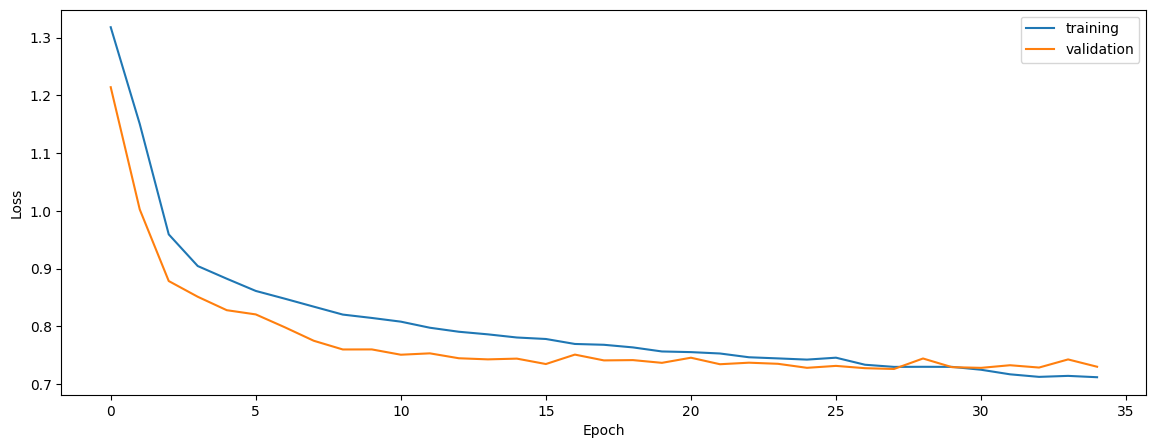

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuracy(train[1],train_pred))
print(getAccuracy(val[1],val_pred))
print(getAccuracy(test[1],test_pred))

train
0.7134734246343374
0.7079736567941658
0.7087476932540496


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuracy(train2[1],train_pred2))
print(getAccuracy(val2[1],val_pred2))
print(getAccuracy(test2[1],test_pred2))

normalized
0.7134734246343374
0.7079736567941658
0.7087476932540496


In [9]:
print('native')
print(getAccuracy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuracy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuracy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.7173636853194749
0.7159545188487739
0.7064806828658954


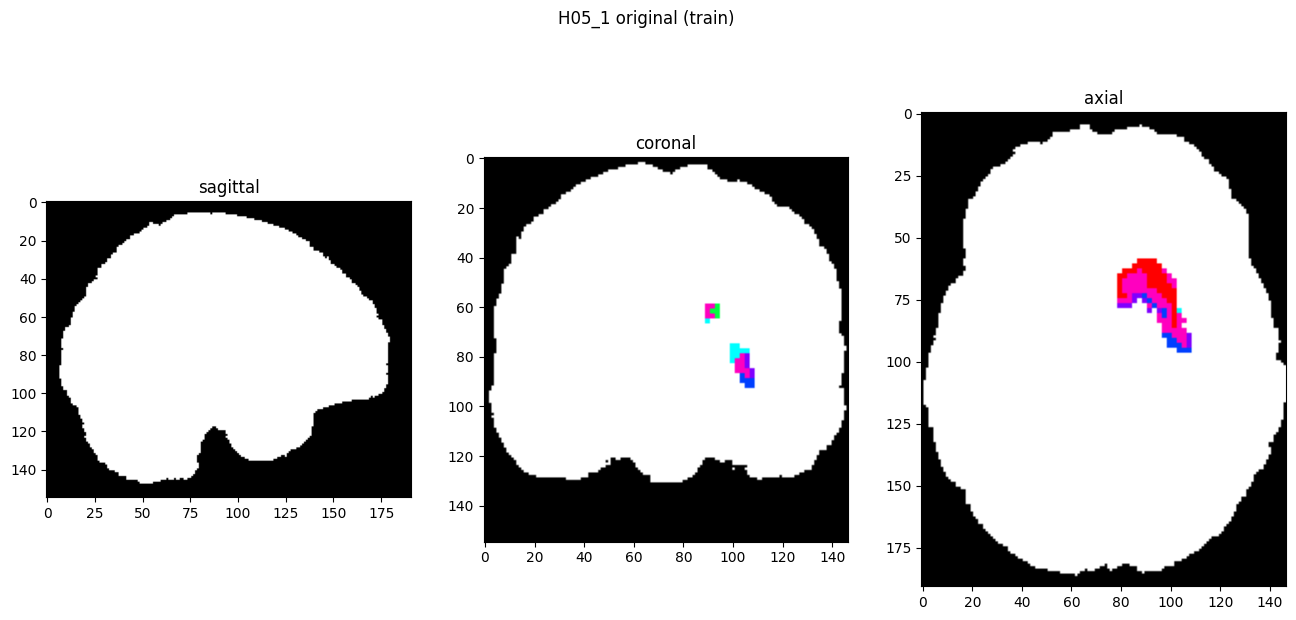

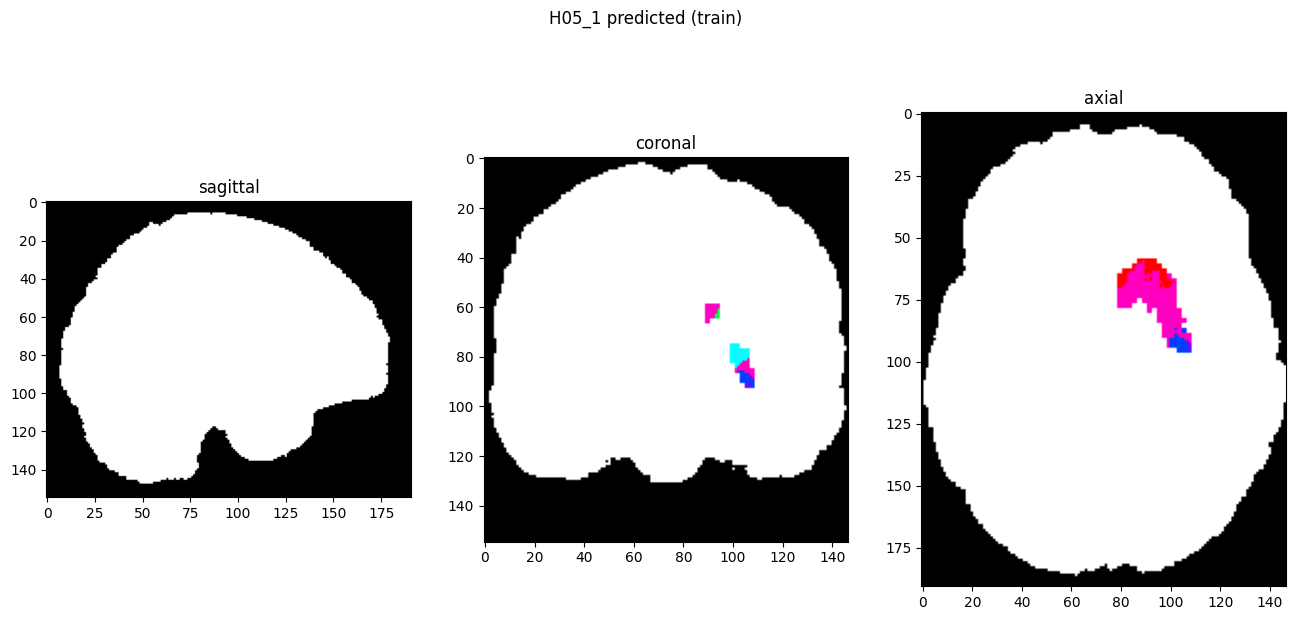

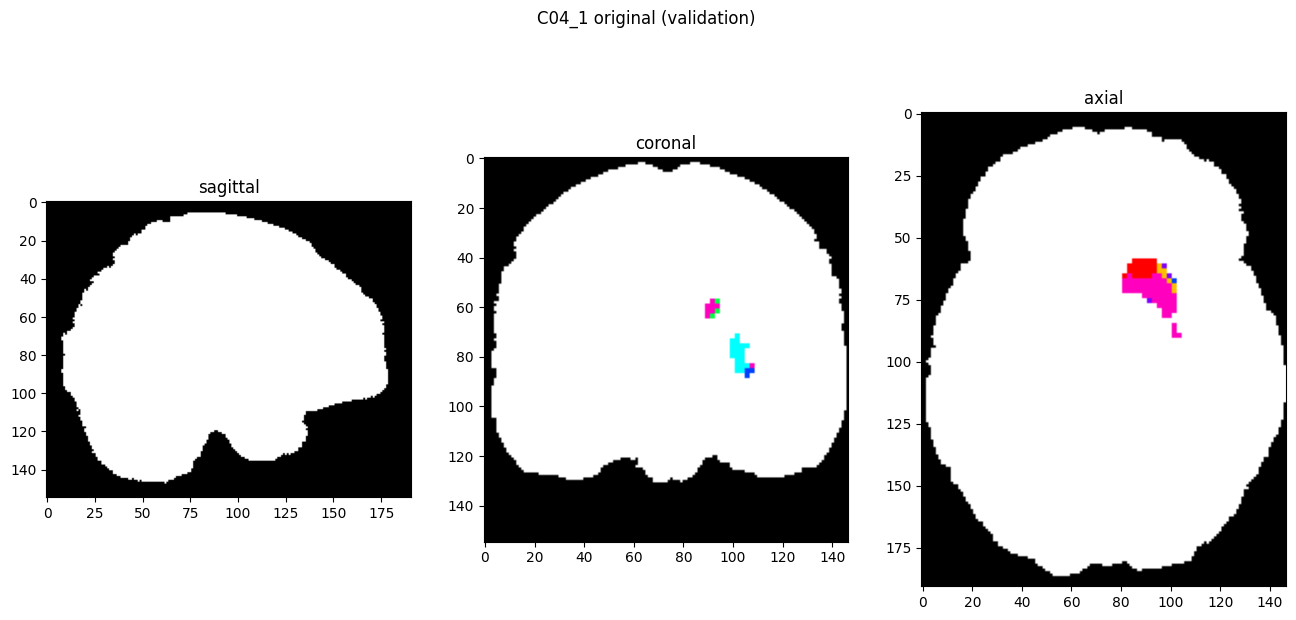

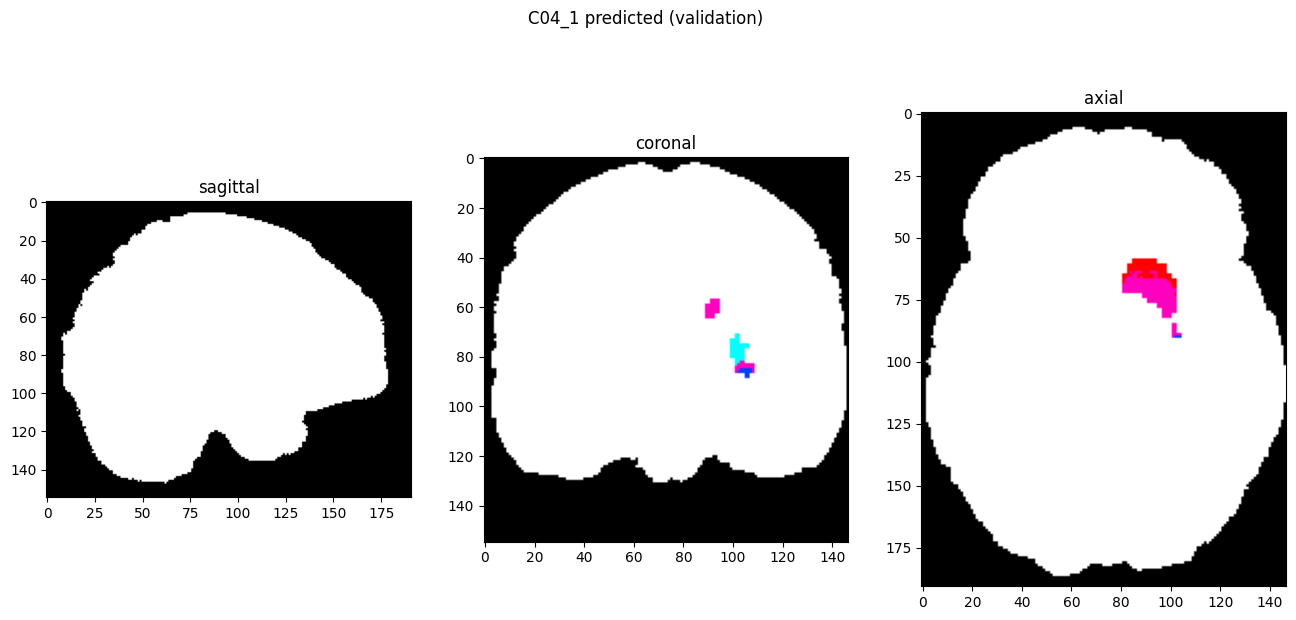

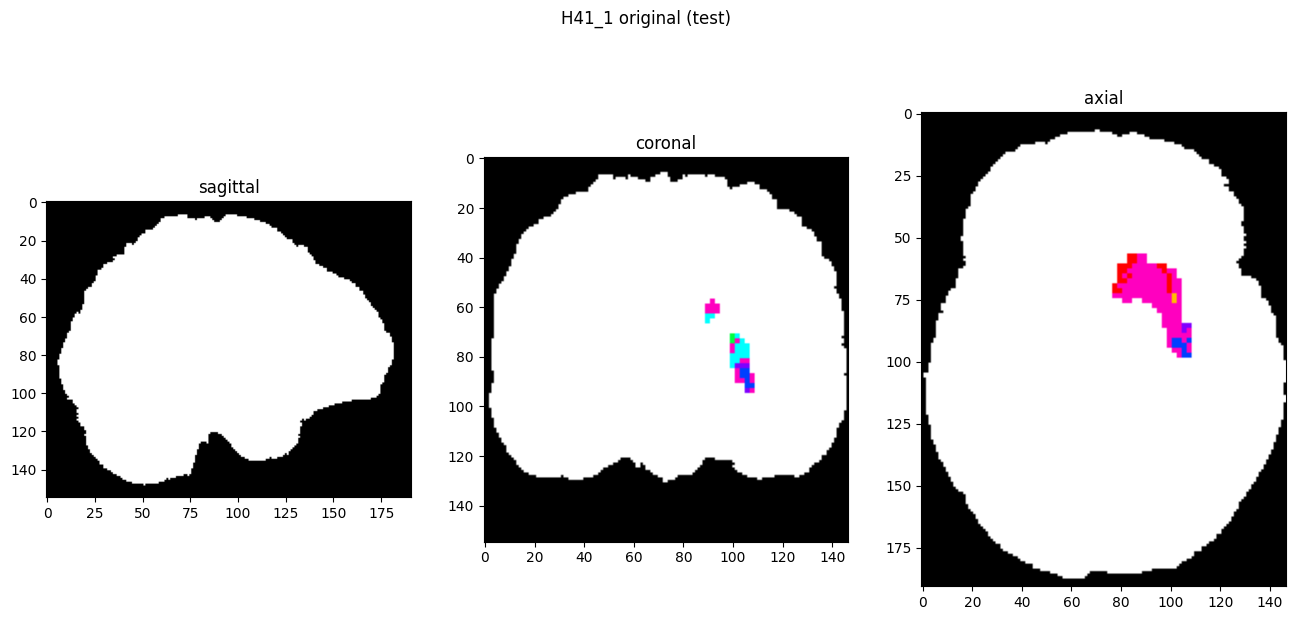

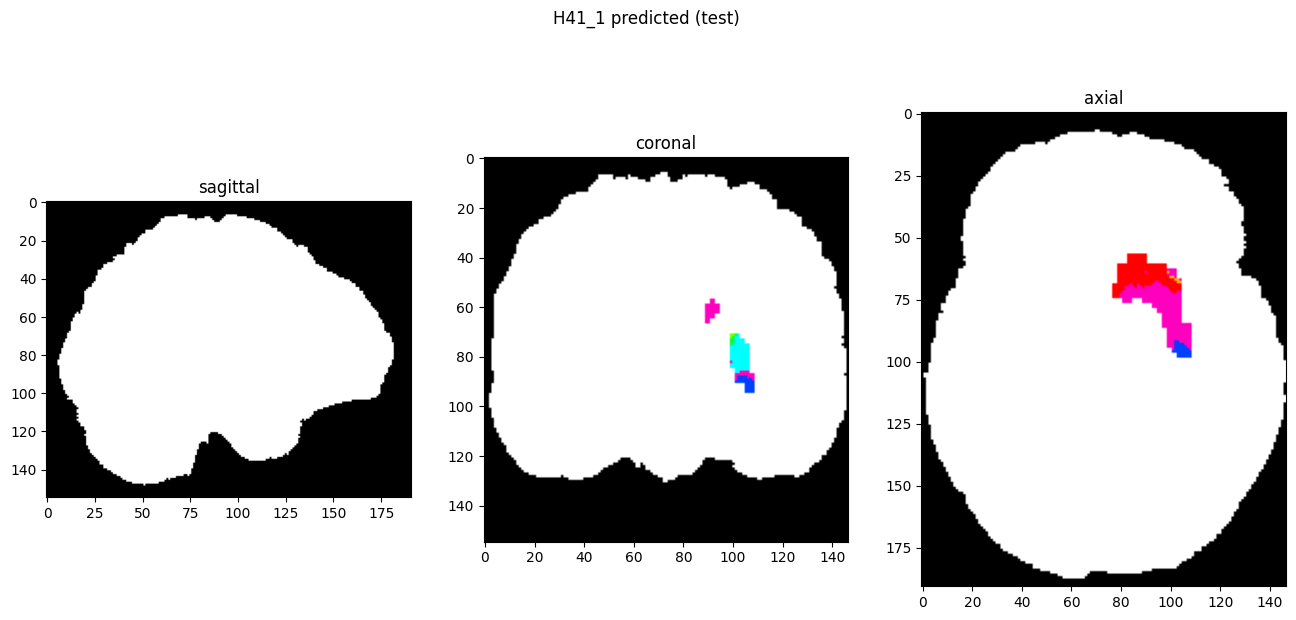

In [10]:
showResults(model, gen, threshold=0)